In [51]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout

In [52]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [53]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
1,Absol ex - 135/197,['Holofoil Market Price: '],8/2 to 8/4,$4.74
2,Absol ex - 135/197,['Holofoil Market Price: '],8/5 to 8/7,$4.74
3,Absol ex - 135/197,['Holofoil Market Price: '],8/8 to 8/10,$2.04
4,Absol ex - 135/197,['Holofoil Market Price: '],8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/19 to 10/21,$0.06
12926,Zigzagoon,[' Market Price: '],10/22 to 10/24,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/22 to 10/24,$0.05
12928,Zigzagoon,[' Market Price: '],10/25 to 10/27,$0.03


In [54]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [55]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [56]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 7.57% of the dataset has $0.00 market price

0.0757153905645785

In [57]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [58]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,$0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,$0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05


In [59]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned['Market Price'] = of_cleaned['Market Price'].astype(float)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [60]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
11946,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
11947,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
11948,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
11949,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [61]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

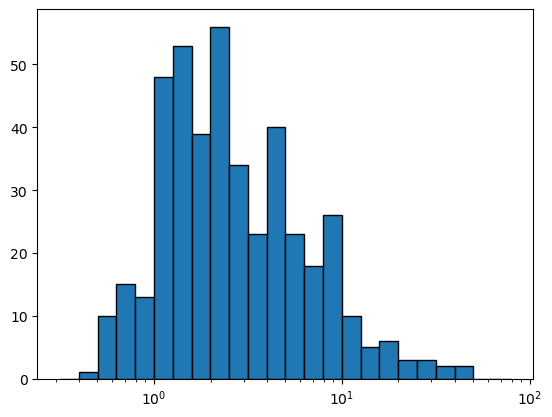

In [62]:
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [63]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 56% of the initial prices are more than double the latest price in the dataset

0.5627906976744186

In [64]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        # whether product matches the product from the previous line
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        # whether foil matches the foil from the previous line
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [65]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [66]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05,0.06,0.06


In [67]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.05


In [68]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11
5502,Zigzagoon,Reverse Holofoil,9/22 to 9/24,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.05,0.06,0.07,0.08,0.09,0.10


# Data Split

In [69]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '9/16 to 9/18',
       '9/19 to 9/21', '9/22 to 9/24', '9/25 to 9/27'], dtype=object)

In [73]:
# test set will contain everything from September 16th on
test = of_past_future_prices.loc[of_past_future_prices['Date Range'].isin(['9/16 to 9/18',
       '9/19 to 9/21', '9/22 to 9/24', '9/25 to 9/27'])]
train = of_past_future_prices.loc[of_past_future_prices['Date Range'].isin(['8/14 to 8/16', 
        '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 135/197,Holofoil,9/16 to 9/18,0.96,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,1.16,1.03,1.04,1.00,0.94
12,Absol ex - 135/197,Holofoil,9/19 to 9/21,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.96,1.16,1.03,1.04,1.00
13,Absol ex - 135/197,Holofoil,9/22 to 9/24,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,0.96,0.96,1.16,1.03,1.04
14,Absol ex - 135/197,Holofoil,9/25 to 9/27,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,1.03,1.08,0.96,0.96,1.16,1.03
24,Absol ex - 214/197,Holofoil,9/16 to 9/18,1.49,1.39,1.44,1.52,1.73,1.68,1.67,1.56,1.81,1.36,1.46,1.47,1.52,1.59,1.43,1.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,Zigzagoon,Normal,9/25 to 9/27,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.03,0.03,0.04,0.04
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11
5502,Zigzagoon,Reverse Holofoil,9/22 to 9/24,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.05,0.06,0.07,0.08,0.09,0.10


In [74]:
train['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'], dtype=object)

In [75]:
train

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
5496,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07
5497,Zigzagoon,Reverse Holofoil,9/7 to 9/9,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.11,0.10,0.08,0.07,0.07
5498,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07


In [76]:
of_cleaned.iloc[5884]

Product             Lillipup
Foil                  Normal
Date Range      8/23 to 8/25
Market Price            0.06
Name: 5884, dtype: object

In [77]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [78]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [79]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [80]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,-0.298742
1,Previous Market Price_2,0.036166
2,Previous Market Price_3,-0.005365
3,Previous Market Price_4,0.104900
4,Previous Market Price_5,-0.147127
5,Market Price,1.264034
6,Foil_Holofoil,-0.161400
7,Foil_Normal,0.054710
8,Foil_Reverse Holofoil,0.106690


In [81]:
y_pred = classifier.predict(X_test)

In [82]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [83]:
regression_results(y_test, y_pred)
# over 99% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9986
r2:  0.9986
MAE:  0.2199
MSE:  1.4743
RMSE:  1.2142


# LSTM

In [84]:
X_train = train[['Previous Market Price_5', 'Previous Market Price_4', 'Previous Market Price_3',
              'Previous Market Price_2', 'Previous Market Price_1', 'Market Price']]
# row_list = []
# for index, row in X_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_train = row_list
X_test = test[['Previous Market Price_5', 'Previous Market Price_4', 'Previous Market Price_3',
              'Previous Market Price_2', 'Previous Market Price_1', 'Market Price']]
# row_list = []
# for index, row in X_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_test = row_list
# y_train = train[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_train = row_list
# y_test = test[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_test = row_list

In [85]:
X_train['Market Price']

0       0.86
1       0.81
2       0.81
3       0.92
4       0.93
        ... 
5495    0.10
5496    0.11
5497    0.10
5498    0.09
5499    0.08
Name: Market Price, Length: 3788, dtype: float64

In [86]:
# need a many to many lstm
# https://github.com/keras-team/keras/issues/6063

model = Sequential()  
model.add(LSTM(2, input_dim=1, return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='linear'))
model.add(Dense(1, activation='linear'))
# model.add(Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2)                 32        
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(X_train, y_train,epochs=10000, validation_data=(X_test, y_test))

Epoch 1/10000
119/119 [==============================] - 3s 6ms/step - loss: 1390.6318 - mean_squared_error: 1390.6318 - val_loss: 1072.9407 - val_mean_squared_error: 1072.9407
Epoch 2/10000
119/119 [==============================] - 0s 3ms/step - loss: 1389.0293 - mean_squared_error: 1389.0293 - val_loss: 1071.8517 - val_mean_squared_error: 1071.8517
Epoch 3/10000
119/119 [==============================] - 0s 3ms/step - loss: 1387.6062 - mean_squared_error: 1387.6062 - val_loss: 1070.5140 - val_mean_squared_error: 1070.5140
Epoch 4/10000
119/119 [==============================] - 0s 3ms/step - loss: 1385.8097 - mean_squared_error: 1385.8097 - val_loss: 1068.8984 - val_mean_squared_error: 1068.8984
Epoch 5/10000
119/119 [==============================] - 0s 3ms/step - loss: 1383.3395 - mean_squared_error: 1383.3395 - val_loss: 1066.0989 - val_mean_squared_error: 1066.0989
Epoch 6/10000
119/119 [==============================] - 0s 3ms/step - loss: 1375.4562 - mean_squared_error: 1375.4

119/119 [==============================] - 0s 3ms/step - loss: 1317.1119 - mean_squared_error: 1317.1119 - val_loss: 1015.8595 - val_mean_squared_error: 1015.8595
Epoch 48/10000
119/119 [==============================] - 0s 3ms/step - loss: 1315.9421 - mean_squared_error: 1315.9421 - val_loss: 1014.9172 - val_mean_squared_error: 1014.9172
Epoch 49/10000
119/119 [==============================] - 0s 3ms/step - loss: 1314.7175 - mean_squared_error: 1314.7175 - val_loss: 1013.9020 - val_mean_squared_error: 1013.9020
Epoch 50/10000
119/119 [==============================] - 0s 3ms/step - loss: 1313.4590 - mean_squared_error: 1313.4590 - val_loss: 1012.9638 - val_mean_squared_error: 1012.9638
Epoch 51/10000
119/119 [==============================] - 0s 3ms/step - loss: 1312.2433 - mean_squared_error: 1312.2433 - val_loss: 1012.0513 - val_mean_squared_error: 1012.0513
Epoch 52/10000
119/119 [==============================] - 0s 3ms/step - loss: 1311.0751 - mean_squared_error: 1311.0751 - val

119/119 [==============================] - 0s 3ms/step - loss: 1264.9996 - mean_squared_error: 1264.9996 - val_loss: 975.6616 - val_mean_squared_error: 975.6616
Epoch 94/10000
119/119 [==============================] - 0s 3ms/step - loss: 1263.9374 - mean_squared_error: 1263.9374 - val_loss: 974.9011 - val_mean_squared_error: 974.9011
Epoch 95/10000
119/119 [==============================] - 0s 3ms/step - loss: 1262.8717 - mean_squared_error: 1262.8717 - val_loss: 974.0485 - val_mean_squared_error: 974.0485
Epoch 96/10000
119/119 [==============================] - 0s 3ms/step - loss: 1261.8699 - mean_squared_error: 1261.8699 - val_loss: 973.2179 - val_mean_squared_error: 973.2179
Epoch 97/10000
119/119 [==============================] - 0s 3ms/step - loss: 1260.7959 - mean_squared_error: 1260.7959 - val_loss: 972.4009 - val_mean_squared_error: 972.4009
Epoch 98/10000
119/119 [==============================] - 0s 3ms/step - loss: 1259.8350 - mean_squared_error: 1259.8350 - val_loss: 971

119/119 [==============================] - 0s 3ms/step - loss: 1219.3202 - mean_squared_error: 1219.3202 - val_loss: 940.4860 - val_mean_squared_error: 940.4860
Epoch 140/10000
119/119 [==============================] - 0s 3ms/step - loss: 1218.3250 - mean_squared_error: 1218.3250 - val_loss: 939.7964 - val_mean_squared_error: 939.7964
Epoch 141/10000
119/119 [==============================] - 0s 3ms/step - loss: 1217.4460 - mean_squared_error: 1217.4460 - val_loss: 939.0534 - val_mean_squared_error: 939.0534
Epoch 142/10000
119/119 [==============================] - 0s 3ms/step - loss: 1216.4707 - mean_squared_error: 1216.4707 - val_loss: 938.3057 - val_mean_squared_error: 938.3057
Epoch 143/10000
119/119 [==============================] - 0s 3ms/step - loss: 1215.5455 - mean_squared_error: 1215.5455 - val_loss: 937.5585 - val_mean_squared_error: 937.5585
Epoch 144/10000
119/119 [==============================] - 0s 3ms/step - loss: 1214.6398 - mean_squared_error: 1214.6398 - val_loss

119/119 [==============================] - 0s 3ms/step - loss: 1178.0033 - mean_squared_error: 1178.0033 - val_loss: 908.6823 - val_mean_squared_error: 908.6823
Epoch 186/10000
119/119 [==============================] - 0s 3ms/step - loss: 1177.1309 - mean_squared_error: 1177.1309 - val_loss: 908.0530 - val_mean_squared_error: 908.0530
Epoch 187/10000
119/119 [==============================] - 0s 3ms/step - loss: 1176.3473 - mean_squared_error: 1176.3473 - val_loss: 907.4056 - val_mean_squared_error: 907.4056
Epoch 188/10000
119/119 [==============================] - 0s 3ms/step - loss: 1175.4458 - mean_squared_error: 1175.4458 - val_loss: 906.7115 - val_mean_squared_error: 906.7115
Epoch 189/10000
119/119 [==============================] - 0s 3ms/step - loss: 1174.6233 - mean_squared_error: 1174.6233 - val_loss: 906.0953 - val_mean_squared_error: 906.0953
Epoch 190/10000
119/119 [==============================] - 0s 3ms/step - loss: 1173.8397 - mean_squared_error: 1173.8397 - val_loss

119/119 [==============================] - 0s 3ms/step - loss: 1139.3376 - mean_squared_error: 1139.3376 - val_loss: 878.9352 - val_mean_squared_error: 878.9352
Epoch 232/10000
119/119 [==============================] - 0s 3ms/step - loss: 1138.5833 - mean_squared_error: 1138.5833 - val_loss: 878.3069 - val_mean_squared_error: 878.3069
Epoch 233/10000
119/119 [==============================] - 0s 3ms/step - loss: 1137.6790 - mean_squared_error: 1137.6790 - val_loss: 877.6909 - val_mean_squared_error: 877.6909
Epoch 234/10000
119/119 [==============================] - 0s 3ms/step - loss: 1136.8748 - mean_squared_error: 1136.8748 - val_loss: 876.9932 - val_mean_squared_error: 876.9932
Epoch 235/10000
119/119 [==============================] - 0s 3ms/step - loss: 1135.9481 - mean_squared_error: 1135.9481 - val_loss: 876.3069 - val_mean_squared_error: 876.3069
Epoch 236/10000
119/119 [==============================] - 0s 3ms/step - loss: 1135.1592 - mean_squared_error: 1135.1592 - val_loss

119/119 [==============================] - 0s 3ms/step - loss: 1103.2408 - mean_squared_error: 1103.2408 - val_loss: 851.0972 - val_mean_squared_error: 851.0972
Epoch 278/10000
119/119 [==============================] - 0s 3ms/step - loss: 1102.4279 - mean_squared_error: 1102.4279 - val_loss: 850.5474 - val_mean_squared_error: 850.5474
Epoch 279/10000
119/119 [==============================] - 0s 3ms/step - loss: 1101.8040 - mean_squared_error: 1101.8040 - val_loss: 850.0739 - val_mean_squared_error: 850.0739
Epoch 280/10000
119/119 [==============================] - 0s 3ms/step - loss: 1101.0216 - mean_squared_error: 1101.0216 - val_loss: 849.4355 - val_mean_squared_error: 849.4355
Epoch 281/10000
119/119 [==============================] - 0s 3ms/step - loss: 1100.2682 - mean_squared_error: 1100.2682 - val_loss: 848.8795 - val_mean_squared_error: 848.8795
Epoch 282/10000
119/119 [==============================] - 0s 3ms/step - loss: 1099.5746 - mean_squared_error: 1099.5746 - val_loss

119/119 [==============================] - 0s 3ms/step - loss: 1068.7599 - mean_squared_error: 1068.7599 - val_loss: 824.6869 - val_mean_squared_error: 824.6869
Epoch 324/10000
119/119 [==============================] - 0s 3ms/step - loss: 1068.0580 - mean_squared_error: 1068.0580 - val_loss: 824.1261 - val_mean_squared_error: 824.1261
Epoch 325/10000
119/119 [==============================] - 0s 3ms/step - loss: 1067.2469 - mean_squared_error: 1067.2469 - val_loss: 823.5438 - val_mean_squared_error: 823.5438
Epoch 326/10000
119/119 [==============================] - 0s 3ms/step - loss: 1066.5396 - mean_squared_error: 1066.5396 - val_loss: 823.0050 - val_mean_squared_error: 823.0050
Epoch 327/10000
119/119 [==============================] - 0s 3ms/step - loss: 1065.8162 - mean_squared_error: 1065.8162 - val_loss: 822.4182 - val_mean_squared_error: 822.4182
Epoch 328/10000
119/119 [==============================] - 0s 3ms/step - loss: 1065.0947 - mean_squared_error: 1065.0947 - val_loss

119/119 [==============================] - 0s 3ms/step - loss: 1036.1873 - mean_squared_error: 1036.1873 - val_loss: 799.6395 - val_mean_squared_error: 799.6395
Epoch 370/10000
119/119 [==============================] - 0s 3ms/step - loss: 1035.4457 - mean_squared_error: 1035.4457 - val_loss: 799.0434 - val_mean_squared_error: 799.0434
Epoch 371/10000
119/119 [==============================] - 0s 3ms/step - loss: 1034.7894 - mean_squared_error: 1034.7894 - val_loss: 798.5729 - val_mean_squared_error: 798.5729
Epoch 372/10000
119/119 [==============================] - 0s 3ms/step - loss: 1034.1427 - mean_squared_error: 1034.1427 - val_loss: 798.0093 - val_mean_squared_error: 798.0093
Epoch 373/10000
119/119 [==============================] - 0s 3ms/step - loss: 1033.3817 - mean_squared_error: 1033.3817 - val_loss: 797.4604 - val_mean_squared_error: 797.4604
Epoch 374/10000
119/119 [==============================] - 0s 3ms/step - loss: 1032.6823 - mean_squared_error: 1032.6823 - val_loss

119/119 [==============================] - 0s 3ms/step - loss: 1005.1635 - mean_squared_error: 1005.1635 - val_loss: 775.8228 - val_mean_squared_error: 775.8228
Epoch 416/10000
119/119 [==============================] - 0s 3ms/step - loss: 1004.5536 - mean_squared_error: 1004.5536 - val_loss: 775.3453 - val_mean_squared_error: 775.3453
Epoch 417/10000
119/119 [==============================] - 0s 3ms/step - loss: 1003.9199 - mean_squared_error: 1003.9199 - val_loss: 774.8298 - val_mean_squared_error: 774.8298
Epoch 418/10000
119/119 [==============================] - 0s 3ms/step - loss: 1003.2109 - mean_squared_error: 1003.2109 - val_loss: 774.3260 - val_mean_squared_error: 774.3260
Epoch 419/10000
119/119 [==============================] - 0s 3ms/step - loss: 1002.6210 - mean_squared_error: 1002.6210 - val_loss: 773.8808 - val_mean_squared_error: 773.8808
Epoch 420/10000
119/119 [==============================] - 0s 3ms/step - loss: 1002.0066 - mean_squared_error: 1002.0066 - val_loss

Epoch 462/10000
119/119 [==============================] - 0s 3ms/step - loss: 975.8729 - mean_squared_error: 975.8729 - val_loss: 753.2194 - val_mean_squared_error: 753.2194
Epoch 463/10000
119/119 [==============================] - 0s 3ms/step - loss: 975.2792 - mean_squared_error: 975.2792 - val_loss: 752.7863 - val_mean_squared_error: 752.7863
Epoch 464/10000
119/119 [==============================] - 0s 3ms/step - loss: 974.7460 - mean_squared_error: 974.7460 - val_loss: 752.3472 - val_mean_squared_error: 752.3472
Epoch 465/10000
119/119 [==============================] - 0s 3ms/step - loss: 974.1515 - mean_squared_error: 974.1515 - val_loss: 751.8555 - val_mean_squared_error: 751.8555
Epoch 466/10000
119/119 [==============================] - 0s 3ms/step - loss: 973.5682 - mean_squared_error: 973.5682 - val_loss: 751.4402 - val_mean_squared_error: 751.4402
Epoch 467/10000
119/119 [==============================] - 0s 3ms/step - loss: 972.9196 - mean_squared_error: 972.9196 - val_

Epoch 509/10000
119/119 [==============================] - 0s 3ms/step - loss: 948.1370 - mean_squared_error: 948.1370 - val_loss: 731.6893 - val_mean_squared_error: 731.6893
Epoch 510/10000
119/119 [==============================] - 0s 3ms/step - loss: 947.5238 - mean_squared_error: 947.5238 - val_loss: 731.4584 - val_mean_squared_error: 731.4584
Epoch 511/10000
119/119 [==============================] - 0s 3ms/step - loss: 946.9764 - mean_squared_error: 946.9764 - val_loss: 730.7700 - val_mean_squared_error: 730.7700
Epoch 512/10000
119/119 [==============================] - 0s 3ms/step - loss: 946.4108 - mean_squared_error: 946.4108 - val_loss: 730.3717 - val_mean_squared_error: 730.3717
Epoch 513/10000
119/119 [==============================] - 0s 3ms/step - loss: 945.9095 - mean_squared_error: 945.9095 - val_loss: 730.0870 - val_mean_squared_error: 730.0870
Epoch 514/10000
119/119 [==============================] - 0s 3ms/step - loss: 945.3441 - mean_squared_error: 945.3441 - val_

Epoch 556/10000
119/119 [==============================] - 0s 3ms/step - loss: 921.4578 - mean_squared_error: 921.4578 - val_loss: 710.8829 - val_mean_squared_error: 710.8829
Epoch 557/10000
119/119 [==============================] - 0s 3ms/step - loss: 920.8254 - mean_squared_error: 920.8254 - val_loss: 710.4480 - val_mean_squared_error: 710.4480
Epoch 558/10000
119/119 [==============================] - 0s 3ms/step - loss: 920.3275 - mean_squared_error: 920.3275 - val_loss: 710.0126 - val_mean_squared_error: 710.0126
Epoch 559/10000
119/119 [==============================] - 0s 3ms/step - loss: 919.8212 - mean_squared_error: 919.8212 - val_loss: 709.6115 - val_mean_squared_error: 709.6115
Epoch 560/10000
119/119 [==============================] - 0s 3ms/step - loss: 919.2899 - mean_squared_error: 919.2899 - val_loss: 709.4175 - val_mean_squared_error: 709.4175
Epoch 561/10000
119/119 [==============================] - 0s 3ms/step - loss: 918.7722 - mean_squared_error: 918.7722 - val_

Epoch 603/10000
119/119 [==============================] - 0s 3ms/step - loss: 896.2196 - mean_squared_error: 896.2196 - val_loss: 691.2966 - val_mean_squared_error: 691.2966
Epoch 604/10000
119/119 [==============================] - 0s 3ms/step - loss: 895.8060 - mean_squared_error: 895.8060 - val_loss: 690.8004 - val_mean_squared_error: 690.8004
Epoch 605/10000
119/119 [==============================] - 0s 3ms/step - loss: 895.2194 - mean_squared_error: 895.2194 - val_loss: 690.4365 - val_mean_squared_error: 690.4365
Epoch 606/10000
119/119 [==============================] - 0s 3ms/step - loss: 894.7234 - mean_squared_error: 894.7234 - val_loss: 689.9778 - val_mean_squared_error: 689.9778
Epoch 607/10000
119/119 [==============================] - 0s 3ms/step - loss: 894.2506 - mean_squared_error: 894.2506 - val_loss: 689.7285 - val_mean_squared_error: 689.7285
Epoch 608/10000
119/119 [==============================] - 0s 3ms/step - loss: 893.6144 - mean_squared_error: 893.6144 - val_

Epoch 650/10000
119/119 [==============================] - 0s 3ms/step - loss: 871.8278 - mean_squared_error: 871.8278 - val_loss: 672.1666 - val_mean_squared_error: 672.1666
Epoch 651/10000
119/119 [==============================] - 0s 3ms/step - loss: 871.2020 - mean_squared_error: 871.2020 - val_loss: 671.9330 - val_mean_squared_error: 671.9330
Epoch 652/10000
119/119 [==============================] - 0s 3ms/step - loss: 870.8007 - mean_squared_error: 870.8007 - val_loss: 671.1624 - val_mean_squared_error: 671.1624
Epoch 653/10000
119/119 [==============================] - 0s 3ms/step - loss: 870.1857 - mean_squared_error: 870.1857 - val_loss: 671.4485 - val_mean_squared_error: 671.4485
Epoch 654/10000
119/119 [==============================] - 0s 3ms/step - loss: 869.7501 - mean_squared_error: 869.7501 - val_loss: 670.5515 - val_mean_squared_error: 670.5515
Epoch 655/10000
119/119 [==============================] - 0s 3ms/step - loss: 869.2883 - mean_squared_error: 869.2883 - val_

Epoch 697/10000
119/119 [==============================] - 0s 3ms/step - loss: 848.2173 - mean_squared_error: 848.2173 - val_loss: 653.7000 - val_mean_squared_error: 653.7000
Epoch 698/10000
119/119 [==============================] - 0s 3ms/step - loss: 847.8449 - mean_squared_error: 847.8449 - val_loss: 653.5381 - val_mean_squared_error: 653.5381
Epoch 699/10000
119/119 [==============================] - 0s 3ms/step - loss: 847.2134 - mean_squared_error: 847.2134 - val_loss: 652.8410 - val_mean_squared_error: 652.8410
Epoch 700/10000
119/119 [==============================] - 0s 3ms/step - loss: 846.6606 - mean_squared_error: 846.6606 - val_loss: 653.0536 - val_mean_squared_error: 653.0536
Epoch 701/10000
119/119 [==============================] - 0s 3ms/step - loss: 846.3029 - mean_squared_error: 846.3029 - val_loss: 652.4487 - val_mean_squared_error: 652.4487
Epoch 702/10000
119/119 [==============================] - 0s 3ms/step - loss: 845.9055 - mean_squared_error: 845.9055 - val_

Epoch 744/10000
119/119 [==============================] - 0s 3ms/step - loss: 824.8654 - mean_squared_error: 824.8654 - val_loss: 635.6833 - val_mean_squared_error: 635.6833
Epoch 745/10000
119/119 [==============================] - 0s 3ms/step - loss: 824.3942 - mean_squared_error: 824.3942 - val_loss: 635.6973 - val_mean_squared_error: 635.6973
Epoch 746/10000
119/119 [==============================] - 0s 3ms/step - loss: 824.0505 - mean_squared_error: 824.0505 - val_loss: 634.8052 - val_mean_squared_error: 634.8052
Epoch 747/10000
119/119 [==============================] - 0s 3ms/step - loss: 823.5325 - mean_squared_error: 823.5325 - val_loss: 634.3399 - val_mean_squared_error: 634.3399
Epoch 748/10000
119/119 [==============================] - 0s 3ms/step - loss: 822.9800 - mean_squared_error: 822.9800 - val_loss: 634.4570 - val_mean_squared_error: 634.4570
Epoch 749/10000
119/119 [==============================] - 0s 3ms/step - loss: 822.6071 - mean_squared_error: 822.6071 - val_

Epoch 791/10000
119/119 [==============================] - 0s 3ms/step - loss: 802.5792 - mean_squared_error: 802.5792 - val_loss: 617.9454 - val_mean_squared_error: 617.9454
Epoch 792/10000
119/119 [==============================] - 0s 3ms/step - loss: 801.9910 - mean_squared_error: 801.9910 - val_loss: 617.4911 - val_mean_squared_error: 617.4911
Epoch 793/10000
119/119 [==============================] - 0s 3ms/step - loss: 801.5008 - mean_squared_error: 801.5008 - val_loss: 617.6980 - val_mean_squared_error: 617.6980
Epoch 794/10000
119/119 [==============================] - 0s 3ms/step - loss: 801.0123 - mean_squared_error: 801.0123 - val_loss: 617.0665 - val_mean_squared_error: 617.0665
Epoch 795/10000
119/119 [==============================] - 0s 3ms/step - loss: 800.7219 - mean_squared_error: 800.7219 - val_loss: 616.4713 - val_mean_squared_error: 616.4713
Epoch 796/10000
119/119 [==============================] - 0s 3ms/step - loss: 800.0542 - mean_squared_error: 800.0542 - val_

Epoch 838/10000
119/119 [==============================] - 0s 3ms/step - loss: 779.9833 - mean_squared_error: 779.9833 - val_loss: 600.3256 - val_mean_squared_error: 600.3256
Epoch 839/10000
119/119 [==============================] - 0s 3ms/step - loss: 779.5153 - mean_squared_error: 779.5153 - val_loss: 600.0637 - val_mean_squared_error: 600.0637
Epoch 840/10000
119/119 [==============================] - 0s 3ms/step - loss: 778.9999 - mean_squared_error: 778.9999 - val_loss: 599.6332 - val_mean_squared_error: 599.6332
Epoch 841/10000
119/119 [==============================] - 0s 3ms/step - loss: 778.4986 - mean_squared_error: 778.4986 - val_loss: 599.1617 - val_mean_squared_error: 599.1617
Epoch 842/10000
119/119 [==============================] - 0s 3ms/step - loss: 778.0831 - mean_squared_error: 778.0831 - val_loss: 598.7628 - val_mean_squared_error: 598.7628
Epoch 843/10000
119/119 [==============================] - 0s 3ms/step - loss: 777.5764 - mean_squared_error: 777.5764 - val_

Epoch 885/10000
119/119 [==============================] - 0s 3ms/step - loss: 757.8552 - mean_squared_error: 757.8552 - val_loss: 583.1862 - val_mean_squared_error: 583.1862
Epoch 886/10000
119/119 [==============================] - 0s 3ms/step - loss: 757.4552 - mean_squared_error: 757.4552 - val_loss: 582.9764 - val_mean_squared_error: 582.9764
Epoch 887/10000
119/119 [==============================] - 0s 3ms/step - loss: 756.8635 - mean_squared_error: 756.8635 - val_loss: 582.2860 - val_mean_squared_error: 582.2860
Epoch 888/10000
119/119 [==============================] - 0s 3ms/step - loss: 756.5215 - mean_squared_error: 756.5215 - val_loss: 581.9987 - val_mean_squared_error: 581.9987
Epoch 889/10000
119/119 [==============================] - 0s 3ms/step - loss: 755.9310 - mean_squared_error: 755.9310 - val_loss: 581.5308 - val_mean_squared_error: 581.5308
Epoch 890/10000
119/119 [==============================] - 0s 3ms/step - loss: 755.4365 - mean_squared_error: 755.4365 - val_

Epoch 932/10000
119/119 [==============================] - 0s 3ms/step - loss: 736.4280 - mean_squared_error: 736.4280 - val_loss: 566.8219 - val_mean_squared_error: 566.8219
Epoch 933/10000
119/119 [==============================] - 0s 3ms/step - loss: 736.1242 - mean_squared_error: 736.1242 - val_loss: 566.0214 - val_mean_squared_error: 566.0214
Epoch 934/10000
119/119 [==============================] - 0s 3ms/step - loss: 735.6708 - mean_squared_error: 735.6708 - val_loss: 565.6422 - val_mean_squared_error: 565.6422
Epoch 935/10000
119/119 [==============================] - 0s 3ms/step - loss: 735.3753 - mean_squared_error: 735.3753 - val_loss: 565.4753 - val_mean_squared_error: 565.4753
Epoch 936/10000
119/119 [==============================] - 0s 3ms/step - loss: 734.8350 - mean_squared_error: 734.8350 - val_loss: 565.1104 - val_mean_squared_error: 565.1104
Epoch 937/10000
119/119 [==============================] - 0s 3ms/step - loss: 734.3956 - mean_squared_error: 734.3956 - val_

Epoch 979/10000
119/119 [==============================] - 0s 3ms/step - loss: 715.1323 - mean_squared_error: 715.1323 - val_loss: 549.6575 - val_mean_squared_error: 549.6575
Epoch 980/10000
119/119 [==============================] - 0s 3ms/step - loss: 714.5126 - mean_squared_error: 714.5126 - val_loss: 549.2538 - val_mean_squared_error: 549.2538
Epoch 981/10000
119/119 [==============================] - 0s 3ms/step - loss: 714.2867 - mean_squared_error: 714.2867 - val_loss: 549.0574 - val_mean_squared_error: 549.0574
Epoch 982/10000
119/119 [==============================] - 0s 3ms/step - loss: 713.7588 - mean_squared_error: 713.7588 - val_loss: 548.5893 - val_mean_squared_error: 548.5893
Epoch 983/10000
119/119 [==============================] - 0s 3ms/step - loss: 713.4083 - mean_squared_error: 713.4083 - val_loss: 548.1830 - val_mean_squared_error: 548.1830
Epoch 984/10000
119/119 [==============================] - 0s 3ms/step - loss: 712.9836 - mean_squared_error: 712.9836 - val_

Epoch 1026/10000
119/119 [==============================] - 0s 3ms/step - loss: 694.4188 - mean_squared_error: 694.4188 - val_loss: 533.6857 - val_mean_squared_error: 533.6857
Epoch 1027/10000
119/119 [==============================] - 0s 3ms/step - loss: 693.9924 - mean_squared_error: 693.9924 - val_loss: 533.0190 - val_mean_squared_error: 533.0190
Epoch 1028/10000
119/119 [==============================] - 0s 3ms/step - loss: 693.4094 - mean_squared_error: 693.4094 - val_loss: 532.6959 - val_mean_squared_error: 532.6959
Epoch 1029/10000
119/119 [==============================] - 0s 3ms/step - loss: 693.0468 - mean_squared_error: 693.0468 - val_loss: 532.3229 - val_mean_squared_error: 532.3229
Epoch 1030/10000
119/119 [==============================] - 0s 3ms/step - loss: 692.5306 - mean_squared_error: 692.5306 - val_loss: 531.9645 - val_mean_squared_error: 531.9645
Epoch 1031/10000
119/119 [==============================] - 0s 3ms/step - loss: 692.1091 - mean_squared_error: 692.1091 

119/119 [==============================] - 0s 3ms/step - loss: 674.3393 - mean_squared_error: 674.3393 - val_loss: 518.1393 - val_mean_squared_error: 518.1393
Epoch 1073/10000
119/119 [==============================] - 0s 3ms/step - loss: 673.6874 - mean_squared_error: 673.6874 - val_loss: 517.4734 - val_mean_squared_error: 517.4734
Epoch 1074/10000
119/119 [==============================] - 0s 3ms/step - loss: 673.3863 - mean_squared_error: 673.3863 - val_loss: 517.0756 - val_mean_squared_error: 517.0756
Epoch 1075/10000
119/119 [==============================] - 0s 3ms/step - loss: 672.9229 - mean_squared_error: 672.9229 - val_loss: 516.7595 - val_mean_squared_error: 516.7595
Epoch 1076/10000
119/119 [==============================] - 0s 3ms/step - loss: 672.6646 - mean_squared_error: 672.6646 - val_loss: 516.3489 - val_mean_squared_error: 516.3489
Epoch 1077/10000
119/119 [==============================] - 0s 3ms/step - loss: 672.0571 - mean_squared_error: 672.0571 - val_loss: 516.3

119/119 [==============================] - 0s 3ms/step - loss: 654.5273 - mean_squared_error: 654.5273 - val_loss: 502.3645 - val_mean_squared_error: 502.3645
Epoch 1119/10000
119/119 [==============================] - 0s 3ms/step - loss: 653.9637 - mean_squared_error: 653.9637 - val_loss: 502.0106 - val_mean_squared_error: 502.0106
Epoch 1120/10000
119/119 [==============================] - 0s 3ms/step - loss: 653.6370 - mean_squared_error: 653.6370 - val_loss: 501.7291 - val_mean_squared_error: 501.7291
Epoch 1121/10000
119/119 [==============================] - 0s 3ms/step - loss: 653.1674 - mean_squared_error: 653.1674 - val_loss: 501.9830 - val_mean_squared_error: 501.9830
Epoch 1122/10000
119/119 [==============================] - 0s 3ms/step - loss: 652.8562 - mean_squared_error: 652.8562 - val_loss: 501.0616 - val_mean_squared_error: 501.0616
Epoch 1123/10000
119/119 [==============================] - 0s 3ms/step - loss: 652.3871 - mean_squared_error: 652.3871 - val_loss: 500.7

119/119 [==============================] - 0s 3ms/step - loss: 635.2073 - mean_squared_error: 635.2073 - val_loss: 487.5259 - val_mean_squared_error: 487.5259
Epoch 1165/10000
119/119 [==============================] - 0s 3ms/step - loss: 634.9948 - mean_squared_error: 634.9948 - val_loss: 487.1106 - val_mean_squared_error: 487.1106
Epoch 1166/10000
119/119 [==============================] - 0s 3ms/step - loss: 634.5861 - mean_squared_error: 634.5861 - val_loss: 487.2474 - val_mean_squared_error: 487.2474
Epoch 1167/10000
119/119 [==============================] - 0s 3ms/step - loss: 634.2455 - mean_squared_error: 634.2455 - val_loss: 486.6062 - val_mean_squared_error: 486.6062
Epoch 1168/10000
119/119 [==============================] - 0s 3ms/step - loss: 633.5815 - mean_squared_error: 633.5815 - val_loss: 486.0779 - val_mean_squared_error: 486.0779
Epoch 1169/10000
119/119 [==============================] - 0s 3ms/step - loss: 633.0973 - mean_squared_error: 633.0973 - val_loss: 485.7

119/119 [==============================] - 0s 3ms/step - loss: 616.1710 - mean_squared_error: 616.1710 - val_loss: 473.2141 - val_mean_squared_error: 473.2141
Epoch 1211/10000
119/119 [==============================] - 0s 3ms/step - loss: 615.6642 - mean_squared_error: 615.6642 - val_loss: 472.1464 - val_mean_squared_error: 472.1464
Epoch 1212/10000
119/119 [==============================] - 0s 3ms/step - loss: 615.2753 - mean_squared_error: 615.2753 - val_loss: 472.6072 - val_mean_squared_error: 472.6072
Epoch 1213/10000
119/119 [==============================] - 0s 3ms/step - loss: 615.0012 - mean_squared_error: 615.0012 - val_loss: 471.5510 - val_mean_squared_error: 471.5510
Epoch 1214/10000
119/119 [==============================] - 0s 3ms/step - loss: 614.5198 - mean_squared_error: 614.5198 - val_loss: 471.2312 - val_mean_squared_error: 471.2312
Epoch 1215/10000
119/119 [==============================] - 0s 3ms/step - loss: 614.0613 - mean_squared_error: 614.0613 - val_loss: 471.2

119/119 [==============================] - 0s 3ms/step - loss: 598.0359 - mean_squared_error: 598.0359 - val_loss: 458.4307 - val_mean_squared_error: 458.4307
Epoch 1257/10000
119/119 [==============================] - 0s 3ms/step - loss: 597.3523 - mean_squared_error: 597.3523 - val_loss: 458.2818 - val_mean_squared_error: 458.2818
Epoch 1258/10000
119/119 [==============================] - 0s 3ms/step - loss: 597.0872 - mean_squared_error: 597.0872 - val_loss: 457.9554 - val_mean_squared_error: 457.9554
Epoch 1259/10000
119/119 [==============================] - 0s 3ms/step - loss: 596.7288 - mean_squared_error: 596.7288 - val_loss: 457.4141 - val_mean_squared_error: 457.4141
Epoch 1260/10000
119/119 [==============================] - 0s 3ms/step - loss: 596.2196 - mean_squared_error: 596.2196 - val_loss: 457.2735 - val_mean_squared_error: 457.2735
Epoch 1261/10000
119/119 [==============================] - 0s 3ms/step - loss: 595.7498 - mean_squared_error: 595.7498 - val_loss: 456.7

119/119 [==============================] - 0s 3ms/step - loss: 579.9930 - mean_squared_error: 579.9930 - val_loss: 444.5098 - val_mean_squared_error: 444.5098
Epoch 1303/10000
119/119 [==============================] - 0s 3ms/step - loss: 579.5811 - mean_squared_error: 579.5811 - val_loss: 444.0725 - val_mean_squared_error: 444.0725
Epoch 1304/10000
119/119 [==============================] - 0s 3ms/step - loss: 579.1088 - mean_squared_error: 579.1088 - val_loss: 443.7433 - val_mean_squared_error: 443.7433
Epoch 1305/10000
119/119 [==============================] - 0s 3ms/step - loss: 578.8777 - mean_squared_error: 578.8777 - val_loss: 443.4345 - val_mean_squared_error: 443.4345
Epoch 1306/10000
119/119 [==============================] - 0s 3ms/step - loss: 578.4409 - mean_squared_error: 578.4409 - val_loss: 443.1513 - val_mean_squared_error: 443.1513
Epoch 1307/10000
119/119 [==============================] - 0s 3ms/step - loss: 578.1316 - mean_squared_error: 578.1316 - val_loss: 442.8

119/119 [==============================] - 0s 3ms/step - loss: 562.1683 - mean_squared_error: 562.1683 - val_loss: 431.4240 - val_mean_squared_error: 431.4240
Epoch 1349/10000
119/119 [==============================] - 0s 3ms/step - loss: 561.7771 - mean_squared_error: 561.7771 - val_loss: 430.5424 - val_mean_squared_error: 430.5424
Epoch 1350/10000
119/119 [==============================] - 0s 3ms/step - loss: 561.3193 - mean_squared_error: 561.3193 - val_loss: 431.0352 - val_mean_squared_error: 431.0352
Epoch 1351/10000
119/119 [==============================] - 0s 3ms/step - loss: 561.1326 - mean_squared_error: 561.1326 - val_loss: 429.9481 - val_mean_squared_error: 429.9481
Epoch 1352/10000
119/119 [==============================] - 0s 3ms/step - loss: 560.8328 - mean_squared_error: 560.8328 - val_loss: 429.7415 - val_mean_squared_error: 429.7415
Epoch 1353/10000
119/119 [==============================] - 0s 3ms/step - loss: 560.4495 - mean_squared_error: 560.4495 - val_loss: 429.0

119/119 [==============================] - 0s 3ms/step - loss: 544.7916 - mean_squared_error: 544.7916 - val_loss: 417.1203 - val_mean_squared_error: 417.1203
Epoch 1395/10000
119/119 [==============================] - 0s 3ms/step - loss: 544.4268 - mean_squared_error: 544.4268 - val_loss: 417.2221 - val_mean_squared_error: 417.2221
Epoch 1396/10000
119/119 [==============================] - 0s 3ms/step - loss: 544.0173 - mean_squared_error: 544.0173 - val_loss: 416.9212 - val_mean_squared_error: 416.9212
Epoch 1397/10000
119/119 [==============================] - 0s 3ms/step - loss: 543.6638 - mean_squared_error: 543.6638 - val_loss: 416.2251 - val_mean_squared_error: 416.2251
Epoch 1398/10000
119/119 [==============================] - 0s 3ms/step - loss: 543.2657 - mean_squared_error: 543.2657 - val_loss: 415.8746 - val_mean_squared_error: 415.8746
Epoch 1399/10000
119/119 [==============================] - 0s 3ms/step - loss: 542.9390 - mean_squared_error: 542.9390 - val_loss: 416.0

119/119 [==============================] - 0s 3ms/step - loss: 528.0841 - mean_squared_error: 528.0841 - val_loss: 404.0408 - val_mean_squared_error: 404.0408
Epoch 1441/10000
119/119 [==============================] - 0s 3ms/step - loss: 527.7343 - mean_squared_error: 527.7343 - val_loss: 403.6610 - val_mean_squared_error: 403.6610
Epoch 1442/10000
119/119 [==============================] - 0s 3ms/step - loss: 527.2684 - mean_squared_error: 527.2684 - val_loss: 403.6805 - val_mean_squared_error: 403.6805
Epoch 1443/10000
119/119 [==============================] - 0s 3ms/step - loss: 526.7979 - mean_squared_error: 526.7979 - val_loss: 403.5540 - val_mean_squared_error: 403.5540
Epoch 1444/10000
119/119 [==============================] - 0s 3ms/step - loss: 526.6306 - mean_squared_error: 526.6306 - val_loss: 403.0444 - val_mean_squared_error: 403.0444
Epoch 1445/10000
119/119 [==============================] - 0s 3ms/step - loss: 526.2986 - mean_squared_error: 526.2986 - val_loss: 402.5

119/119 [==============================] - 0s 3ms/step - loss: 511.1891 - mean_squared_error: 511.1891 - val_loss: 391.0570 - val_mean_squared_error: 391.0570
Epoch 1487/10000
119/119 [==============================] - 0s 3ms/step - loss: 511.0651 - mean_squared_error: 511.0651 - val_loss: 390.8098 - val_mean_squared_error: 390.8098
Epoch 1488/10000
119/119 [==============================] - 0s 3ms/step - loss: 510.5521 - mean_squared_error: 510.5521 - val_loss: 391.0237 - val_mean_squared_error: 391.0237
Epoch 1489/10000
119/119 [==============================] - 0s 3ms/step - loss: 510.1351 - mean_squared_error: 510.1351 - val_loss: 390.4138 - val_mean_squared_error: 390.4138
Epoch 1490/10000
119/119 [==============================] - 0s 3ms/step - loss: 509.8705 - mean_squared_error: 509.8705 - val_loss: 390.1744 - val_mean_squared_error: 390.1744
Epoch 1491/10000
119/119 [==============================] - 0s 3ms/step - loss: 509.5204 - mean_squared_error: 509.5204 - val_loss: 389.7

119/119 [==============================] - 0s 3ms/step - loss: 495.0133 - mean_squared_error: 495.0133 - val_loss: 378.4180 - val_mean_squared_error: 378.4180
Epoch 1533/10000
119/119 [==============================] - 0s 3ms/step - loss: 494.7201 - mean_squared_error: 494.7201 - val_loss: 378.1379 - val_mean_squared_error: 378.1379
Epoch 1534/10000
119/119 [==============================] - 0s 3ms/step - loss: 494.4320 - mean_squared_error: 494.4320 - val_loss: 377.9518 - val_mean_squared_error: 377.9518
Epoch 1535/10000
119/119 [==============================] - 0s 3ms/step - loss: 493.9878 - mean_squared_error: 493.9878 - val_loss: 377.7875 - val_mean_squared_error: 377.7875
Epoch 1536/10000
119/119 [==============================] - 0s 3ms/step - loss: 493.5163 - mean_squared_error: 493.5163 - val_loss: 377.2701 - val_mean_squared_error: 377.2701
Epoch 1537/10000
119/119 [==============================] - 0s 3ms/step - loss: 493.2050 - mean_squared_error: 493.2050 - val_loss: 377.6

119/119 [==============================] - 0s 3ms/step - loss: 479.0811 - mean_squared_error: 479.0811 - val_loss: 366.0278 - val_mean_squared_error: 366.0278
Epoch 1579/10000
119/119 [==============================] - 0s 3ms/step - loss: 478.7556 - mean_squared_error: 478.7556 - val_loss: 365.8148 - val_mean_squared_error: 365.8148
Epoch 1580/10000
119/119 [==============================] - 0s 3ms/step - loss: 478.4200 - mean_squared_error: 478.4200 - val_loss: 365.8558 - val_mean_squared_error: 365.8558
Epoch 1581/10000
119/119 [==============================] - 0s 3ms/step - loss: 477.9915 - mean_squared_error: 477.9915 - val_loss: 365.3654 - val_mean_squared_error: 365.3654
Epoch 1582/10000
119/119 [==============================] - 0s 3ms/step - loss: 477.6604 - mean_squared_error: 477.6604 - val_loss: 366.0242 - val_mean_squared_error: 366.0242
Epoch 1583/10000
119/119 [==============================] - 0s 3ms/step - loss: 477.3526 - mean_squared_error: 477.3526 - val_loss: 365.4

119/119 [==============================] - 0s 3ms/step - loss: 463.2929 - mean_squared_error: 463.2929 - val_loss: 354.5049 - val_mean_squared_error: 354.5049
Epoch 1625/10000
119/119 [==============================] - 0s 3ms/step - loss: 463.0926 - mean_squared_error: 463.0926 - val_loss: 353.9252 - val_mean_squared_error: 353.9252
Epoch 1626/10000
119/119 [==============================] - 0s 3ms/step - loss: 462.6757 - mean_squared_error: 462.6757 - val_loss: 353.3541 - val_mean_squared_error: 353.3541
Epoch 1627/10000
119/119 [==============================] - 0s 3ms/step - loss: 462.3273 - mean_squared_error: 462.3273 - val_loss: 353.1056 - val_mean_squared_error: 353.1056
Epoch 1628/10000
119/119 [==============================] - 0s 3ms/step - loss: 462.1068 - mean_squared_error: 462.1068 - val_loss: 352.9529 - val_mean_squared_error: 352.9529
Epoch 1629/10000
119/119 [==============================] - 0s 3ms/step - loss: 461.6675 - mean_squared_error: 461.6675 - val_loss: 352.6

119/119 [==============================] - 0s 3ms/step - loss: 448.1057 - mean_squared_error: 448.1057 - val_loss: 342.1139 - val_mean_squared_error: 342.1139
Epoch 1671/10000
119/119 [==============================] - 0s 3ms/step - loss: 447.5916 - mean_squared_error: 447.5916 - val_loss: 341.7304 - val_mean_squared_error: 341.7304
Epoch 1672/10000
119/119 [==============================] - 0s 3ms/step - loss: 447.1384 - mean_squared_error: 447.1384 - val_loss: 341.3712 - val_mean_squared_error: 341.3712
Epoch 1673/10000
119/119 [==============================] - 0s 3ms/step - loss: 446.8271 - mean_squared_error: 446.8271 - val_loss: 341.4306 - val_mean_squared_error: 341.4306
Epoch 1674/10000
119/119 [==============================] - 0s 3ms/step - loss: 446.5654 - mean_squared_error: 446.5654 - val_loss: 340.9780 - val_mean_squared_error: 340.9780
Epoch 1675/10000
119/119 [==============================] - 0s 3ms/step - loss: 446.3291 - mean_squared_error: 446.3291 - val_loss: 340.6

119/119 [==============================] - 0s 3ms/step - loss: 432.8677 - mean_squared_error: 432.8677 - val_loss: 330.5333 - val_mean_squared_error: 330.5333
Epoch 1717/10000
119/119 [==============================] - 0s 3ms/step - loss: 432.7118 - mean_squared_error: 432.7118 - val_loss: 330.1836 - val_mean_squared_error: 330.1836
Epoch 1718/10000
119/119 [==============================] - 0s 3ms/step - loss: 432.1632 - mean_squared_error: 432.1632 - val_loss: 330.8198 - val_mean_squared_error: 330.8198
Epoch 1719/10000
119/119 [==============================] - 0s 3ms/step - loss: 432.2562 - mean_squared_error: 432.2562 - val_loss: 330.0041 - val_mean_squared_error: 330.0041
Epoch 1720/10000
119/119 [==============================] - 0s 3ms/step - loss: 431.7026 - mean_squared_error: 431.7026 - val_loss: 329.7579 - val_mean_squared_error: 329.7579
Epoch 1721/10000
119/119 [==============================] - 0s 3ms/step - loss: 431.3732 - mean_squared_error: 431.3732 - val_loss: 329.2

119/119 [==============================] - 0s 3ms/step - loss: 418.4607 - mean_squared_error: 418.4607 - val_loss: 319.7820 - val_mean_squared_error: 319.7820
Epoch 1763/10000
119/119 [==============================] - 0s 3ms/step - loss: 418.1841 - mean_squared_error: 418.1841 - val_loss: 319.2732 - val_mean_squared_error: 319.2732
Epoch 1764/10000
119/119 [==============================] - 0s 3ms/step - loss: 417.8078 - mean_squared_error: 417.8078 - val_loss: 318.7806 - val_mean_squared_error: 318.7806
Epoch 1765/10000
119/119 [==============================] - 0s 3ms/step - loss: 417.3405 - mean_squared_error: 417.3405 - val_loss: 320.0270 - val_mean_squared_error: 320.0270
Epoch 1766/10000
119/119 [==============================] - 0s 3ms/step - loss: 417.3816 - mean_squared_error: 417.3816 - val_loss: 318.2137 - val_mean_squared_error: 318.2137
Epoch 1767/10000
119/119 [==============================] - 0s 3ms/step - loss: 416.8842 - mean_squared_error: 416.8842 - val_loss: 318.1

119/119 [==============================] - 0s 3ms/step - loss: 404.4609 - mean_squared_error: 404.4609 - val_loss: 308.7484 - val_mean_squared_error: 308.7484
Epoch 1809/10000
119/119 [==============================] - 0s 3ms/step - loss: 404.3219 - mean_squared_error: 404.3219 - val_loss: 308.7729 - val_mean_squared_error: 308.7729
Epoch 1810/10000
119/119 [==============================] - 0s 3ms/step - loss: 403.8710 - mean_squared_error: 403.8710 - val_loss: 308.4143 - val_mean_squared_error: 308.4143
Epoch 1811/10000
119/119 [==============================] - 0s 3ms/step - loss: 403.7785 - mean_squared_error: 403.7785 - val_loss: 307.8527 - val_mean_squared_error: 307.8527
Epoch 1812/10000
119/119 [==============================] - 0s 3ms/step - loss: 403.3295 - mean_squared_error: 403.3295 - val_loss: 307.7012 - val_mean_squared_error: 307.7012
Epoch 1813/10000
119/119 [==============================] - 0s 3ms/step - loss: 403.1274 - mean_squared_error: 403.1274 - val_loss: 307.6

119/119 [==============================] - 0s 3ms/step - loss: 390.8695 - mean_squared_error: 390.8695 - val_loss: 298.1664 - val_mean_squared_error: 298.1664
Epoch 1855/10000
119/119 [==============================] - 0s 3ms/step - loss: 390.6808 - mean_squared_error: 390.6808 - val_loss: 298.5788 - val_mean_squared_error: 298.5788
Epoch 1856/10000
119/119 [==============================] - 0s 3ms/step - loss: 390.4268 - mean_squared_error: 390.4268 - val_loss: 297.4908 - val_mean_squared_error: 297.4908
Epoch 1857/10000
119/119 [==============================] - 0s 3ms/step - loss: 390.1084 - mean_squared_error: 390.1084 - val_loss: 297.4148 - val_mean_squared_error: 297.4148
Epoch 1858/10000
119/119 [==============================] - 0s 3ms/step - loss: 389.6507 - mean_squared_error: 389.6507 - val_loss: 297.1097 - val_mean_squared_error: 297.1097
Epoch 1859/10000
119/119 [==============================] - 0s 3ms/step - loss: 389.5483 - mean_squared_error: 389.5483 - val_loss: 296.8

119/119 [==============================] - 0s 3ms/step - loss: 377.6409 - mean_squared_error: 377.6409 - val_loss: 287.8143 - val_mean_squared_error: 287.8143
Epoch 1901/10000
119/119 [==============================] - 0s 3ms/step - loss: 377.2298 - mean_squared_error: 377.2298 - val_loss: 287.9735 - val_mean_squared_error: 287.9735
Epoch 1902/10000
119/119 [==============================] - 0s 3ms/step - loss: 376.9991 - mean_squared_error: 376.9991 - val_loss: 287.5252 - val_mean_squared_error: 287.5252
Epoch 1903/10000
119/119 [==============================] - 0s 3ms/step - loss: 376.8799 - mean_squared_error: 376.8799 - val_loss: 287.1888 - val_mean_squared_error: 287.1888
Epoch 1904/10000
119/119 [==============================] - 0s 3ms/step - loss: 376.4121 - mean_squared_error: 376.4121 - val_loss: 287.7425 - val_mean_squared_error: 287.7425
Epoch 1905/10000
119/119 [==============================] - 0s 3ms/step - loss: 376.2559 - mean_squared_error: 376.2559 - val_loss: 286.7

119/119 [==============================] - 0s 3ms/step - loss: 364.4351 - mean_squared_error: 364.4351 - val_loss: 277.5904 - val_mean_squared_error: 277.5904
Epoch 1947/10000
119/119 [==============================] - 0s 3ms/step - loss: 364.2707 - mean_squared_error: 364.2707 - val_loss: 277.6223 - val_mean_squared_error: 277.6223
Epoch 1948/10000
119/119 [==============================] - 0s 3ms/step - loss: 363.7935 - mean_squared_error: 363.7935 - val_loss: 277.3299 - val_mean_squared_error: 277.3299
Epoch 1949/10000
119/119 [==============================] - 0s 3ms/step - loss: 363.4920 - mean_squared_error: 363.4920 - val_loss: 277.3102 - val_mean_squared_error: 277.3102
Epoch 1950/10000
119/119 [==============================] - 0s 3ms/step - loss: 363.4861 - mean_squared_error: 363.4861 - val_loss: 276.9676 - val_mean_squared_error: 276.9676
Epoch 1951/10000
119/119 [==============================] - 0s 3ms/step - loss: 363.1976 - mean_squared_error: 363.1976 - val_loss: 276.7

119/119 [==============================] - 0s 3ms/step - loss: 351.7613 - mean_squared_error: 351.7613 - val_loss: 268.2257 - val_mean_squared_error: 268.2257
Epoch 1993/10000
119/119 [==============================] - 0s 3ms/step - loss: 351.4966 - mean_squared_error: 351.4966 - val_loss: 267.7287 - val_mean_squared_error: 267.7287
Epoch 1994/10000
119/119 [==============================] - 0s 3ms/step - loss: 351.1653 - mean_squared_error: 351.1653 - val_loss: 267.5718 - val_mean_squared_error: 267.5718
Epoch 1995/10000
119/119 [==============================] - 0s 3ms/step - loss: 351.0657 - mean_squared_error: 351.0657 - val_loss: 267.3121 - val_mean_squared_error: 267.3121
Epoch 1996/10000
119/119 [==============================] - 0s 3ms/step - loss: 350.7027 - mean_squared_error: 350.7027 - val_loss: 267.0784 - val_mean_squared_error: 267.0784
Epoch 1997/10000
119/119 [==============================] - 0s 3ms/step - loss: 350.4958 - mean_squared_error: 350.4958 - val_loss: 266.8

119/119 [==============================] - 0s 3ms/step - loss: 339.4440 - mean_squared_error: 339.4440 - val_loss: 259.0435 - val_mean_squared_error: 259.0435
Epoch 2039/10000
119/119 [==============================] - 0s 3ms/step - loss: 339.3929 - mean_squared_error: 339.3929 - val_loss: 258.4836 - val_mean_squared_error: 258.4836
Epoch 2040/10000
119/119 [==============================] - 0s 3ms/step - loss: 338.9682 - mean_squared_error: 338.9682 - val_loss: 258.0991 - val_mean_squared_error: 258.0991
Epoch 2041/10000
119/119 [==============================] - 0s 3ms/step - loss: 338.7621 - mean_squared_error: 338.7621 - val_loss: 257.9442 - val_mean_squared_error: 257.9442
Epoch 2042/10000
119/119 [==============================] - 0s 3ms/step - loss: 338.2833 - mean_squared_error: 338.2833 - val_loss: 257.8702 - val_mean_squared_error: 257.8702
Epoch 2043/10000
119/119 [==============================] - 0s 3ms/step - loss: 338.1277 - mean_squared_error: 338.1277 - val_loss: 257.7

119/119 [==============================] - 0s 3ms/step - loss: 327.6556 - mean_squared_error: 327.6556 - val_loss: 249.7474 - val_mean_squared_error: 249.7474
Epoch 2085/10000
119/119 [==============================] - 0s 3ms/step - loss: 327.3228 - mean_squared_error: 327.3228 - val_loss: 249.4133 - val_mean_squared_error: 249.4133
Epoch 2086/10000
119/119 [==============================] - 0s 3ms/step - loss: 327.3860 - mean_squared_error: 327.3860 - val_loss: 249.2042 - val_mean_squared_error: 249.2042
Epoch 2087/10000
119/119 [==============================] - 0s 3ms/step - loss: 326.9175 - mean_squared_error: 326.9175 - val_loss: 249.3305 - val_mean_squared_error: 249.3305
Epoch 2088/10000
119/119 [==============================] - 0s 3ms/step - loss: 326.9142 - mean_squared_error: 326.9142 - val_loss: 248.6751 - val_mean_squared_error: 248.6751
Epoch 2089/10000
119/119 [==============================] - 0s 3ms/step - loss: 326.3551 - mean_squared_error: 326.3551 - val_loss: 248.6

119/119 [==============================] - 0s 3ms/step - loss: 315.9390 - mean_squared_error: 315.9390 - val_loss: 240.6225 - val_mean_squared_error: 240.6225
Epoch 2131/10000
119/119 [==============================] - 0s 3ms/step - loss: 315.7908 - mean_squared_error: 315.7908 - val_loss: 240.6810 - val_mean_squared_error: 240.6810
Epoch 2132/10000
119/119 [==============================] - 0s 3ms/step - loss: 315.4217 - mean_squared_error: 315.4217 - val_loss: 240.1539 - val_mean_squared_error: 240.1539
Epoch 2133/10000
119/119 [==============================] - 0s 3ms/step - loss: 315.2969 - mean_squared_error: 315.2969 - val_loss: 239.9220 - val_mean_squared_error: 239.9220
Epoch 2134/10000
119/119 [==============================] - 0s 3ms/step - loss: 314.6900 - mean_squared_error: 314.6900 - val_loss: 240.3448 - val_mean_squared_error: 240.3448
Epoch 2135/10000
119/119 [==============================] - 0s 3ms/step - loss: 314.6951 - mean_squared_error: 314.6951 - val_loss: 240.0

119/119 [==============================] - 0s 3ms/step - loss: 304.7131 - mean_squared_error: 304.7131 - val_loss: 231.9880 - val_mean_squared_error: 231.9880
Epoch 2177/10000
119/119 [==============================] - 0s 3ms/step - loss: 304.4257 - mean_squared_error: 304.4257 - val_loss: 231.6100 - val_mean_squared_error: 231.6100
Epoch 2178/10000
119/119 [==============================] - 0s 3ms/step - loss: 304.1440 - mean_squared_error: 304.1440 - val_loss: 231.4999 - val_mean_squared_error: 231.4999
Epoch 2179/10000
119/119 [==============================] - 0s 3ms/step - loss: 304.2067 - mean_squared_error: 304.2067 - val_loss: 231.6570 - val_mean_squared_error: 231.6570
Epoch 2180/10000
119/119 [==============================] - 0s 3ms/step - loss: 303.7735 - mean_squared_error: 303.7735 - val_loss: 231.1800 - val_mean_squared_error: 231.1800
Epoch 2181/10000
119/119 [==============================] - 0s 3ms/step - loss: 303.3246 - mean_squared_error: 303.3246 - val_loss: 231.2

119/119 [==============================] - 0s 3ms/step - loss: 293.7818 - mean_squared_error: 293.7818 - val_loss: 223.8285 - val_mean_squared_error: 223.8285
Epoch 2223/10000
119/119 [==============================] - 0s 3ms/step - loss: 293.6178 - mean_squared_error: 293.6178 - val_loss: 223.4738 - val_mean_squared_error: 223.4738
Epoch 2224/10000
119/119 [==============================] - 0s 3ms/step - loss: 293.6243 - mean_squared_error: 293.6243 - val_loss: 223.2762 - val_mean_squared_error: 223.2762
Epoch 2225/10000
119/119 [==============================] - 0s 3ms/step - loss: 293.1325 - mean_squared_error: 293.1325 - val_loss: 223.0723 - val_mean_squared_error: 223.0723
Epoch 2226/10000
119/119 [==============================] - 0s 3ms/step - loss: 293.1580 - mean_squared_error: 293.1580 - val_loss: 222.9072 - val_mean_squared_error: 222.9072
Epoch 2227/10000
119/119 [==============================] - 0s 3ms/step - loss: 292.6249 - mean_squared_error: 292.6249 - val_loss: 222.6

119/119 [==============================] - 0s 3ms/step - loss: 283.2820 - mean_squared_error: 283.2820 - val_loss: 215.6673 - val_mean_squared_error: 215.6673
Epoch 2269/10000
119/119 [==============================] - 0s 3ms/step - loss: 283.1286 - mean_squared_error: 283.1286 - val_loss: 216.0424 - val_mean_squared_error: 216.0424
Epoch 2270/10000
119/119 [==============================] - 0s 3ms/step - loss: 282.8975 - mean_squared_error: 282.8975 - val_loss: 215.2834 - val_mean_squared_error: 215.2834
Epoch 2271/10000
119/119 [==============================] - 0s 3ms/step - loss: 282.6707 - mean_squared_error: 282.6707 - val_loss: 215.1522 - val_mean_squared_error: 215.1522
Epoch 2272/10000
119/119 [==============================] - 0s 3ms/step - loss: 282.2576 - mean_squared_error: 282.2576 - val_loss: 215.1919 - val_mean_squared_error: 215.1919
Epoch 2273/10000
119/119 [==============================] - 0s 3ms/step - loss: 282.0994 - mean_squared_error: 282.0994 - val_loss: 214.6

119/119 [==============================] - 0s 3ms/step - loss: 272.8978 - mean_squared_error: 272.8978 - val_loss: 207.9005 - val_mean_squared_error: 207.9005
Epoch 2315/10000
119/119 [==============================] - 0s 3ms/step - loss: 272.7720 - mean_squared_error: 272.7720 - val_loss: 207.5477 - val_mean_squared_error: 207.5477
Epoch 2316/10000
119/119 [==============================] - 0s 3ms/step - loss: 272.5441 - mean_squared_error: 272.5441 - val_loss: 207.4192 - val_mean_squared_error: 207.4192
Epoch 2317/10000
119/119 [==============================] - 0s 3ms/step - loss: 272.3398 - mean_squared_error: 272.3398 - val_loss: 207.1945 - val_mean_squared_error: 207.1945
Epoch 2318/10000
119/119 [==============================] - 0s 3ms/step - loss: 272.0742 - mean_squared_error: 272.0742 - val_loss: 207.1857 - val_mean_squared_error: 207.1857
Epoch 2319/10000
119/119 [==============================] - 0s 3ms/step - loss: 271.9137 - mean_squared_error: 271.9137 - val_loss: 207.0

119/119 [==============================] - 0s 3ms/step - loss: 263.0776 - mean_squared_error: 263.0776 - val_loss: 200.6875 - val_mean_squared_error: 200.6875
Epoch 2361/10000
119/119 [==============================] - 0s 3ms/step - loss: 263.0644 - mean_squared_error: 263.0644 - val_loss: 200.1527 - val_mean_squared_error: 200.1527
Epoch 2362/10000
119/119 [==============================] - 0s 3ms/step - loss: 262.7032 - mean_squared_error: 262.7032 - val_loss: 199.9541 - val_mean_squared_error: 199.9541
Epoch 2363/10000
119/119 [==============================] - 0s 3ms/step - loss: 262.5135 - mean_squared_error: 262.5135 - val_loss: 199.7674 - val_mean_squared_error: 199.7674
Epoch 2364/10000
119/119 [==============================] - 0s 3ms/step - loss: 262.3580 - mean_squared_error: 262.3580 - val_loss: 199.7946 - val_mean_squared_error: 199.7946
Epoch 2365/10000
119/119 [==============================] - 0s 3ms/step - loss: 262.1620 - mean_squared_error: 262.1620 - val_loss: 199.7

119/119 [==============================] - 0s 3ms/step - loss: 254.0130 - mean_squared_error: 254.0130 - val_loss: 193.0907 - val_mean_squared_error: 193.0907
Epoch 2407/10000
119/119 [==============================] - 0s 3ms/step - loss: 253.5643 - mean_squared_error: 253.5643 - val_loss: 193.0179 - val_mean_squared_error: 193.0179
Epoch 2408/10000
119/119 [==============================] - 0s 3ms/step - loss: 253.4136 - mean_squared_error: 253.4136 - val_loss: 192.8573 - val_mean_squared_error: 192.8573
Epoch 2409/10000
119/119 [==============================] - 0s 3ms/step - loss: 253.1874 - mean_squared_error: 253.1874 - val_loss: 192.7435 - val_mean_squared_error: 192.7435
Epoch 2410/10000
119/119 [==============================] - 0s 3ms/step - loss: 252.9648 - mean_squared_error: 252.9648 - val_loss: 192.5695 - val_mean_squared_error: 192.5695
Epoch 2411/10000
119/119 [==============================] - 0s 3ms/step - loss: 253.1619 - mean_squared_error: 253.1619 - val_loss: 192.3

119/119 [==============================] - 0s 3ms/step - loss: 244.6463 - mean_squared_error: 244.6463 - val_loss: 186.3596 - val_mean_squared_error: 186.3596
Epoch 2453/10000
119/119 [==============================] - 0s 3ms/step - loss: 244.4684 - mean_squared_error: 244.4684 - val_loss: 186.1184 - val_mean_squared_error: 186.1184
Epoch 2454/10000
119/119 [==============================] - 0s 3ms/step - loss: 244.4724 - mean_squared_error: 244.4724 - val_loss: 185.8921 - val_mean_squared_error: 185.8921
Epoch 2455/10000
119/119 [==============================] - 0s 3ms/step - loss: 244.3861 - mean_squared_error: 244.3861 - val_loss: 185.8315 - val_mean_squared_error: 185.8315
Epoch 2456/10000
119/119 [==============================] - 0s 3ms/step - loss: 243.9357 - mean_squared_error: 243.9357 - val_loss: 185.6950 - val_mean_squared_error: 185.6950
Epoch 2457/10000
119/119 [==============================] - 0s 3ms/step - loss: 243.6158 - mean_squared_error: 243.6158 - val_loss: 185.6

119/119 [==============================] - 0s 3ms/step - loss: 235.8130 - mean_squared_error: 235.8130 - val_loss: 179.8043 - val_mean_squared_error: 179.8043
Epoch 2499/10000
119/119 [==============================] - 0s 3ms/step - loss: 235.6123 - mean_squared_error: 235.6123 - val_loss: 179.4384 - val_mean_squared_error: 179.4384
Epoch 2500/10000
119/119 [==============================] - 0s 3ms/step - loss: 235.4326 - mean_squared_error: 235.4326 - val_loss: 179.2443 - val_mean_squared_error: 179.2443
Epoch 2501/10000
119/119 [==============================] - 0s 3ms/step - loss: 235.3407 - mean_squared_error: 235.3407 - val_loss: 179.0747 - val_mean_squared_error: 179.0747
Epoch 2502/10000
119/119 [==============================] - 0s 3ms/step - loss: 235.0586 - mean_squared_error: 235.0586 - val_loss: 178.9596 - val_mean_squared_error: 178.9596
Epoch 2503/10000
119/119 [==============================] - 0s 3ms/step - loss: 234.8595 - mean_squared_error: 234.8595 - val_loss: 178.8

119/119 [==============================] - 0s 3ms/step - loss: 227.4658 - mean_squared_error: 227.4658 - val_loss: 173.2313 - val_mean_squared_error: 173.2313
Epoch 2545/10000
119/119 [==============================] - 0s 3ms/step - loss: 227.2539 - mean_squared_error: 227.2539 - val_loss: 173.0102 - val_mean_squared_error: 173.0102
Epoch 2546/10000
119/119 [==============================] - 0s 3ms/step - loss: 226.9485 - mean_squared_error: 226.9485 - val_loss: 172.8997 - val_mean_squared_error: 172.8997
Epoch 2547/10000
119/119 [==============================] - 0s 3ms/step - loss: 226.9719 - mean_squared_error: 226.9719 - val_loss: 172.7101 - val_mean_squared_error: 172.7101
Epoch 2548/10000
119/119 [==============================] - 0s 3ms/step - loss: 227.3229 - mean_squared_error: 227.3229 - val_loss: 172.6016 - val_mean_squared_error: 172.6016
Epoch 2549/10000
119/119 [==============================] - 0s 3ms/step - loss: 226.6501 - mean_squared_error: 226.6501 - val_loss: 172.5

119/119 [==============================] - 0s 3ms/step - loss: 219.4584 - mean_squared_error: 219.4584 - val_loss: 167.0989 - val_mean_squared_error: 167.0989
Epoch 2591/10000
119/119 [==============================] - 0s 3ms/step - loss: 219.4603 - mean_squared_error: 219.4603 - val_loss: 167.0394 - val_mean_squared_error: 167.0394
Epoch 2592/10000
119/119 [==============================] - 0s 3ms/step - loss: 219.0662 - mean_squared_error: 219.0662 - val_loss: 166.9492 - val_mean_squared_error: 166.9492
Epoch 2593/10000
119/119 [==============================] - 0s 3ms/step - loss: 218.9827 - mean_squared_error: 218.9827 - val_loss: 166.7607 - val_mean_squared_error: 166.7607
Epoch 2594/10000
119/119 [==============================] - 0s 3ms/step - loss: 218.7433 - mean_squared_error: 218.7433 - val_loss: 166.6392 - val_mean_squared_error: 166.6392
Epoch 2595/10000
119/119 [==============================] - 0s 3ms/step - loss: 218.6003 - mean_squared_error: 218.6003 - val_loss: 166.6

119/119 [==============================] - 0s 3ms/step - loss: 211.6785 - mean_squared_error: 211.6785 - val_loss: 161.2235 - val_mean_squared_error: 161.2235
Epoch 2637/10000
119/119 [==============================] - 0s 3ms/step - loss: 211.5329 - mean_squared_error: 211.5329 - val_loss: 161.2170 - val_mean_squared_error: 161.2170
Epoch 2638/10000
119/119 [==============================] - 0s 3ms/step - loss: 211.2867 - mean_squared_error: 211.2867 - val_loss: 161.0955 - val_mean_squared_error: 161.0955
Epoch 2639/10000
119/119 [==============================] - 0s 3ms/step - loss: 211.2176 - mean_squared_error: 211.2176 - val_loss: 160.9350 - val_mean_squared_error: 160.9350
Epoch 2640/10000
119/119 [==============================] - 0s 3ms/step - loss: 211.0114 - mean_squared_error: 211.0114 - val_loss: 160.8628 - val_mean_squared_error: 160.8628
Epoch 2641/10000
119/119 [==============================] - 0s 3ms/step - loss: 210.8582 - mean_squared_error: 210.8582 - val_loss: 160.6

119/119 [==============================] - 0s 3ms/step - loss: 204.1598 - mean_squared_error: 204.1598 - val_loss: 156.1282 - val_mean_squared_error: 156.1282
Epoch 2683/10000
119/119 [==============================] - 0s 3ms/step - loss: 204.0200 - mean_squared_error: 204.0200 - val_loss: 155.4091 - val_mean_squared_error: 155.4091
Epoch 2684/10000
119/119 [==============================] - 0s 3ms/step - loss: 203.8576 - mean_squared_error: 203.8576 - val_loss: 155.3792 - val_mean_squared_error: 155.3792
Epoch 2685/10000
119/119 [==============================] - 0s 3ms/step - loss: 203.6769 - mean_squared_error: 203.6769 - val_loss: 155.2919 - val_mean_squared_error: 155.2919
Epoch 2686/10000
119/119 [==============================] - 0s 3ms/step - loss: 203.6001 - mean_squared_error: 203.6001 - val_loss: 155.6202 - val_mean_squared_error: 155.6202
Epoch 2687/10000
119/119 [==============================] - 0s 3ms/step - loss: 203.4789 - mean_squared_error: 203.4789 - val_loss: 155.0

119/119 [==============================] - 0s 3ms/step - loss: 196.9261 - mean_squared_error: 196.9261 - val_loss: 150.2361 - val_mean_squared_error: 150.2361
Epoch 2729/10000
119/119 [==============================] - 0s 3ms/step - loss: 196.8165 - mean_squared_error: 196.8165 - val_loss: 150.1072 - val_mean_squared_error: 150.1072
Epoch 2730/10000
119/119 [==============================] - 0s 3ms/step - loss: 196.7977 - mean_squared_error: 196.7977 - val_loss: 150.0041 - val_mean_squared_error: 150.0041
Epoch 2731/10000
119/119 [==============================] - 0s 3ms/step - loss: 196.6028 - mean_squared_error: 196.6028 - val_loss: 149.8535 - val_mean_squared_error: 149.8535
Epoch 2732/10000
119/119 [==============================] - 0s 3ms/step - loss: 197.1837 - mean_squared_error: 197.1837 - val_loss: 149.6751 - val_mean_squared_error: 149.6751
Epoch 2733/10000
119/119 [==============================] - 0s 3ms/step - loss: 196.3338 - mean_squared_error: 196.3338 - val_loss: 149.6

119/119 [==============================] - 0s 3ms/step - loss: 190.2280 - mean_squared_error: 190.2280 - val_loss: 145.2543 - val_mean_squared_error: 145.2543
Epoch 2775/10000
119/119 [==============================] - 0s 3ms/step - loss: 190.0321 - mean_squared_error: 190.0321 - val_loss: 145.0342 - val_mean_squared_error: 145.0342
Epoch 2776/10000
119/119 [==============================] - 0s 3ms/step - loss: 189.9549 - mean_squared_error: 189.9549 - val_loss: 145.1335 - val_mean_squared_error: 145.1335
Epoch 2777/10000
119/119 [==============================] - 0s 3ms/step - loss: 189.7967 - mean_squared_error: 189.7967 - val_loss: 144.8507 - val_mean_squared_error: 144.8507
Epoch 2778/10000
119/119 [==============================] - 0s 3ms/step - loss: 189.6483 - mean_squared_error: 189.6483 - val_loss: 144.7393 - val_mean_squared_error: 144.7393
Epoch 2779/10000
119/119 [==============================] - 0s 3ms/step - loss: 189.5001 - mean_squared_error: 189.5001 - val_loss: 144.5

119/119 [==============================] - 0s 3ms/step - loss: 183.8202 - mean_squared_error: 183.8202 - val_loss: 140.3900 - val_mean_squared_error: 140.3900
Epoch 2821/10000
119/119 [==============================] - 0s 3ms/step - loss: 183.6265 - mean_squared_error: 183.6265 - val_loss: 140.2744 - val_mean_squared_error: 140.2744
Epoch 2822/10000
119/119 [==============================] - 0s 3ms/step - loss: 183.4974 - mean_squared_error: 183.4974 - val_loss: 140.2270 - val_mean_squared_error: 140.2270
Epoch 2823/10000
119/119 [==============================] - 0s 3ms/step - loss: 185.6811 - mean_squared_error: 185.6811 - val_loss: 140.0162 - val_mean_squared_error: 140.0162
Epoch 2824/10000
119/119 [==============================] - 0s 3ms/step - loss: 183.5704 - mean_squared_error: 183.5704 - val_loss: 139.8828 - val_mean_squared_error: 139.8828
Epoch 2825/10000
119/119 [==============================] - 0s 3ms/step - loss: 183.8050 - mean_squared_error: 183.8050 - val_loss: 139.8

119/119 [==============================] - 0s 3ms/step - loss: 177.6829 - mean_squared_error: 177.6829 - val_loss: 136.0576 - val_mean_squared_error: 136.0576
Epoch 2867/10000
119/119 [==============================] - 0s 3ms/step - loss: 177.5980 - mean_squared_error: 177.5980 - val_loss: 135.6448 - val_mean_squared_error: 135.6448
Epoch 2868/10000
119/119 [==============================] - 0s 3ms/step - loss: 177.3624 - mean_squared_error: 177.3624 - val_loss: 135.5330 - val_mean_squared_error: 135.5330
Epoch 2869/10000
119/119 [==============================] - 0s 3ms/step - loss: 177.2419 - mean_squared_error: 177.2419 - val_loss: 135.4414 - val_mean_squared_error: 135.4414
Epoch 2870/10000
119/119 [==============================] - 0s 3ms/step - loss: 177.1566 - mean_squared_error: 177.1566 - val_loss: 135.6382 - val_mean_squared_error: 135.6382
Epoch 2871/10000
119/119 [==============================] - 0s 3ms/step - loss: 177.0682 - mean_squared_error: 177.0682 - val_loss: 135.2

119/119 [==============================] - 0s 3ms/step - loss: 172.0320 - mean_squared_error: 172.0320 - val_loss: 131.7373 - val_mean_squared_error: 131.7373
Epoch 2913/10000
119/119 [==============================] - 0s 3ms/step - loss: 171.7428 - mean_squared_error: 171.7428 - val_loss: 131.7711 - val_mean_squared_error: 131.7711
Epoch 2914/10000
119/119 [==============================] - 0s 3ms/step - loss: 171.6166 - mean_squared_error: 171.6166 - val_loss: 131.5792 - val_mean_squared_error: 131.5792
Epoch 2915/10000
119/119 [==============================] - 0s 3ms/step - loss: 171.5747 - mean_squared_error: 171.5747 - val_loss: 131.2900 - val_mean_squared_error: 131.2900
Epoch 2916/10000
119/119 [==============================] - 0s 3ms/step - loss: 171.4469 - mean_squared_error: 171.4469 - val_loss: 131.0272 - val_mean_squared_error: 131.0272
Epoch 2917/10000
119/119 [==============================] - 0s 3ms/step - loss: 173.3853 - mean_squared_error: 173.3853 - val_loss: 131.0

119/119 [==============================] - 0s 3ms/step - loss: 166.3097 - mean_squared_error: 166.3097 - val_loss: 127.5407 - val_mean_squared_error: 127.5407
Epoch 2959/10000
119/119 [==============================] - 0s 3ms/step - loss: 166.0109 - mean_squared_error: 166.0109 - val_loss: 127.7175 - val_mean_squared_error: 127.7175
Epoch 2960/10000
119/119 [==============================] - 0s 3ms/step - loss: 166.2517 - mean_squared_error: 166.2517 - val_loss: 127.1003 - val_mean_squared_error: 127.1003
Epoch 2961/10000
119/119 [==============================] - 0s 3ms/step - loss: 166.3371 - mean_squared_error: 166.3371 - val_loss: 127.1089 - val_mean_squared_error: 127.1089
Epoch 2962/10000
119/119 [==============================] - 0s 3ms/step - loss: 165.7369 - mean_squared_error: 165.7369 - val_loss: 126.9821 - val_mean_squared_error: 126.9821
Epoch 2963/10000
119/119 [==============================] - 0s 3ms/step - loss: 165.6384 - mean_squared_error: 165.6384 - val_loss: 126.9

119/119 [==============================] - 0s 3ms/step - loss: 161.0467 - mean_squared_error: 161.0467 - val_loss: 123.3734 - val_mean_squared_error: 123.3734
Epoch 3005/10000
119/119 [==============================] - 0s 3ms/step - loss: 160.7787 - mean_squared_error: 160.7787 - val_loss: 123.3529 - val_mean_squared_error: 123.3529
Epoch 3006/10000
119/119 [==============================] - 0s 3ms/step - loss: 160.7713 - mean_squared_error: 160.7713 - val_loss: 123.2150 - val_mean_squared_error: 123.2150
Epoch 3007/10000
119/119 [==============================] - 0s 3ms/step - loss: 160.6319 - mean_squared_error: 160.6319 - val_loss: 123.0703 - val_mean_squared_error: 123.0703
Epoch 3008/10000
119/119 [==============================] - 0s 3ms/step - loss: 160.7029 - mean_squared_error: 160.7029 - val_loss: 123.0201 - val_mean_squared_error: 123.0201
Epoch 3009/10000
119/119 [==============================] - 0s 3ms/step - loss: 160.3916 - mean_squared_error: 160.3916 - val_loss: 123.0

119/119 [==============================] - 0s 3ms/step - loss: 156.0206 - mean_squared_error: 156.0206 - val_loss: 119.6468 - val_mean_squared_error: 119.6468
Epoch 3051/10000
119/119 [==============================] - 0s 3ms/step - loss: 155.9692 - mean_squared_error: 155.9692 - val_loss: 119.7791 - val_mean_squared_error: 119.7791
Epoch 3052/10000
119/119 [==============================] - 0s 3ms/step - loss: 156.1417 - mean_squared_error: 156.1417 - val_loss: 119.5615 - val_mean_squared_error: 119.5615
Epoch 3053/10000
119/119 [==============================] - 0s 3ms/step - loss: 155.7524 - mean_squared_error: 155.7524 - val_loss: 119.5506 - val_mean_squared_error: 119.5506
Epoch 3054/10000
119/119 [==============================] - 0s 3ms/step - loss: 155.5556 - mean_squared_error: 155.5556 - val_loss: 119.3440 - val_mean_squared_error: 119.3440
Epoch 3055/10000
119/119 [==============================] - 0s 3ms/step - loss: 155.2627 - mean_squared_error: 155.2627 - val_loss: 119.2

119/119 [==============================] - 0s 3ms/step - loss: 151.2498 - mean_squared_error: 151.2498 - val_loss: 121.2270 - val_mean_squared_error: 121.2270
Epoch 3097/10000
119/119 [==============================] - 0s 3ms/step - loss: 151.1179 - mean_squared_error: 151.1179 - val_loss: 116.1762 - val_mean_squared_error: 116.1762
Epoch 3098/10000
119/119 [==============================] - 0s 3ms/step - loss: 151.0101 - mean_squared_error: 151.0101 - val_loss: 116.3546 - val_mean_squared_error: 116.3546
Epoch 3099/10000
119/119 [==============================] - 0s 3ms/step - loss: 151.0751 - mean_squared_error: 151.0751 - val_loss: 116.0148 - val_mean_squared_error: 116.0148
Epoch 3100/10000
119/119 [==============================] - 0s 3ms/step - loss: 152.1903 - mean_squared_error: 152.1903 - val_loss: 115.9271 - val_mean_squared_error: 115.9271
Epoch 3101/10000
119/119 [==============================] - 0s 3ms/step - loss: 150.7169 - mean_squared_error: 150.7169 - val_loss: 115.8

119/119 [==============================] - 0s 3ms/step - loss: 146.5000 - mean_squared_error: 146.5000 - val_loss: 112.3622 - val_mean_squared_error: 112.3622
Epoch 3143/10000
119/119 [==============================] - 0s 3ms/step - loss: 146.6642 - mean_squared_error: 146.6642 - val_loss: 112.0610 - val_mean_squared_error: 112.0610
Epoch 3144/10000
119/119 [==============================] - 0s 3ms/step - loss: 146.4308 - mean_squared_error: 146.4308 - val_loss: 112.2528 - val_mean_squared_error: 112.2528
Epoch 3145/10000
119/119 [==============================] - 0s 3ms/step - loss: 146.2437 - mean_squared_error: 146.2437 - val_loss: 112.4878 - val_mean_squared_error: 112.4878
Epoch 3146/10000
119/119 [==============================] - 0s 3ms/step - loss: 146.0799 - mean_squared_error: 146.0799 - val_loss: 112.3367 - val_mean_squared_error: 112.3367
Epoch 3147/10000
119/119 [==============================] - 0s 3ms/step - loss: 146.1496 - mean_squared_error: 146.1496 - val_loss: 112.0

119/119 [==============================] - 0s 3ms/step - loss: 142.1582 - mean_squared_error: 142.1582 - val_loss: 108.5207 - val_mean_squared_error: 108.5207
Epoch 3189/10000
119/119 [==============================] - 0s 3ms/step - loss: 141.9109 - mean_squared_error: 141.9109 - val_loss: 108.4573 - val_mean_squared_error: 108.4573
Epoch 3190/10000
119/119 [==============================] - 0s 3ms/step - loss: 141.8270 - mean_squared_error: 141.8270 - val_loss: 108.6088 - val_mean_squared_error: 108.6088
Epoch 3191/10000
119/119 [==============================] - 0s 3ms/step - loss: 141.7855 - mean_squared_error: 141.7855 - val_loss: 108.5698 - val_mean_squared_error: 108.5698
Epoch 3192/10000
119/119 [==============================] - 0s 3ms/step - loss: 141.5402 - mean_squared_error: 141.5402 - val_loss: 108.7490 - val_mean_squared_error: 108.7490
Epoch 3193/10000
119/119 [==============================] - 0s 3ms/step - loss: 141.4646 - mean_squared_error: 141.4646 - val_loss: 108.5

119/119 [==============================] - 0s 3ms/step - loss: 137.6423 - mean_squared_error: 137.6423 - val_loss: 105.2339 - val_mean_squared_error: 105.2339
Epoch 3235/10000
119/119 [==============================] - 0s 3ms/step - loss: 137.5436 - mean_squared_error: 137.5436 - val_loss: 105.4036 - val_mean_squared_error: 105.4036
Epoch 3236/10000
119/119 [==============================] - 0s 3ms/step - loss: 137.4629 - mean_squared_error: 137.4629 - val_loss: 104.8677 - val_mean_squared_error: 104.8677
Epoch 3237/10000
119/119 [==============================] - 0s 3ms/step - loss: 137.4007 - mean_squared_error: 137.4007 - val_loss: 105.5493 - val_mean_squared_error: 105.5493
Epoch 3238/10000
119/119 [==============================] - 0s 3ms/step - loss: 137.1146 - mean_squared_error: 137.1146 - val_loss: 106.4389 - val_mean_squared_error: 106.4389
Epoch 3239/10000
119/119 [==============================] - 0s 3ms/step - loss: 137.1646 - mean_squared_error: 137.1646 - val_loss: 104.7

119/119 [==============================] - 0s 3ms/step - loss: 133.3773 - mean_squared_error: 133.3773 - val_loss: 101.7630 - val_mean_squared_error: 101.7630
Epoch 3281/10000
119/119 [==============================] - 0s 3ms/step - loss: 133.0484 - mean_squared_error: 133.0484 - val_loss: 102.1788 - val_mean_squared_error: 102.1788
Epoch 3282/10000
119/119 [==============================] - 0s 3ms/step - loss: 132.9538 - mean_squared_error: 132.9538 - val_loss: 101.4269 - val_mean_squared_error: 101.4269
Epoch 3283/10000
119/119 [==============================] - 0s 3ms/step - loss: 133.0143 - mean_squared_error: 133.0143 - val_loss: 101.7420 - val_mean_squared_error: 101.7420
Epoch 3284/10000
119/119 [==============================] - 0s 3ms/step - loss: 133.0298 - mean_squared_error: 133.0298 - val_loss: 101.5328 - val_mean_squared_error: 101.5328
Epoch 3285/10000
119/119 [==============================] - 0s 3ms/step - loss: 132.6955 - mean_squared_error: 132.6955 - val_loss: 101.3

Epoch 3327/10000
119/119 [==============================] - 0s 3ms/step - loss: 129.1242 - mean_squared_error: 129.1242 - val_loss: 98.4800 - val_mean_squared_error: 98.4800
Epoch 3328/10000
119/119 [==============================] - 0s 3ms/step - loss: 129.0275 - mean_squared_error: 129.0275 - val_loss: 98.3718 - val_mean_squared_error: 98.3718
Epoch 3329/10000
119/119 [==============================] - 0s 3ms/step - loss: 128.8436 - mean_squared_error: 128.8436 - val_loss: 98.3641 - val_mean_squared_error: 98.3641
Epoch 3330/10000
119/119 [==============================] - 0s 3ms/step - loss: 128.5982 - mean_squared_error: 128.5982 - val_loss: 98.4078 - val_mean_squared_error: 98.4078
Epoch 3331/10000
119/119 [==============================] - 0s 3ms/step - loss: 128.5586 - mean_squared_error: 128.5586 - val_loss: 100.3626 - val_mean_squared_error: 100.3626
Epoch 3332/10000
119/119 [==============================] - 0s 3ms/step - loss: 128.5065 - mean_squared_error: 128.5065 - val_lo

119/119 [==============================] - 0s 3ms/step - loss: 124.6638 - mean_squared_error: 124.6638 - val_loss: 95.5882 - val_mean_squared_error: 95.5882
Epoch 3375/10000
119/119 [==============================] - 0s 3ms/step - loss: 124.9768 - mean_squared_error: 124.9768 - val_loss: 95.4222 - val_mean_squared_error: 95.4222
Epoch 3376/10000
119/119 [==============================] - 0s 3ms/step - loss: 124.7386 - mean_squared_error: 124.7386 - val_loss: 95.0885 - val_mean_squared_error: 95.0885
Epoch 3377/10000
119/119 [==============================] - 0s 3ms/step - loss: 124.4104 - mean_squared_error: 124.4104 - val_loss: 95.0805 - val_mean_squared_error: 95.0805
Epoch 3378/10000
119/119 [==============================] - 0s 3ms/step - loss: 124.2859 - mean_squared_error: 124.2859 - val_loss: 95.0720 - val_mean_squared_error: 95.0720
Epoch 3379/10000
119/119 [==============================] - 0s 3ms/step - loss: 124.1868 - mean_squared_error: 124.1868 - val_loss: 94.8519 - val_m

119/119 [==============================] - 0s 3ms/step - loss: 120.8795 - mean_squared_error: 120.8795 - val_loss: 92.1517 - val_mean_squared_error: 92.1517
Epoch 3422/10000
119/119 [==============================] - 0s 3ms/step - loss: 120.5939 - mean_squared_error: 120.5939 - val_loss: 92.1753 - val_mean_squared_error: 92.1753
Epoch 3423/10000
119/119 [==============================] - 0s 3ms/step - loss: 120.9643 - mean_squared_error: 120.9643 - val_loss: 92.2253 - val_mean_squared_error: 92.2253
Epoch 3424/10000
119/119 [==============================] - 0s 3ms/step - loss: 120.5980 - mean_squared_error: 120.5980 - val_loss: 92.0505 - val_mean_squared_error: 92.0505
Epoch 3425/10000
119/119 [==============================] - 0s 3ms/step - loss: 120.2643 - mean_squared_error: 120.2643 - val_loss: 92.0840 - val_mean_squared_error: 92.0840
Epoch 3426/10000
119/119 [==============================] - 0s 3ms/step - loss: 120.3867 - mean_squared_error: 120.3867 - val_loss: 91.8974 - val_m

119/119 [==============================] - 0s 3ms/step - loss: 116.9312 - mean_squared_error: 116.9312 - val_loss: 89.6975 - val_mean_squared_error: 89.6975
Epoch 3469/10000
119/119 [==============================] - 0s 3ms/step - loss: 116.9321 - mean_squared_error: 116.9321 - val_loss: 90.0206 - val_mean_squared_error: 90.0206
Epoch 3470/10000
119/119 [==============================] - 0s 3ms/step - loss: 116.5916 - mean_squared_error: 116.5916 - val_loss: 89.2628 - val_mean_squared_error: 89.2628
Epoch 3471/10000
119/119 [==============================] - 0s 3ms/step - loss: 116.8791 - mean_squared_error: 116.8791 - val_loss: 89.2312 - val_mean_squared_error: 89.2312
Epoch 3472/10000
119/119 [==============================] - 0s 3ms/step - loss: 116.5593 - mean_squared_error: 116.5593 - val_loss: 91.5964 - val_mean_squared_error: 91.5964
Epoch 3473/10000
119/119 [==============================] - 0s 3ms/step - loss: 117.1649 - mean_squared_error: 117.1649 - val_loss: 89.1931 - val_m

119/119 [==============================] - 0s 3ms/step - loss: 113.0991 - mean_squared_error: 113.0991 - val_loss: 87.8092 - val_mean_squared_error: 87.8092
Epoch 3516/10000
119/119 [==============================] - 0s 3ms/step - loss: 112.9144 - mean_squared_error: 112.9144 - val_loss: 89.6500 - val_mean_squared_error: 89.6500
Epoch 3517/10000
119/119 [==============================] - 0s 3ms/step - loss: 112.9667 - mean_squared_error: 112.9667 - val_loss: 86.3920 - val_mean_squared_error: 86.3920
Epoch 3518/10000
119/119 [==============================] - 0s 3ms/step - loss: 112.6709 - mean_squared_error: 112.6709 - val_loss: 88.3302 - val_mean_squared_error: 88.3302
Epoch 3519/10000
119/119 [==============================] - 0s 3ms/step - loss: 113.0157 - mean_squared_error: 113.0157 - val_loss: 87.2102 - val_mean_squared_error: 87.2102
Epoch 3520/10000
119/119 [==============================] - 0s 3ms/step - loss: 113.2954 - mean_squared_error: 113.2954 - val_loss: 86.0247 - val_m

119/119 [==============================] - 0s 3ms/step - loss: 109.8735 - mean_squared_error: 109.8735 - val_loss: 83.6788 - val_mean_squared_error: 83.6788
Epoch 3563/10000
119/119 [==============================] - 0s 3ms/step - loss: 109.9480 - mean_squared_error: 109.9480 - val_loss: 83.7647 - val_mean_squared_error: 83.7647
Epoch 3564/10000
119/119 [==============================] - 0s 3ms/step - loss: 109.9271 - mean_squared_error: 109.9271 - val_loss: 85.0180 - val_mean_squared_error: 85.0180
Epoch 3565/10000
119/119 [==============================] - 0s 3ms/step - loss: 110.1211 - mean_squared_error: 110.1211 - val_loss: 86.3422 - val_mean_squared_error: 86.3422
Epoch 3566/10000
119/119 [==============================] - 0s 3ms/step - loss: 109.9766 - mean_squared_error: 109.9766 - val_loss: 86.5528 - val_mean_squared_error: 86.5528
Epoch 3567/10000
119/119 [==============================] - 0s 3ms/step - loss: 109.5944 - mean_squared_error: 109.5944 - val_loss: 83.4744 - val_m

119/119 [==============================] - 0s 3ms/step - loss: 105.4909 - mean_squared_error: 105.4909 - val_loss: 79.8615 - val_mean_squared_error: 79.8615
Epoch 3610/10000
119/119 [==============================] - 0s 3ms/step - loss: 105.2570 - mean_squared_error: 105.2570 - val_loss: 79.4673 - val_mean_squared_error: 79.4673
Epoch 3611/10000
119/119 [==============================] - 0s 3ms/step - loss: 105.2616 - mean_squared_error: 105.2616 - val_loss: 82.7444 - val_mean_squared_error: 82.7444
Epoch 3612/10000
119/119 [==============================] - 0s 3ms/step - loss: 105.5154 - mean_squared_error: 105.5154 - val_loss: 79.6803 - val_mean_squared_error: 79.6803
Epoch 3613/10000
119/119 [==============================] - 0s 3ms/step - loss: 105.6990 - mean_squared_error: 105.6990 - val_loss: 87.8571 - val_mean_squared_error: 87.8571
Epoch 3614/10000
119/119 [==============================] - 0s 3ms/step - loss: 105.1108 - mean_squared_error: 105.1108 - val_loss: 79.1750 - val_m

119/119 [==============================] - 0s 4ms/step - loss: 101.3773 - mean_squared_error: 101.3773 - val_loss: 77.0868 - val_mean_squared_error: 77.0868
Epoch 3657/10000
119/119 [==============================] - 0s 4ms/step - loss: 103.3080 - mean_squared_error: 103.3080 - val_loss: 76.3832 - val_mean_squared_error: 76.3832
Epoch 3658/10000
119/119 [==============================] - 1s 4ms/step - loss: 101.5602 - mean_squared_error: 101.5602 - val_loss: 77.0482 - val_mean_squared_error: 77.0482
Epoch 3659/10000
119/119 [==============================] - 0s 4ms/step - loss: 101.2014 - mean_squared_error: 101.2014 - val_loss: 76.2477 - val_mean_squared_error: 76.2477
Epoch 3660/10000
119/119 [==============================] - 0s 4ms/step - loss: 103.5724 - mean_squared_error: 103.5724 - val_loss: 76.2726 - val_mean_squared_error: 76.2726
Epoch 3661/10000
119/119 [==============================] - 0s 4ms/step - loss: 101.0159 - mean_squared_error: 101.0159 - val_loss: 76.0931 - val_m

119/119 [==============================] - 0s 3ms/step - loss: 97.6690 - mean_squared_error: 97.6690 - val_loss: 74.8223 - val_mean_squared_error: 74.8223
Epoch 3704/10000
119/119 [==============================] - 0s 3ms/step - loss: 99.7917 - mean_squared_error: 99.7917 - val_loss: 73.8251 - val_mean_squared_error: 73.8251
Epoch 3705/10000
119/119 [==============================] - 0s 3ms/step - loss: 98.4646 - mean_squared_error: 98.4646 - val_loss: 74.4147 - val_mean_squared_error: 74.4147
Epoch 3706/10000
119/119 [==============================] - 0s 3ms/step - loss: 98.2375 - mean_squared_error: 98.2375 - val_loss: 73.9598 - val_mean_squared_error: 73.9598
Epoch 3707/10000
119/119 [==============================] - 0s 3ms/step - loss: 97.5710 - mean_squared_error: 97.5710 - val_loss: 92.4422 - val_mean_squared_error: 92.4422
Epoch 3708/10000
119/119 [==============================] - 0s 3ms/step - loss: 99.3685 - mean_squared_error: 99.3685 - val_loss: 73.2585 - val_mean_squared_

Epoch 3751/10000
119/119 [==============================] - 0s 3ms/step - loss: 94.2670 - mean_squared_error: 94.2670 - val_loss: 72.5627 - val_mean_squared_error: 72.5627
Epoch 3752/10000
119/119 [==============================] - 0s 3ms/step - loss: 94.6092 - mean_squared_error: 94.6092 - val_loss: 72.1637 - val_mean_squared_error: 72.1637
Epoch 3753/10000
119/119 [==============================] - 0s 3ms/step - loss: 94.0630 - mean_squared_error: 94.0630 - val_loss: 72.4374 - val_mean_squared_error: 72.4374
Epoch 3754/10000
119/119 [==============================] - 0s 3ms/step - loss: 94.3087 - mean_squared_error: 94.3087 - val_loss: 73.2706 - val_mean_squared_error: 73.2706
Epoch 3755/10000
119/119 [==============================] - 0s 3ms/step - loss: 93.7902 - mean_squared_error: 93.7902 - val_loss: 98.1512 - val_mean_squared_error: 98.1512
Epoch 3756/10000
119/119 [==============================] - 0s 3ms/step - loss: 97.8484 - mean_squared_error: 97.8484 - val_loss: 70.0011 - 

119/119 [==============================] - 0s 3ms/step - loss: 98.3152 - mean_squared_error: 98.3152 - val_loss: 68.8137 - val_mean_squared_error: 68.8137
Epoch 3799/10000
119/119 [==============================] - 0s 3ms/step - loss: 90.8231 - mean_squared_error: 90.8231 - val_loss: 68.2626 - val_mean_squared_error: 68.2626
Epoch 3800/10000
119/119 [==============================] - 0s 3ms/step - loss: 90.5543 - mean_squared_error: 90.5543 - val_loss: 78.0258 - val_mean_squared_error: 78.0258
Epoch 3801/10000
119/119 [==============================] - 0s 3ms/step - loss: 91.2360 - mean_squared_error: 91.2360 - val_loss: 70.0755 - val_mean_squared_error: 70.0755
Epoch 3802/10000
119/119 [==============================] - 0s 3ms/step - loss: 92.2271 - mean_squared_error: 92.2271 - val_loss: 69.3111 - val_mean_squared_error: 69.3111
Epoch 3803/10000
119/119 [==============================] - 0s 3ms/step - loss: 91.7376 - mean_squared_error: 91.7376 - val_loss: 68.3411 - val_mean_squared_

Epoch 3846/10000
119/119 [==============================] - 0s 3ms/step - loss: 88.3213 - mean_squared_error: 88.3213 - val_loss: 64.9939 - val_mean_squared_error: 64.9939
Epoch 3847/10000
119/119 [==============================] - 0s 3ms/step - loss: 87.8917 - mean_squared_error: 87.8917 - val_loss: 66.8832 - val_mean_squared_error: 66.8832
Epoch 3848/10000
119/119 [==============================] - 0s 3ms/step - loss: 88.0193 - mean_squared_error: 88.0193 - val_loss: 68.5093 - val_mean_squared_error: 68.5093
Epoch 3849/10000
119/119 [==============================] - 0s 3ms/step - loss: 89.2679 - mean_squared_error: 89.2679 - val_loss: 66.5113 - val_mean_squared_error: 66.5113
Epoch 3850/10000
119/119 [==============================] - 0s 3ms/step - loss: 86.7871 - mean_squared_error: 86.7871 - val_loss: 66.0062 - val_mean_squared_error: 66.0062
Epoch 3851/10000
119/119 [==============================] - 0s 3ms/step - loss: 90.0889 - mean_squared_error: 90.0889 - val_loss: 66.2439 - 

119/119 [==============================] - 0s 3ms/step - loss: 85.9763 - mean_squared_error: 85.9763 - val_loss: 62.3258 - val_mean_squared_error: 62.3258
Epoch 3894/10000
119/119 [==============================] - 0s 3ms/step - loss: 84.0523 - mean_squared_error: 84.0523 - val_loss: 62.2703 - val_mean_squared_error: 62.2703
Epoch 3895/10000
119/119 [==============================] - 0s 3ms/step - loss: 84.2379 - mean_squared_error: 84.2379 - val_loss: 61.8979 - val_mean_squared_error: 61.8979
Epoch 3896/10000
119/119 [==============================] - 0s 3ms/step - loss: 85.3912 - mean_squared_error: 85.3912 - val_loss: 62.8148 - val_mean_squared_error: 62.8148
Epoch 3897/10000
119/119 [==============================] - 0s 3ms/step - loss: 83.6851 - mean_squared_error: 83.6851 - val_loss: 65.6716 - val_mean_squared_error: 65.6716
Epoch 3898/10000
119/119 [==============================] - 0s 3ms/step - loss: 83.7820 - mean_squared_error: 83.7820 - val_loss: 61.9223 - val_mean_squared_

Epoch 3941/10000
119/119 [==============================] - 0s 3ms/step - loss: 112.7040 - mean_squared_error: 112.7040 - val_loss: 59.3530 - val_mean_squared_error: 59.3530
Epoch 3942/10000
119/119 [==============================] - 0s 3ms/step - loss: 80.3775 - mean_squared_error: 80.3775 - val_loss: 77.0069 - val_mean_squared_error: 77.0069
Epoch 3943/10000
119/119 [==============================] - 0s 3ms/step - loss: 84.7332 - mean_squared_error: 84.7332 - val_loss: 95.0313 - val_mean_squared_error: 95.0313
Epoch 3944/10000
119/119 [==============================] - 0s 3ms/step - loss: 88.3534 - mean_squared_error: 88.3534 - val_loss: 63.6604 - val_mean_squared_error: 63.6604
Epoch 3945/10000
119/119 [==============================] - 0s 3ms/step - loss: 81.5582 - mean_squared_error: 81.5582 - val_loss: 91.3317 - val_mean_squared_error: 91.3317
Epoch 3946/10000
119/119 [==============================] - 0s 3ms/step - loss: 84.0307 - mean_squared_error: 84.0307 - val_loss: 59.3946 

119/119 [==============================] - 0s 3ms/step - loss: 77.9232 - mean_squared_error: 77.9232 - val_loss: 56.8164 - val_mean_squared_error: 56.8164
Epoch 3989/10000
119/119 [==============================] - 0s 3ms/step - loss: 77.5102 - mean_squared_error: 77.5102 - val_loss: 56.6370 - val_mean_squared_error: 56.6370
Epoch 3990/10000
119/119 [==============================] - 0s 3ms/step - loss: 76.7609 - mean_squared_error: 76.7609 - val_loss: 58.4557 - val_mean_squared_error: 58.4557
Epoch 3991/10000
119/119 [==============================] - 0s 3ms/step - loss: 77.1462 - mean_squared_error: 77.1462 - val_loss: 59.9590 - val_mean_squared_error: 59.9590
Epoch 3992/10000
119/119 [==============================] - 0s 3ms/step - loss: 77.0925 - mean_squared_error: 77.0925 - val_loss: 56.5786 - val_mean_squared_error: 56.5786
Epoch 3993/10000
119/119 [==============================] - 0s 3ms/step - loss: 76.8945 - mean_squared_error: 76.8945 - val_loss: 57.0776 - val_mean_squared_

Epoch 4036/10000
119/119 [==============================] - 0s 3ms/step - loss: 73.7407 - mean_squared_error: 73.7407 - val_loss: 55.5003 - val_mean_squared_error: 55.5003
Epoch 4037/10000
119/119 [==============================] - 0s 3ms/step - loss: 73.1475 - mean_squared_error: 73.1475 - val_loss: 54.1223 - val_mean_squared_error: 54.1223
Epoch 4038/10000
119/119 [==============================] - 0s 3ms/step - loss: 73.3639 - mean_squared_error: 73.3639 - val_loss: 56.0083 - val_mean_squared_error: 56.0083
Epoch 4039/10000
119/119 [==============================] - 0s 3ms/step - loss: 73.0744 - mean_squared_error: 73.0744 - val_loss: 54.6934 - val_mean_squared_error: 54.6934
Epoch 4040/10000
119/119 [==============================] - 0s 3ms/step - loss: 72.7018 - mean_squared_error: 72.7018 - val_loss: 56.4072 - val_mean_squared_error: 56.4072
Epoch 4041/10000
119/119 [==============================] - 0s 3ms/step - loss: 73.2110 - mean_squared_error: 73.2110 - val_loss: 55.0864 - 

119/119 [==============================] - 0s 3ms/step - loss: 72.0089 - mean_squared_error: 72.0089 - val_loss: 52.2936 - val_mean_squared_error: 52.2936
Epoch 4084/10000
119/119 [==============================] - 0s 3ms/step - loss: 70.6296 - mean_squared_error: 70.6296 - val_loss: 53.2885 - val_mean_squared_error: 53.2885
Epoch 4085/10000
119/119 [==============================] - 0s 3ms/step - loss: 69.9629 - mean_squared_error: 69.9629 - val_loss: 51.6576 - val_mean_squared_error: 51.6576
Epoch 4086/10000
119/119 [==============================] - 0s 3ms/step - loss: 69.5823 - mean_squared_error: 69.5823 - val_loss: 51.4999 - val_mean_squared_error: 51.4999
Epoch 4087/10000
119/119 [==============================] - 0s 3ms/step - loss: 70.4895 - mean_squared_error: 70.4895 - val_loss: 51.6112 - val_mean_squared_error: 51.6112
Epoch 4088/10000
119/119 [==============================] - 0s 3ms/step - loss: 69.4424 - mean_squared_error: 69.4424 - val_loss: 52.5775 - val_mean_squared_

Epoch 4131/10000
119/119 [==============================] - 0s 3ms/step - loss: 67.2438 - mean_squared_error: 67.2438 - val_loss: 50.0944 - val_mean_squared_error: 50.0944
Epoch 4132/10000
119/119 [==============================] - 0s 3ms/step - loss: 67.3728 - mean_squared_error: 67.3728 - val_loss: 49.0918 - val_mean_squared_error: 49.0918
Epoch 4133/10000
119/119 [==============================] - 0s 3ms/step - loss: 67.2226 - mean_squared_error: 67.2226 - val_loss: 49.4905 - val_mean_squared_error: 49.4905
Epoch 4134/10000
119/119 [==============================] - 0s 3ms/step - loss: 67.0372 - mean_squared_error: 67.0372 - val_loss: 53.1079 - val_mean_squared_error: 53.1079
Epoch 4135/10000
119/119 [==============================] - 0s 3ms/step - loss: 67.1916 - mean_squared_error: 67.1916 - val_loss: 52.6653 - val_mean_squared_error: 52.6653
Epoch 4136/10000
119/119 [==============================] - 0s 3ms/step - loss: 66.7961 - mean_squared_error: 66.7961 - val_loss: 52.5831 - 

119/119 [==============================] - 0s 3ms/step - loss: 64.3348 - mean_squared_error: 64.3348 - val_loss: 49.5978 - val_mean_squared_error: 49.5978
Epoch 4179/10000
119/119 [==============================] - 0s 3ms/step - loss: 64.3138 - mean_squared_error: 64.3138 - val_loss: 48.5171 - val_mean_squared_error: 48.5171
Epoch 4180/10000
119/119 [==============================] - 0s 3ms/step - loss: 64.0944 - mean_squared_error: 64.0944 - val_loss: 46.9761 - val_mean_squared_error: 46.9761
Epoch 4181/10000
119/119 [==============================] - 0s 3ms/step - loss: 63.4832 - mean_squared_error: 63.4832 - val_loss: 48.8336 - val_mean_squared_error: 48.8336
Epoch 4182/10000
119/119 [==============================] - 0s 3ms/step - loss: 65.7048 - mean_squared_error: 65.7048 - val_loss: 80.0949 - val_mean_squared_error: 80.0949
Epoch 4183/10000
119/119 [==============================] - 0s 3ms/step - loss: 65.0882 - mean_squared_error: 65.0882 - val_loss: 46.9850 - val_mean_squared_

Epoch 4226/10000
119/119 [==============================] - 0s 3ms/step - loss: 61.6097 - mean_squared_error: 61.6097 - val_loss: 45.6535 - val_mean_squared_error: 45.6535
Epoch 4227/10000
119/119 [==============================] - 0s 3ms/step - loss: 61.1169 - mean_squared_error: 61.1169 - val_loss: 46.4201 - val_mean_squared_error: 46.4201
Epoch 4228/10000
119/119 [==============================] - 0s 3ms/step - loss: 61.3954 - mean_squared_error: 61.3954 - val_loss: 44.9426 - val_mean_squared_error: 44.9426
Epoch 4229/10000
119/119 [==============================] - 0s 3ms/step - loss: 61.4485 - mean_squared_error: 61.4485 - val_loss: 45.7906 - val_mean_squared_error: 45.7906
Epoch 4230/10000
119/119 [==============================] - 0s 3ms/step - loss: 65.1731 - mean_squared_error: 65.1731 - val_loss: 44.6239 - val_mean_squared_error: 44.6239
Epoch 4231/10000
119/119 [==============================] - 0s 3ms/step - loss: 62.6292 - mean_squared_error: 62.6292 - val_loss: 44.4394 - 

119/119 [==============================] - 0s 3ms/step - loss: 59.1509 - mean_squared_error: 59.1509 - val_loss: 42.6064 - val_mean_squared_error: 42.6064
Epoch 4274/10000
119/119 [==============================] - 0s 4ms/step - loss: 61.8251 - mean_squared_error: 61.8251 - val_loss: 45.5363 - val_mean_squared_error: 45.5363
Epoch 4275/10000
119/119 [==============================] - 0s 3ms/step - loss: 59.0546 - mean_squared_error: 59.0546 - val_loss: 42.6977 - val_mean_squared_error: 42.6977
Epoch 4276/10000
119/119 [==============================] - 0s 3ms/step - loss: 59.4476 - mean_squared_error: 59.4476 - val_loss: 45.7745 - val_mean_squared_error: 45.7745
Epoch 4277/10000
119/119 [==============================] - 0s 4ms/step - loss: 58.3014 - mean_squared_error: 58.3014 - val_loss: 43.9438 - val_mean_squared_error: 43.9438
Epoch 4278/10000
119/119 [==============================] - 0s 3ms/step - loss: 59.2595 - mean_squared_error: 59.2595 - val_loss: 43.9221 - val_mean_squared_

Epoch 4321/10000
119/119 [==============================] - 0s 3ms/step - loss: 57.4504 - mean_squared_error: 57.4504 - val_loss: 41.6961 - val_mean_squared_error: 41.6961
Epoch 4322/10000
119/119 [==============================] - 0s 3ms/step - loss: 56.1795 - mean_squared_error: 56.1795 - val_loss: 45.6896 - val_mean_squared_error: 45.6896
Epoch 4323/10000
119/119 [==============================] - 0s 3ms/step - loss: 60.8721 - mean_squared_error: 60.8721 - val_loss: 40.9489 - val_mean_squared_error: 40.9489
Epoch 4324/10000
119/119 [==============================] - 0s 3ms/step - loss: 56.7756 - mean_squared_error: 56.7756 - val_loss: 40.7954 - val_mean_squared_error: 40.7954
Epoch 4325/10000
119/119 [==============================] - 0s 3ms/step - loss: 56.0390 - mean_squared_error: 56.0390 - val_loss: 42.8387 - val_mean_squared_error: 42.8387
Epoch 4326/10000
119/119 [==============================] - 0s 3ms/step - loss: 61.4408 - mean_squared_error: 61.4408 - val_loss: 41.0887 - 

119/119 [==============================] - 0s 3ms/step - loss: 53.0737 - mean_squared_error: 53.0737 - val_loss: 54.7926 - val_mean_squared_error: 54.7926
Epoch 4369/10000
119/119 [==============================] - 0s 3ms/step - loss: 53.1388 - mean_squared_error: 53.1388 - val_loss: 40.0622 - val_mean_squared_error: 40.0622
Epoch 4370/10000
119/119 [==============================] - 0s 3ms/step - loss: 53.5390 - mean_squared_error: 53.5390 - val_loss: 41.9662 - val_mean_squared_error: 41.9662
Epoch 4371/10000
119/119 [==============================] - 0s 3ms/step - loss: 53.3648 - mean_squared_error: 53.3648 - val_loss: 42.3768 - val_mean_squared_error: 42.3768
Epoch 4372/10000
119/119 [==============================] - 0s 3ms/step - loss: 53.7002 - mean_squared_error: 53.7002 - val_loss: 40.0413 - val_mean_squared_error: 40.0413
Epoch 4373/10000
119/119 [==============================] - 0s 3ms/step - loss: 53.2214 - mean_squared_error: 53.2214 - val_loss: 39.8522 - val_mean_squared_

Epoch 4416/10000
119/119 [==============================] - 0s 3ms/step - loss: 50.3652 - mean_squared_error: 50.3652 - val_loss: 45.3909 - val_mean_squared_error: 45.3909
Epoch 4417/10000
119/119 [==============================] - 0s 3ms/step - loss: 52.9142 - mean_squared_error: 52.9142 - val_loss: 44.1557 - val_mean_squared_error: 44.1557
Epoch 4418/10000
119/119 [==============================] - 0s 3ms/step - loss: 53.1140 - mean_squared_error: 53.1140 - val_loss: 37.4226 - val_mean_squared_error: 37.4226
Epoch 4419/10000
119/119 [==============================] - 0s 3ms/step - loss: 51.8432 - mean_squared_error: 51.8432 - val_loss: 38.0819 - val_mean_squared_error: 38.0819
Epoch 4420/10000
119/119 [==============================] - 0s 3ms/step - loss: 51.1863 - mean_squared_error: 51.1863 - val_loss: 42.6788 - val_mean_squared_error: 42.6788
Epoch 4421/10000
119/119 [==============================] - 0s 3ms/step - loss: 53.0830 - mean_squared_error: 53.0830 - val_loss: 36.6331 - 

119/119 [==============================] - 0s 3ms/step - loss: 49.2818 - mean_squared_error: 49.2818 - val_loss: 34.5928 - val_mean_squared_error: 34.5928
Epoch 4464/10000
119/119 [==============================] - 0s 3ms/step - loss: 48.5953 - mean_squared_error: 48.5953 - val_loss: 35.7024 - val_mean_squared_error: 35.7024
Epoch 4465/10000
119/119 [==============================] - 0s 3ms/step - loss: 50.5525 - mean_squared_error: 50.5525 - val_loss: 37.2075 - val_mean_squared_error: 37.2075
Epoch 4466/10000
119/119 [==============================] - 0s 3ms/step - loss: 51.2248 - mean_squared_error: 51.2248 - val_loss: 37.4147 - val_mean_squared_error: 37.4147
Epoch 4467/10000
119/119 [==============================] - 0s 3ms/step - loss: 51.5600 - mean_squared_error: 51.5600 - val_loss: 34.6980 - val_mean_squared_error: 34.6980
Epoch 4468/10000
119/119 [==============================] - 0s 3ms/step - loss: 50.5461 - mean_squared_error: 50.5461 - val_loss: 34.2386 - val_mean_squared_

Epoch 4511/10000
119/119 [==============================] - 0s 3ms/step - loss: 47.6243 - mean_squared_error: 47.6243 - val_loss: 32.7369 - val_mean_squared_error: 32.7369
Epoch 4512/10000
119/119 [==============================] - 0s 3ms/step - loss: 47.1637 - mean_squared_error: 47.1637 - val_loss: 32.7434 - val_mean_squared_error: 32.7434
Epoch 4513/10000
119/119 [==============================] - 0s 3ms/step - loss: 46.8666 - mean_squared_error: 46.8666 - val_loss: 33.5167 - val_mean_squared_error: 33.5167
Epoch 4514/10000
119/119 [==============================] - 0s 3ms/step - loss: 46.7777 - mean_squared_error: 46.7777 - val_loss: 36.6820 - val_mean_squared_error: 36.6820
Epoch 4515/10000
119/119 [==============================] - 0s 3ms/step - loss: 48.8663 - mean_squared_error: 48.8663 - val_loss: 32.9166 - val_mean_squared_error: 32.9166
Epoch 4516/10000
119/119 [==============================] - 0s 3ms/step - loss: 46.5665 - mean_squared_error: 46.5665 - val_loss: 32.5806 - 

119/119 [==============================] - 0s 3ms/step - loss: 43.6758 - mean_squared_error: 43.6758 - val_loss: 31.3097 - val_mean_squared_error: 31.3097
Epoch 4559/10000
119/119 [==============================] - 0s 3ms/step - loss: 44.1455 - mean_squared_error: 44.1455 - val_loss: 33.6974 - val_mean_squared_error: 33.6974
Epoch 4560/10000
119/119 [==============================] - 0s 4ms/step - loss: 45.4608 - mean_squared_error: 45.4608 - val_loss: 31.5240 - val_mean_squared_error: 31.5240
Epoch 4561/10000
119/119 [==============================] - 0s 3ms/step - loss: 42.8948 - mean_squared_error: 42.8948 - val_loss: 32.7835 - val_mean_squared_error: 32.7835
Epoch 4562/10000
119/119 [==============================] - 0s 3ms/step - loss: 44.6410 - mean_squared_error: 44.6410 - val_loss: 30.7473 - val_mean_squared_error: 30.7473
Epoch 4563/10000
119/119 [==============================] - 0s 3ms/step - loss: 43.9590 - mean_squared_error: 43.9590 - val_loss: 31.1204 - val_mean_squared_

Epoch 4606/10000
119/119 [==============================] - 0s 3ms/step - loss: 43.9888 - mean_squared_error: 43.9888 - val_loss: 29.3329 - val_mean_squared_error: 29.3329
Epoch 4607/10000
119/119 [==============================] - 0s 3ms/step - loss: 41.6261 - mean_squared_error: 41.6261 - val_loss: 39.5712 - val_mean_squared_error: 39.5712
Epoch 4608/10000
119/119 [==============================] - 0s 3ms/step - loss: 42.5349 - mean_squared_error: 42.5349 - val_loss: 30.8621 - val_mean_squared_error: 30.8621
Epoch 4609/10000
119/119 [==============================] - 0s 3ms/step - loss: 41.5941 - mean_squared_error: 41.5941 - val_loss: 30.8678 - val_mean_squared_error: 30.8678
Epoch 4610/10000
119/119 [==============================] - 0s 3ms/step - loss: 42.7018 - mean_squared_error: 42.7018 - val_loss: 31.4074 - val_mean_squared_error: 31.4074
Epoch 4611/10000
119/119 [==============================] - 0s 3ms/step - loss: 45.2643 - mean_squared_error: 45.2643 - val_loss: 29.5227 - 

119/119 [==============================] - 0s 3ms/step - loss: 39.8486 - mean_squared_error: 39.8486 - val_loss: 29.3918 - val_mean_squared_error: 29.3918
Epoch 4654/10000
119/119 [==============================] - 0s 3ms/step - loss: 38.9790 - mean_squared_error: 38.9790 - val_loss: 31.0986 - val_mean_squared_error: 31.0986
Epoch 4655/10000
119/119 [==============================] - 0s 3ms/step - loss: 38.6917 - mean_squared_error: 38.6917 - val_loss: 28.3895 - val_mean_squared_error: 28.3895
Epoch 4656/10000
119/119 [==============================] - 0s 3ms/step - loss: 43.9723 - mean_squared_error: 43.9723 - val_loss: 30.9471 - val_mean_squared_error: 30.9471
Epoch 4657/10000
119/119 [==============================] - 0s 3ms/step - loss: 40.1599 - mean_squared_error: 40.1599 - val_loss: 33.7209 - val_mean_squared_error: 33.7209
Epoch 4658/10000
119/119 [==============================] - 0s 3ms/step - loss: 41.4524 - mean_squared_error: 41.4524 - val_loss: 27.4870 - val_mean_squared_

Epoch 4701/10000
119/119 [==============================] - 0s 3ms/step - loss: 37.7829 - mean_squared_error: 37.7829 - val_loss: 26.6097 - val_mean_squared_error: 26.6097
Epoch 4702/10000
119/119 [==============================] - 0s 3ms/step - loss: 37.7726 - mean_squared_error: 37.7726 - val_loss: 43.0126 - val_mean_squared_error: 43.0126
Epoch 4703/10000
119/119 [==============================] - 0s 3ms/step - loss: 41.2131 - mean_squared_error: 41.2131 - val_loss: 28.3642 - val_mean_squared_error: 28.3642
Epoch 4704/10000
119/119 [==============================] - 0s 3ms/step - loss: 41.5185 - mean_squared_error: 41.5185 - val_loss: 26.6764 - val_mean_squared_error: 26.6764
Epoch 4705/10000
119/119 [==============================] - 0s 3ms/step - loss: 39.8258 - mean_squared_error: 39.8258 - val_loss: 25.9903 - val_mean_squared_error: 25.9903
Epoch 4706/10000
119/119 [==============================] - 0s 3ms/step - loss: 40.8475 - mean_squared_error: 40.8475 - val_loss: 44.9592 - 

119/119 [==============================] - 0s 3ms/step - loss: 35.3899 - mean_squared_error: 35.3899 - val_loss: 29.1110 - val_mean_squared_error: 29.1110
Epoch 4749/10000
119/119 [==============================] - 0s 3ms/step - loss: 36.2286 - mean_squared_error: 36.2286 - val_loss: 31.7413 - val_mean_squared_error: 31.7413
Epoch 4750/10000
119/119 [==============================] - 0s 3ms/step - loss: 41.8801 - mean_squared_error: 41.8801 - val_loss: 24.4936 - val_mean_squared_error: 24.4936
Epoch 4751/10000
119/119 [==============================] - 0s 3ms/step - loss: 36.6526 - mean_squared_error: 36.6526 - val_loss: 27.5672 - val_mean_squared_error: 27.5672
Epoch 4752/10000
119/119 [==============================] - 0s 3ms/step - loss: 35.2281 - mean_squared_error: 35.2281 - val_loss: 29.3022 - val_mean_squared_error: 29.3022
Epoch 4753/10000
119/119 [==============================] - 0s 3ms/step - loss: 37.1366 - mean_squared_error: 37.1366 - val_loss: 27.6099 - val_mean_squared_

Epoch 4796/10000
119/119 [==============================] - 0s 3ms/step - loss: 34.0774 - mean_squared_error: 34.0774 - val_loss: 23.2167 - val_mean_squared_error: 23.2167
Epoch 4797/10000
119/119 [==============================] - 0s 3ms/step - loss: 34.7932 - mean_squared_error: 34.7932 - val_loss: 26.3244 - val_mean_squared_error: 26.3244
Epoch 4798/10000
119/119 [==============================] - 0s 3ms/step - loss: 34.3996 - mean_squared_error: 34.3996 - val_loss: 22.8038 - val_mean_squared_error: 22.8038
Epoch 4799/10000
119/119 [==============================] - 0s 3ms/step - loss: 33.9496 - mean_squared_error: 33.9496 - val_loss: 30.2321 - val_mean_squared_error: 30.2321
Epoch 4800/10000
119/119 [==============================] - 0s 3ms/step - loss: 35.7807 - mean_squared_error: 35.7807 - val_loss: 29.4712 - val_mean_squared_error: 29.4712
Epoch 4801/10000
119/119 [==============================] - 0s 3ms/step - loss: 33.6259 - mean_squared_error: 33.6259 - val_loss: 24.7997 - 

119/119 [==============================] - 0s 3ms/step - loss: 33.1754 - mean_squared_error: 33.1754 - val_loss: 21.7009 - val_mean_squared_error: 21.7009
Epoch 4844/10000
119/119 [==============================] - 0s 3ms/step - loss: 33.8665 - mean_squared_error: 33.8665 - val_loss: 22.1229 - val_mean_squared_error: 22.1229
Epoch 4845/10000
119/119 [==============================] - 0s 3ms/step - loss: 33.5387 - mean_squared_error: 33.5387 - val_loss: 21.7200 - val_mean_squared_error: 21.7200
Epoch 4846/10000
119/119 [==============================] - 0s 3ms/step - loss: 35.3124 - mean_squared_error: 35.3124 - val_loss: 21.9243 - val_mean_squared_error: 21.9243
Epoch 4847/10000
119/119 [==============================] - 0s 3ms/step - loss: 31.8351 - mean_squared_error: 31.8351 - val_loss: 23.4193 - val_mean_squared_error: 23.4193
Epoch 4848/10000
119/119 [==============================] - 0s 3ms/step - loss: 32.8482 - mean_squared_error: 32.8482 - val_loss: 25.2396 - val_mean_squared_

Epoch 4891/10000
119/119 [==============================] - 0s 3ms/step - loss: 31.6163 - mean_squared_error: 31.6163 - val_loss: 26.1724 - val_mean_squared_error: 26.1724
Epoch 4892/10000
119/119 [==============================] - 0s 3ms/step - loss: 30.0530 - mean_squared_error: 30.0530 - val_loss: 19.9694 - val_mean_squared_error: 19.9694
Epoch 4893/10000
119/119 [==============================] - 0s 3ms/step - loss: 31.7994 - mean_squared_error: 31.7994 - val_loss: 31.0780 - val_mean_squared_error: 31.0780
Epoch 4894/10000
119/119 [==============================] - 0s 3ms/step - loss: 31.3765 - mean_squared_error: 31.3765 - val_loss: 20.1392 - val_mean_squared_error: 20.1392
Epoch 4895/10000
119/119 [==============================] - 0s 3ms/step - loss: 30.0247 - mean_squared_error: 30.0247 - val_loss: 23.3520 - val_mean_squared_error: 23.3520
Epoch 4896/10000
119/119 [==============================] - 0s 3ms/step - loss: 30.6832 - mean_squared_error: 30.6832 - val_loss: 20.1695 - 

119/119 [==============================] - 0s 3ms/step - loss: 29.3461 - mean_squared_error: 29.3461 - val_loss: 19.0513 - val_mean_squared_error: 19.0513
Epoch 4939/10000
119/119 [==============================] - 0s 3ms/step - loss: 28.8032 - mean_squared_error: 28.8032 - val_loss: 19.4680 - val_mean_squared_error: 19.4680
Epoch 4940/10000
119/119 [==============================] - 0s 3ms/step - loss: 28.6525 - mean_squared_error: 28.6525 - val_loss: 19.1666 - val_mean_squared_error: 19.1666
Epoch 4941/10000
119/119 [==============================] - 0s 3ms/step - loss: 33.6497 - mean_squared_error: 33.6497 - val_loss: 26.3584 - val_mean_squared_error: 26.3584
Epoch 4942/10000
119/119 [==============================] - 0s 3ms/step - loss: 32.9809 - mean_squared_error: 32.9809 - val_loss: 18.5212 - val_mean_squared_error: 18.5212
Epoch 4943/10000
119/119 [==============================] - 0s 3ms/step - loss: 28.7366 - mean_squared_error: 28.7366 - val_loss: 18.6395 - val_mean_squared_

Epoch 4986/10000
119/119 [==============================] - 0s 3ms/step - loss: 29.0725 - mean_squared_error: 29.0725 - val_loss: 17.2582 - val_mean_squared_error: 17.2582
Epoch 4987/10000
119/119 [==============================] - 0s 3ms/step - loss: 28.2680 - mean_squared_error: 28.2680 - val_loss: 27.4354 - val_mean_squared_error: 27.4354
Epoch 4988/10000
119/119 [==============================] - 0s 3ms/step - loss: 27.5924 - mean_squared_error: 27.5924 - val_loss: 17.2039 - val_mean_squared_error: 17.2039
Epoch 4989/10000
119/119 [==============================] - 0s 3ms/step - loss: 28.4348 - mean_squared_error: 28.4348 - val_loss: 17.8845 - val_mean_squared_error: 17.8845
Epoch 4990/10000
119/119 [==============================] - 0s 3ms/step - loss: 30.5851 - mean_squared_error: 30.5851 - val_loss: 22.3321 - val_mean_squared_error: 22.3321
Epoch 4991/10000
119/119 [==============================] - 0s 3ms/step - loss: 27.1953 - mean_squared_error: 27.1953 - val_loss: 17.3977 - 

119/119 [==============================] - 0s 3ms/step - loss: 28.8232 - mean_squared_error: 28.8232 - val_loss: 17.2032 - val_mean_squared_error: 17.2032
Epoch 5034/10000
119/119 [==============================] - 0s 3ms/step - loss: 26.1056 - mean_squared_error: 26.1056 - val_loss: 18.0993 - val_mean_squared_error: 18.0993
Epoch 5035/10000
119/119 [==============================] - 0s 3ms/step - loss: 26.9934 - mean_squared_error: 26.9934 - val_loss: 19.2863 - val_mean_squared_error: 19.2863
Epoch 5036/10000
119/119 [==============================] - 0s 3ms/step - loss: 27.0888 - mean_squared_error: 27.0888 - val_loss: 18.7872 - val_mean_squared_error: 18.7872
Epoch 5037/10000
119/119 [==============================] - 0s 3ms/step - loss: 31.5256 - mean_squared_error: 31.5256 - val_loss: 19.1942 - val_mean_squared_error: 19.1942
Epoch 5038/10000
119/119 [==============================] - 0s 3ms/step - loss: 26.0209 - mean_squared_error: 26.0209 - val_loss: 16.1680 - val_mean_squared_

Epoch 5081/10000
119/119 [==============================] - 0s 3ms/step - loss: 27.1808 - mean_squared_error: 27.1808 - val_loss: 16.4007 - val_mean_squared_error: 16.4007
Epoch 5082/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.7634 - mean_squared_error: 24.7634 - val_loss: 16.0356 - val_mean_squared_error: 16.0356
Epoch 5083/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.7435 - mean_squared_error: 24.7435 - val_loss: 21.5534 - val_mean_squared_error: 21.5534
Epoch 5084/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.4481 - mean_squared_error: 24.4481 - val_loss: 14.7700 - val_mean_squared_error: 14.7700
Epoch 5085/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.9073 - mean_squared_error: 24.9073 - val_loss: 52.6552 - val_mean_squared_error: 52.6552
Epoch 5086/10000
119/119 [==============================] - 0s 3ms/step - loss: 33.9351 - mean_squared_error: 33.9351 - val_loss: 24.2581 - 

119/119 [==============================] - 0s 3ms/step - loss: 26.7534 - mean_squared_error: 26.7534 - val_loss: 16.4870 - val_mean_squared_error: 16.4870
Epoch 5129/10000
119/119 [==============================] - 0s 3ms/step - loss: 22.7654 - mean_squared_error: 22.7654 - val_loss: 16.2174 - val_mean_squared_error: 16.2174
Epoch 5130/10000
119/119 [==============================] - 0s 3ms/step - loss: 25.3806 - mean_squared_error: 25.3806 - val_loss: 56.8867 - val_mean_squared_error: 56.8867
Epoch 5131/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.5724 - mean_squared_error: 24.5724 - val_loss: 16.5214 - val_mean_squared_error: 16.5214
Epoch 5132/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.6926 - mean_squared_error: 24.6926 - val_loss: 14.7951 - val_mean_squared_error: 14.7951
Epoch 5133/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.5433 - mean_squared_error: 21.5433 - val_loss: 69.8190 - val_mean_squared_

Epoch 5176/10000
119/119 [==============================] - 0s 3ms/step - loss: 22.2549 - mean_squared_error: 22.2549 - val_loss: 19.4090 - val_mean_squared_error: 19.4090
Epoch 5177/10000
119/119 [==============================] - 0s 3ms/step - loss: 23.6183 - mean_squared_error: 23.6183 - val_loss: 12.7217 - val_mean_squared_error: 12.7217
Epoch 5178/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.5561 - mean_squared_error: 24.5561 - val_loss: 16.6044 - val_mean_squared_error: 16.6044
Epoch 5179/10000
119/119 [==============================] - 0s 3ms/step - loss: 22.1289 - mean_squared_error: 22.1289 - val_loss: 13.5061 - val_mean_squared_error: 13.5061
Epoch 5180/10000
119/119 [==============================] - 0s 3ms/step - loss: 25.0095 - mean_squared_error: 25.0095 - val_loss: 16.4459 - val_mean_squared_error: 16.4459
Epoch 5181/10000
119/119 [==============================] - 0s 3ms/step - loss: 23.2730 - mean_squared_error: 23.2730 - val_loss: 15.5566 - 

119/119 [==============================] - 0s 3ms/step - loss: 20.1199 - mean_squared_error: 20.1199 - val_loss: 13.8088 - val_mean_squared_error: 13.8088
Epoch 5224/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.9594 - mean_squared_error: 21.9594 - val_loss: 12.5015 - val_mean_squared_error: 12.5015
Epoch 5225/10000
119/119 [==============================] - 0s 3ms/step - loss: 23.5925 - mean_squared_error: 23.5925 - val_loss: 13.8692 - val_mean_squared_error: 13.8692
Epoch 5226/10000
119/119 [==============================] - 0s 3ms/step - loss: 22.5194 - mean_squared_error: 22.5194 - val_loss: 13.7836 - val_mean_squared_error: 13.7836
Epoch 5227/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.9678 - mean_squared_error: 21.9678 - val_loss: 17.7673 - val_mean_squared_error: 17.7673
Epoch 5228/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.5515 - mean_squared_error: 20.5515 - val_loss: 13.8521 - val_mean_squared_

Epoch 5271/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.3138 - mean_squared_error: 18.3138 - val_loss: 17.0831 - val_mean_squared_error: 17.0831
Epoch 5272/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.2426 - mean_squared_error: 20.2426 - val_loss: 15.7704 - val_mean_squared_error: 15.7704
Epoch 5273/10000
119/119 [==============================] - 0s 3ms/step - loss: 23.0746 - mean_squared_error: 23.0746 - val_loss: 16.7903 - val_mean_squared_error: 16.7903
Epoch 5274/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.4750 - mean_squared_error: 21.4750 - val_loss: 19.2810 - val_mean_squared_error: 19.2810
Epoch 5275/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.1848 - mean_squared_error: 21.1848 - val_loss: 18.8805 - val_mean_squared_error: 18.8805
Epoch 5276/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.2219 - mean_squared_error: 19.2219 - val_loss: 13.6647 - 

119/119 [==============================] - 0s 3ms/step - loss: 18.6857 - mean_squared_error: 18.6857 - val_loss: 59.2565 - val_mean_squared_error: 59.2565
Epoch 5319/10000
119/119 [==============================] - 0s 3ms/step - loss: 26.5463 - mean_squared_error: 26.5463 - val_loss: 15.1470 - val_mean_squared_error: 15.1470
Epoch 5320/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.8681 - mean_squared_error: 20.8681 - val_loss: 9.8593 - val_mean_squared_error: 9.8593
Epoch 5321/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.9078 - mean_squared_error: 17.9078 - val_loss: 9.9904 - val_mean_squared_error: 9.9904
Epoch 5322/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.8778 - mean_squared_error: 18.8778 - val_loss: 10.0091 - val_mean_squared_error: 10.0091
Epoch 5323/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.9647 - mean_squared_error: 17.9647 - val_loss: 14.9965 - val_mean_squared_erro

Epoch 5366/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.6777 - mean_squared_error: 21.6777 - val_loss: 13.8543 - val_mean_squared_error: 13.8543
Epoch 5367/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.7494 - mean_squared_error: 20.7494 - val_loss: 9.4295 - val_mean_squared_error: 9.4295
Epoch 5368/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.8224 - mean_squared_error: 21.8224 - val_loss: 11.0426 - val_mean_squared_error: 11.0426
Epoch 5369/10000
119/119 [==============================] - 0s 3ms/step - loss: 23.2777 - mean_squared_error: 23.2777 - val_loss: 10.6100 - val_mean_squared_error: 10.6100
Epoch 5370/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.2997 - mean_squared_error: 17.2997 - val_loss: 9.4703 - val_mean_squared_error: 9.4703
Epoch 5371/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.5871 - mean_squared_error: 18.5871 - val_loss: 10.0807 - val_

Epoch 5414/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.7258 - mean_squared_error: 18.7258 - val_loss: 10.3301 - val_mean_squared_error: 10.3301
Epoch 5415/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.8307 - mean_squared_error: 15.8307 - val_loss: 14.2187 - val_mean_squared_error: 14.2187
Epoch 5416/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.9182 - mean_squared_error: 18.9182 - val_loss: 14.5527 - val_mean_squared_error: 14.5527
Epoch 5417/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.1960 - mean_squared_error: 18.1960 - val_loss: 12.9163 - val_mean_squared_error: 12.9163
Epoch 5418/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.1566 - mean_squared_error: 18.1566 - val_loss: 13.3599 - val_mean_squared_error: 13.3599
Epoch 5419/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.2899 - mean_squared_error: 20.2899 - val_loss: 9.8641 - v

Epoch 5462/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.9142 - mean_squared_error: 21.9142 - val_loss: 7.9297 - val_mean_squared_error: 7.9297
Epoch 5463/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.2383 - mean_squared_error: 15.2383 - val_loss: 11.3682 - val_mean_squared_error: 11.3682
Epoch 5464/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.9861 - mean_squared_error: 19.9861 - val_loss: 7.3312 - val_mean_squared_error: 7.3312
Epoch 5465/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.0519 - mean_squared_error: 19.0519 - val_loss: 13.9934 - val_mean_squared_error: 13.9934
Epoch 5466/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.2766 - mean_squared_error: 16.2766 - val_loss: 13.4808 - val_mean_squared_error: 13.4808
Epoch 5467/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.6660 - mean_squared_error: 18.6660 - val_loss: 8.6792 - val_m

Epoch 5510/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.8591 - mean_squared_error: 14.8591 - val_loss: 13.9385 - val_mean_squared_error: 13.9385
Epoch 5511/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.6913 - mean_squared_error: 13.6913 - val_loss: 22.8393 - val_mean_squared_error: 22.8393
Epoch 5512/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.4775 - mean_squared_error: 16.4775 - val_loss: 15.9792 - val_mean_squared_error: 15.9792
Epoch 5513/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.9152 - mean_squared_error: 15.9152 - val_loss: 10.8112 - val_mean_squared_error: 10.8112
Epoch 5514/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.6538 - mean_squared_error: 14.6538 - val_loss: 7.6477 - val_mean_squared_error: 7.6477
Epoch 5515/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.8552 - mean_squared_error: 12.8552 - val_loss: 7.6776 - val

Epoch 5558/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.4435 - mean_squared_error: 14.4435 - val_loss: 8.9165 - val_mean_squared_error: 8.9165
Epoch 5559/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.6835 - mean_squared_error: 17.6835 - val_loss: 7.6982 - val_mean_squared_error: 7.6982
Epoch 5560/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.7148 - mean_squared_error: 14.7148 - val_loss: 11.2663 - val_mean_squared_error: 11.2663
Epoch 5561/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.5422 - mean_squared_error: 14.5422 - val_loss: 12.8234 - val_mean_squared_error: 12.8234
Epoch 5562/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.5531 - mean_squared_error: 18.5531 - val_loss: 6.0689 - val_mean_squared_error: 6.0689
Epoch 5563/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.9432 - mean_squared_error: 16.9432 - val_loss: 6.6293 - val_mea

Epoch 5606/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.4125 - mean_squared_error: 12.4125 - val_loss: 5.6027 - val_mean_squared_error: 5.6027
Epoch 5607/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.4204 - mean_squared_error: 10.4204 - val_loss: 30.5681 - val_mean_squared_error: 30.5681
Epoch 5608/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.9486 - mean_squared_error: 13.9486 - val_loss: 11.6204 - val_mean_squared_error: 11.6204
Epoch 5609/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.2279 - mean_squared_error: 21.2279 - val_loss: 5.4039 - val_mean_squared_error: 5.4039
Epoch 5610/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.2920 - mean_squared_error: 12.2920 - val_loss: 11.2071 - val_mean_squared_error: 11.2071
Epoch 5611/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.2793 - mean_squared_error: 12.2793 - val_loss: 6.3169 - val_m

Epoch 5654/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.2306 - mean_squared_error: 14.2306 - val_loss: 6.6202 - val_mean_squared_error: 6.6202
Epoch 5655/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.9946 - mean_squared_error: 11.9946 - val_loss: 12.9500 - val_mean_squared_error: 12.9500
Epoch 5656/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.9739 - mean_squared_error: 12.9739 - val_loss: 8.7389 - val_mean_squared_error: 8.7389
Epoch 5657/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.9156 - mean_squared_error: 12.9156 - val_loss: 21.0121 - val_mean_squared_error: 21.0121
Epoch 5658/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.5575 - mean_squared_error: 19.5575 - val_loss: 8.7828 - val_mean_squared_error: 8.7828
Epoch 5659/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.4589 - mean_squared_error: 13.4589 - val_loss: 5.0203 - val_mea

Epoch 5702/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.4484 - mean_squared_error: 13.4484 - val_loss: 12.1028 - val_mean_squared_error: 12.1028
Epoch 5703/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.5784 - mean_squared_error: 11.5784 - val_loss: 5.6309 - val_mean_squared_error: 5.6309
Epoch 5704/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.1537 - mean_squared_error: 13.1537 - val_loss: 8.7298 - val_mean_squared_error: 8.7298
Epoch 5705/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.3441 - mean_squared_error: 16.3441 - val_loss: 4.5692 - val_mean_squared_error: 4.5692
Epoch 5706/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.4297 - mean_squared_error: 16.4297 - val_loss: 4.9197 - val_mean_squared_error: 4.9197
Epoch 5707/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.2883 - mean_squared_error: 11.2883 - val_loss: 5.8088 - val_mean_

119/119 [==============================] - 0s 3ms/step - loss: 9.6612 - mean_squared_error: 9.6612 - val_loss: 4.0307 - val_mean_squared_error: 4.0307
Epoch 5751/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.8344 - mean_squared_error: 10.8344 - val_loss: 7.0045 - val_mean_squared_error: 7.0045
Epoch 5752/10000
119/119 [==============================] - 0s 3ms/step - loss: 29.3374 - mean_squared_error: 29.3374 - val_loss: 6.1266 - val_mean_squared_error: 6.1266
Epoch 5753/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.4128 - mean_squared_error: 14.4128 - val_loss: 9.9213 - val_mean_squared_error: 9.9213
Epoch 5754/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.6511 - mean_squared_error: 11.6511 - val_loss: 16.4565 - val_mean_squared_error: 16.4565
Epoch 5755/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.2625 - mean_squared_error: 14.2625 - val_loss: 7.8479 - val_mean_squared_error: 7.84

119/119 [==============================] - 0s 3ms/step - loss: 12.2638 - mean_squared_error: 12.2638 - val_loss: 7.5926 - val_mean_squared_error: 7.5926
Epoch 5799/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.0240 - mean_squared_error: 16.0240 - val_loss: 6.2631 - val_mean_squared_error: 6.2631
Epoch 5800/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.5118 - mean_squared_error: 12.5118 - val_loss: 7.1361 - val_mean_squared_error: 7.1361
Epoch 5801/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.0622 - mean_squared_error: 11.0622 - val_loss: 3.3676 - val_mean_squared_error: 3.3676
Epoch 5802/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.8590 - mean_squared_error: 11.8590 - val_loss: 4.3179 - val_mean_squared_error: 4.3179
Epoch 5803/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.6475 - mean_squared_error: 11.6475 - val_loss: 12.8044 - val_mean_squared_error: 12.

119/119 [==============================] - 0s 3ms/step - loss: 11.4389 - mean_squared_error: 11.4389 - val_loss: 8.3621 - val_mean_squared_error: 8.3621
Epoch 5847/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.0505 - mean_squared_error: 10.0505 - val_loss: 4.2760 - val_mean_squared_error: 4.2760
Epoch 5848/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.1879 - mean_squared_error: 11.1879 - val_loss: 7.8524 - val_mean_squared_error: 7.8524
Epoch 5849/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.4938 - mean_squared_error: 12.4938 - val_loss: 3.3968 - val_mean_squared_error: 3.3968
Epoch 5850/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.3931 - mean_squared_error: 12.3931 - val_loss: 3.6476 - val_mean_squared_error: 3.6476
Epoch 5851/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.5397 - mean_squared_error: 8.5397 - val_loss: 3.5354 - val_mean_squared_error: 3.5354

119/119 [==============================] - 0s 3ms/step - loss: 11.9227 - mean_squared_error: 11.9227 - val_loss: 3.9417 - val_mean_squared_error: 3.9417
Epoch 5895/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.7643 - mean_squared_error: 10.7643 - val_loss: 9.8529 - val_mean_squared_error: 9.8529
Epoch 5896/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.3091 - mean_squared_error: 9.3091 - val_loss: 4.5915 - val_mean_squared_error: 4.5915
Epoch 5897/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.4365 - mean_squared_error: 13.4365 - val_loss: 15.5615 - val_mean_squared_error: 15.5615
Epoch 5898/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.1283 - mean_squared_error: 20.1283 - val_loss: 17.3525 - val_mean_squared_error: 17.3525
Epoch 5899/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.6947 - mean_squared_error: 11.6947 - val_loss: 8.6913 - val_mean_squared_error: 8.

119/119 [==============================] - 0s 3ms/step - loss: 10.1496 - mean_squared_error: 10.1496 - val_loss: 4.5450 - val_mean_squared_error: 4.5450
Epoch 5943/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.8670 - mean_squared_error: 9.8670 - val_loss: 8.0893 - val_mean_squared_error: 8.0893
Epoch 5944/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.2035 - mean_squared_error: 12.2035 - val_loss: 5.9957 - val_mean_squared_error: 5.9957
Epoch 5945/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.6772 - mean_squared_error: 16.6772 - val_loss: 8.4783 - val_mean_squared_error: 8.4783
Epoch 5946/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.3935 - mean_squared_error: 9.3935 - val_loss: 26.0705 - val_mean_squared_error: 26.0705
Epoch 5947/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.1964 - mean_squared_error: 12.1964 - val_loss: 5.6626 - val_mean_squared_error: 5.6626

119/119 [==============================] - 0s 3ms/step - loss: 17.2038 - mean_squared_error: 17.2038 - val_loss: 98.2521 - val_mean_squared_error: 98.2521
Epoch 5991/10000
119/119 [==============================] - 0s 3ms/step - loss: 22.2740 - mean_squared_error: 22.2740 - val_loss: 15.7753 - val_mean_squared_error: 15.7753
Epoch 5992/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.2596 - mean_squared_error: 13.2596 - val_loss: 2.5023 - val_mean_squared_error: 2.5023
Epoch 5993/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.3404 - mean_squared_error: 8.3404 - val_loss: 4.2213 - val_mean_squared_error: 4.2213
Epoch 5994/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.7783 - mean_squared_error: 13.7783 - val_loss: 6.2008 - val_mean_squared_error: 6.2008
Epoch 5995/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.8192 - mean_squared_error: 15.8192 - val_loss: 3.1808 - val_mean_squared_error: 3.

119/119 [==============================] - 0s 3ms/step - loss: 12.6019 - mean_squared_error: 12.6019 - val_loss: 3.6186 - val_mean_squared_error: 3.6186
Epoch 6039/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.1003 - mean_squared_error: 12.1003 - val_loss: 2.7178 - val_mean_squared_error: 2.7178
Epoch 6040/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.0484 - mean_squared_error: 11.0484 - val_loss: 10.3848 - val_mean_squared_error: 10.3848
Epoch 6041/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.5119 - mean_squared_error: 11.5119 - val_loss: 5.9992 - val_mean_squared_error: 5.9992
Epoch 6042/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.0798 - mean_squared_error: 11.0798 - val_loss: 2.1225 - val_mean_squared_error: 2.1225
Epoch 6043/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.4547 - mean_squared_error: 9.4547 - val_loss: 6.6585 - val_mean_squared_error: 6.65

119/119 [==============================] - 0s 3ms/step - loss: 12.9774 - mean_squared_error: 12.9774 - val_loss: 2.2169 - val_mean_squared_error: 2.2169
Epoch 6087/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.8028 - mean_squared_error: 8.8028 - val_loss: 2.6087 - val_mean_squared_error: 2.6087
Epoch 6088/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.8561 - mean_squared_error: 12.8561 - val_loss: 3.4917 - val_mean_squared_error: 3.4917
Epoch 6089/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.7183 - mean_squared_error: 7.7183 - val_loss: 31.6019 - val_mean_squared_error: 31.6019
Epoch 6090/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.5610 - mean_squared_error: 15.5610 - val_loss: 4.6488 - val_mean_squared_error: 4.6488
Epoch 6091/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.1116 - mean_squared_error: 9.1116 - val_loss: 2.4318 - val_mean_squared_error: 2.4318
E

119/119 [==============================] - 0s 3ms/step - loss: 10.2717 - mean_squared_error: 10.2717 - val_loss: 1.4470 - val_mean_squared_error: 1.4470
Epoch 6135/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.7172 - mean_squared_error: 9.7172 - val_loss: 2.5513 - val_mean_squared_error: 2.5513
Epoch 6136/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.8380 - mean_squared_error: 8.8380 - val_loss: 7.7232 - val_mean_squared_error: 7.7232
Epoch 6137/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.1968 - mean_squared_error: 11.1968 - val_loss: 12.9228 - val_mean_squared_error: 12.9228
Epoch 6138/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.3449 - mean_squared_error: 11.3449 - val_loss: 25.4403 - val_mean_squared_error: 25.4403
Epoch 6139/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.2888 - mean_squared_error: 14.2888 - val_loss: 10.4205 - val_mean_squared_error: 10.

119/119 [==============================] - 0s 3ms/step - loss: 4.9652 - mean_squared_error: 4.9652 - val_loss: 2.0175 - val_mean_squared_error: 2.0175
Epoch 6183/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.8433 - mean_squared_error: 12.8433 - val_loss: 2.1300 - val_mean_squared_error: 2.1300
Epoch 6184/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.8225 - mean_squared_error: 8.8225 - val_loss: 6.8828 - val_mean_squared_error: 6.8828
Epoch 6185/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.5376 - mean_squared_error: 11.5376 - val_loss: 3.2161 - val_mean_squared_error: 3.2161
Epoch 6186/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.5972 - mean_squared_error: 13.5972 - val_loss: 1.2699 - val_mean_squared_error: 1.2699
Epoch 6187/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.0730 - mean_squared_error: 13.0730 - val_loss: 1.3749 - val_mean_squared_error: 1.3749
E

119/119 [==============================] - 0s 3ms/step - loss: 13.7885 - mean_squared_error: 13.7885 - val_loss: 14.8196 - val_mean_squared_error: 14.8196
Epoch 6231/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.9963 - mean_squared_error: 9.9963 - val_loss: 48.8176 - val_mean_squared_error: 48.8176
Epoch 6232/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.3871 - mean_squared_error: 14.3871 - val_loss: 1.5697 - val_mean_squared_error: 1.5697
Epoch 6233/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.9560 - mean_squared_error: 24.9560 - val_loss: 57.6310 - val_mean_squared_error: 57.6310
Epoch 6234/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.2459 - mean_squared_error: 14.2459 - val_loss: 1.7843 - val_mean_squared_error: 1.7843
Epoch 6235/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.1292 - mean_squared_error: 9.1292 - val_loss: 6.9682 - val_mean_squared_error: 6.

119/119 [==============================] - 0s 3ms/step - loss: 11.8431 - mean_squared_error: 11.8431 - val_loss: 1.2623 - val_mean_squared_error: 1.2623
Epoch 6279/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.5775 - mean_squared_error: 12.5775 - val_loss: 21.6014 - val_mean_squared_error: 21.6014
Epoch 6280/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.0226 - mean_squared_error: 9.0226 - val_loss: 5.6909 - val_mean_squared_error: 5.6909
Epoch 6281/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.3560 - mean_squared_error: 10.3560 - val_loss: 2.1196 - val_mean_squared_error: 2.1196
Epoch 6282/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.6501 - mean_squared_error: 7.6501 - val_loss: 4.4472 - val_mean_squared_error: 4.4472
Epoch 6283/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.8242 - mean_squared_error: 10.8242 - val_loss: 6.0526 - val_mean_squared_error: 6.0526

119/119 [==============================] - 0s 3ms/step - loss: 9.7797 - mean_squared_error: 9.7797 - val_loss: 2.9262 - val_mean_squared_error: 2.9262
Epoch 6327/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.2032 - mean_squared_error: 10.2032 - val_loss: 5.8079 - val_mean_squared_error: 5.8079
Epoch 6328/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.5745 - mean_squared_error: 7.5745 - val_loss: 8.9801 - val_mean_squared_error: 8.9801
Epoch 6329/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.1019 - mean_squared_error: 12.1019 - val_loss: 10.7493 - val_mean_squared_error: 10.7493
Epoch 6330/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.5204 - mean_squared_error: 13.5204 - val_loss: 15.9986 - val_mean_squared_error: 15.9986
Epoch 6331/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.8840 - mean_squared_error: 8.8840 - val_loss: 9.1670 - val_mean_squared_error: 9.1670

119/119 [==============================] - 0s 3ms/step - loss: 7.8562 - mean_squared_error: 7.8562 - val_loss: 0.7488 - val_mean_squared_error: 0.7488
Epoch 6375/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.8433 - mean_squared_error: 7.8433 - val_loss: 1.3042 - val_mean_squared_error: 1.3042
Epoch 6376/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.2314 - mean_squared_error: 9.2314 - val_loss: 4.1173 - val_mean_squared_error: 4.1173
Epoch 6377/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.6426 - mean_squared_error: 7.6426 - val_loss: 2.8953 - val_mean_squared_error: 2.8953
Epoch 6378/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.3735 - mean_squared_error: 11.3735 - val_loss: 1.6025 - val_mean_squared_error: 1.6025
Epoch 6379/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.5869 - mean_squared_error: 10.5869 - val_loss: 3.3962 - val_mean_squared_error: 3.3962
Epoch

119/119 [==============================] - 0s 3ms/step - loss: 8.6446 - mean_squared_error: 8.6446 - val_loss: 4.2769 - val_mean_squared_error: 4.2769
Epoch 6423/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.5251 - mean_squared_error: 7.5251 - val_loss: 0.7710 - val_mean_squared_error: 0.7710
Epoch 6424/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.7078 - mean_squared_error: 9.7078 - val_loss: 9.9654 - val_mean_squared_error: 9.9654
Epoch 6425/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.6375 - mean_squared_error: 10.6375 - val_loss: 2.1487 - val_mean_squared_error: 2.1487
Epoch 6426/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.0823 - mean_squared_error: 13.0823 - val_loss: 3.1253 - val_mean_squared_error: 3.1253
Epoch 6427/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.6794 - mean_squared_error: 15.6794 - val_loss: 21.3695 - val_mean_squared_error: 21.3695
E

119/119 [==============================] - 0s 3ms/step - loss: 12.5827 - mean_squared_error: 12.5827 - val_loss: 1.6893 - val_mean_squared_error: 1.6893
Epoch 6471/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.9137 - mean_squared_error: 5.9137 - val_loss: 5.8636 - val_mean_squared_error: 5.8636
Epoch 6472/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.6679 - mean_squared_error: 12.6679 - val_loss: 1.3897 - val_mean_squared_error: 1.3897
Epoch 6473/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.4946 - mean_squared_error: 8.4946 - val_loss: 1.1882 - val_mean_squared_error: 1.1882
Epoch 6474/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.6768 - mean_squared_error: 9.6768 - val_loss: 0.5346 - val_mean_squared_error: 0.5346
Epoch 6475/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.7140 - mean_squared_error: 11.7140 - val_loss: 1.1862 - val_mean_squared_error: 1.1862
Epo

119/119 [==============================] - 0s 3ms/step - loss: 14.6665 - mean_squared_error: 14.6665 - val_loss: 3.9135 - val_mean_squared_error: 3.9135
Epoch 6519/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.3833 - mean_squared_error: 13.3833 - val_loss: 1.2318 - val_mean_squared_error: 1.2318
Epoch 6520/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.4885 - mean_squared_error: 8.4885 - val_loss: 0.5961 - val_mean_squared_error: 0.5961
Epoch 6521/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.2025 - mean_squared_error: 8.2025 - val_loss: 48.7633 - val_mean_squared_error: 48.7633
Epoch 6522/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.0040 - mean_squared_error: 10.0040 - val_loss: 15.5203 - val_mean_squared_error: 15.5203
Epoch 6523/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.4746 - mean_squared_error: 16.4746 - val_loss: 0.8772 - val_mean_squared_error: 0.87

119/119 [==============================] - 0s 3ms/step - loss: 9.2248 - mean_squared_error: 9.2248 - val_loss: 9.6776 - val_mean_squared_error: 9.6776
Epoch 6567/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.6359 - mean_squared_error: 8.6359 - val_loss: 0.9471 - val_mean_squared_error: 0.9471
Epoch 6568/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.4624 - mean_squared_error: 11.4624 - val_loss: 11.8502 - val_mean_squared_error: 11.8502
Epoch 6569/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.1960 - mean_squared_error: 9.1960 - val_loss: 11.7806 - val_mean_squared_error: 11.7806
Epoch 6570/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.4300 - mean_squared_error: 8.4300 - val_loss: 2.5960 - val_mean_squared_error: 2.5960
Epoch 6571/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.9051 - mean_squared_error: 10.9051 - val_loss: 0.7610 - val_mean_squared_error: 0.7610
E

119/119 [==============================] - 0s 3ms/step - loss: 11.2326 - mean_squared_error: 11.2326 - val_loss: 8.9623 - val_mean_squared_error: 8.9623
Epoch 6615/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.5032 - mean_squared_error: 7.5032 - val_loss: 7.1546 - val_mean_squared_error: 7.1546
Epoch 6616/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.3794 - mean_squared_error: 10.3794 - val_loss: 1.4263 - val_mean_squared_error: 1.4263
Epoch 6617/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.2489 - mean_squared_error: 6.2489 - val_loss: 8.5808 - val_mean_squared_error: 8.5808
Epoch 6618/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.1383 - mean_squared_error: 10.1383 - val_loss: 2.4406 - val_mean_squared_error: 2.4406
Epoch 6619/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.3730 - mean_squared_error: 11.3730 - val_loss: 0.7831 - val_mean_squared_error: 0.7831
E

119/119 [==============================] - 0s 3ms/step - loss: 12.1718 - mean_squared_error: 12.1718 - val_loss: 4.4671 - val_mean_squared_error: 4.4671
Epoch 6663/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.2669 - mean_squared_error: 14.2669 - val_loss: 1.0667 - val_mean_squared_error: 1.0667
Epoch 6664/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.8644 - mean_squared_error: 9.8644 - val_loss: 1.3688 - val_mean_squared_error: 1.3688
Epoch 6665/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.8888 - mean_squared_error: 11.8888 - val_loss: 1.9075 - val_mean_squared_error: 1.9075
Epoch 6666/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.4890 - mean_squared_error: 5.4890 - val_loss: 12.0083 - val_mean_squared_error: 12.0083
Epoch 6667/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.0033 - mean_squared_error: 6.0033 - val_loss: 0.7208 - val_mean_squared_error: 0.7208
E

119/119 [==============================] - 0s 3ms/step - loss: 53.4302 - mean_squared_error: 53.4302 - val_loss: 6.0373 - val_mean_squared_error: 6.0373
Epoch 6711/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.7174 - mean_squared_error: 10.7174 - val_loss: 3.1956 - val_mean_squared_error: 3.1956
Epoch 6712/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.6190 - mean_squared_error: 5.6190 - val_loss: 6.9762 - val_mean_squared_error: 6.9762
Epoch 6713/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.5329 - mean_squared_error: 19.5329 - val_loss: 0.5411 - val_mean_squared_error: 0.5411
Epoch 6714/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.7136 - mean_squared_error: 7.7136 - val_loss: 6.4394 - val_mean_squared_error: 6.4394
Epoch 6715/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.9815 - mean_squared_error: 7.9815 - val_loss: 2.7329 - val_mean_squared_error: 2.7329
Epo

119/119 [==============================] - 0s 3ms/step - loss: 5.9429 - mean_squared_error: 5.9429 - val_loss: 18.5803 - val_mean_squared_error: 18.5803
Epoch 6759/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.0713 - mean_squared_error: 9.0713 - val_loss: 1.3218 - val_mean_squared_error: 1.3218
Epoch 6760/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.7285 - mean_squared_error: 13.7285 - val_loss: 18.8093 - val_mean_squared_error: 18.8093
Epoch 6761/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.5326 - mean_squared_error: 8.5326 - val_loss: 2.5214 - val_mean_squared_error: 2.5214
Epoch 6762/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.0529 - mean_squared_error: 8.0529 - val_loss: 7.8543 - val_mean_squared_error: 7.8543
Epoch 6763/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.1309 - mean_squared_error: 6.1309 - val_loss: 0.8730 - val_mean_squared_error: 0.8730
Epo

119/119 [==============================] - 0s 3ms/step - loss: 8.6415 - mean_squared_error: 8.6415 - val_loss: 2.7635 - val_mean_squared_error: 2.7635
Epoch 6807/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.5003 - mean_squared_error: 9.5003 - val_loss: 8.1665 - val_mean_squared_error: 8.1665
Epoch 6808/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.8355 - mean_squared_error: 9.8355 - val_loss: 3.0651 - val_mean_squared_error: 3.0651
Epoch 6809/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.8326 - mean_squared_error: 8.8326 - val_loss: 1.3983 - val_mean_squared_error: 1.3983
Epoch 6810/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.1855 - mean_squared_error: 5.1855 - val_loss: 1.1379 - val_mean_squared_error: 1.1379
Epoch 6811/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.5279 - mean_squared_error: 10.5279 - val_loss: 9.1534 - val_mean_squared_error: 9.1534
Epoch 6

119/119 [==============================] - 0s 3ms/step - loss: 14.0036 - mean_squared_error: 14.0036 - val_loss: 0.3992 - val_mean_squared_error: 0.3992
Epoch 6855/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.4588 - mean_squared_error: 10.4588 - val_loss: 0.7117 - val_mean_squared_error: 0.7117
Epoch 6856/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.9670 - mean_squared_error: 10.9670 - val_loss: 0.6158 - val_mean_squared_error: 0.6158
Epoch 6857/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.5402 - mean_squared_error: 9.5402 - val_loss: 15.8177 - val_mean_squared_error: 15.8177
Epoch 6858/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.9843 - mean_squared_error: 10.9843 - val_loss: 1.3834 - val_mean_squared_error: 1.3834
Epoch 6859/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.8046 - mean_squared_error: 9.8046 - val_loss: 9.2870 - val_mean_squared_error: 9.2870

119/119 [==============================] - 0s 3ms/step - loss: 7.8371 - mean_squared_error: 7.8371 - val_loss: 1.5483 - val_mean_squared_error: 1.5483
Epoch 6903/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.2264 - mean_squared_error: 9.2264 - val_loss: 13.7031 - val_mean_squared_error: 13.7031
Epoch 6904/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.9799 - mean_squared_error: 7.9799 - val_loss: 0.9692 - val_mean_squared_error: 0.9692
Epoch 6905/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.3544 - mean_squared_error: 6.3544 - val_loss: 5.7996 - val_mean_squared_error: 5.7996
Epoch 6906/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.4174 - mean_squared_error: 5.4174 - val_loss: 8.3668 - val_mean_squared_error: 8.3668
Epoch 6907/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.5318 - mean_squared_error: 6.5318 - val_loss: 0.3291 - val_mean_squared_error: 0.3291
Epoch 6

Epoch 6951/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.8350 - mean_squared_error: 9.8350 - val_loss: 4.1978 - val_mean_squared_error: 4.1978
Epoch 6952/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.2979 - mean_squared_error: 11.2979 - val_loss: 15.5727 - val_mean_squared_error: 15.5727
Epoch 6953/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.6108 - mean_squared_error: 8.6108 - val_loss: 10.8318 - val_mean_squared_error: 10.8318
Epoch 6954/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.3770 - mean_squared_error: 9.3770 - val_loss: 24.9767 - val_mean_squared_error: 24.9767
Epoch 6955/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.1881 - mean_squared_error: 7.1881 - val_loss: 3.6259 - val_mean_squared_error: 3.6259
Epoch 6956/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.3290 - mean_squared_error: 8.3290 - val_loss: 3.0881 - val_mean_square

119/119 [==============================] - 0s 3ms/step - loss: 9.7713 - mean_squared_error: 9.7713 - val_loss: 0.9664 - val_mean_squared_error: 0.9664
Epoch 7000/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.0454 - mean_squared_error: 9.0454 - val_loss: 9.6658 - val_mean_squared_error: 9.6658
Epoch 7001/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.4061 - mean_squared_error: 8.4061 - val_loss: 5.3098 - val_mean_squared_error: 5.3098
Epoch 7002/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.4909 - mean_squared_error: 6.4909 - val_loss: 9.0317 - val_mean_squared_error: 9.0317
Epoch 7003/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.5378 - mean_squared_error: 10.5378 - val_loss: 1.5954 - val_mean_squared_error: 1.5954
Epoch 7004/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.1295 - mean_squared_error: 7.1295 - val_loss: 3.3904 - val_mean_squared_error: 3.3904
Epoch 7

119/119 [==============================] - 0s 3ms/step - loss: 7.0655 - mean_squared_error: 7.0655 - val_loss: 7.7924 - val_mean_squared_error: 7.7924
Epoch 7048/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.3462 - mean_squared_error: 10.3462 - val_loss: 2.7169 - val_mean_squared_error: 2.7169
Epoch 7049/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.7024 - mean_squared_error: 7.7024 - val_loss: 60.4673 - val_mean_squared_error: 60.4673
Epoch 7050/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.0431 - mean_squared_error: 12.0431 - val_loss: 2.1574 - val_mean_squared_error: 2.1574
Epoch 7051/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.5248 - mean_squared_error: 5.5248 - val_loss: 1.6079 - val_mean_squared_error: 1.6079
Epoch 7052/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.6190 - mean_squared_error: 13.6190 - val_loss: 0.8333 - val_mean_squared_error: 0.8333
E

119/119 [==============================] - 0s 3ms/step - loss: 8.0207 - mean_squared_error: 8.0207 - val_loss: 11.7877 - val_mean_squared_error: 11.7877
Epoch 7096/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.5360 - mean_squared_error: 5.5360 - val_loss: 6.6645 - val_mean_squared_error: 6.6645
Epoch 7097/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.0377 - mean_squared_error: 8.0377 - val_loss: 30.2358 - val_mean_squared_error: 30.2358
Epoch 7098/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.5709 - mean_squared_error: 14.5709 - val_loss: 2.9031 - val_mean_squared_error: 2.9031
Epoch 7099/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.0666 - mean_squared_error: 10.0666 - val_loss: 6.5082 - val_mean_squared_error: 6.5082
Epoch 7100/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.6741 - mean_squared_error: 6.6741 - val_loss: 3.0655 - val_mean_squared_error: 3.0655
E

119/119 [==============================] - 0s 3ms/step - loss: 7.5078 - mean_squared_error: 7.5078 - val_loss: 0.7408 - val_mean_squared_error: 0.7408
Epoch 7144/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.4835 - mean_squared_error: 6.4835 - val_loss: 38.6235 - val_mean_squared_error: 38.6235
Epoch 7145/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.9795 - mean_squared_error: 10.9795 - val_loss: 0.3194 - val_mean_squared_error: 0.3194
Epoch 7146/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.0596 - mean_squared_error: 10.0596 - val_loss: 0.7204 - val_mean_squared_error: 0.7204
Epoch 7147/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.6700 - mean_squared_error: 6.6700 - val_loss: 1.1293 - val_mean_squared_error: 1.1293
Epoch 7148/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.8517 - mean_squared_error: 9.8517 - val_loss: 0.3653 - val_mean_squared_error: 0.3653
Epo

119/119 [==============================] - 0s 3ms/step - loss: 8.9396 - mean_squared_error: 8.9396 - val_loss: 0.5340 - val_mean_squared_error: 0.5340
Epoch 7192/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.6319 - mean_squared_error: 5.6319 - val_loss: 3.6323 - val_mean_squared_error: 3.6323
Epoch 7193/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.5425 - mean_squared_error: 10.5425 - val_loss: 6.4980 - val_mean_squared_error: 6.4980
Epoch 7194/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.4064 - mean_squared_error: 12.4064 - val_loss: 3.8517 - val_mean_squared_error: 3.8517
Epoch 7195/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.2091 - mean_squared_error: 18.2091 - val_loss: 0.7222 - val_mean_squared_error: 0.7222
Epoch 7196/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.3229 - mean_squared_error: 7.3229 - val_loss: 0.5914 - val_mean_squared_error: 0.5914
Epo

119/119 [==============================] - 0s 3ms/step - loss: 4.3656 - mean_squared_error: 4.3656 - val_loss: 8.0791 - val_mean_squared_error: 8.0791
Epoch 7240/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.3284 - mean_squared_error: 12.3284 - val_loss: 0.3786 - val_mean_squared_error: 0.3786
Epoch 7241/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.5249 - mean_squared_error: 4.5249 - val_loss: 0.7547 - val_mean_squared_error: 0.7547
Epoch 7242/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.1032 - mean_squared_error: 8.1032 - val_loss: 0.5904 - val_mean_squared_error: 0.5904
Epoch 7243/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.3601 - mean_squared_error: 6.3601 - val_loss: 2.7877 - val_mean_squared_error: 2.7877
Epoch 7244/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.6989 - mean_squared_error: 4.6989 - val_loss: 1.7262 - val_mean_squared_error: 1.7262
Epoch 7

119/119 [==============================] - 0s 3ms/step - loss: 9.6153 - mean_squared_error: 9.6153 - val_loss: 0.3274 - val_mean_squared_error: 0.3274
Epoch 7288/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.0273 - mean_squared_error: 12.0273 - val_loss: 30.0265 - val_mean_squared_error: 30.0265
Epoch 7289/10000
119/119 [==============================] - 0s 3ms/step - loss: 174.4189 - mean_squared_error: 174.4189 - val_loss: 1.0157 - val_mean_squared_error: 1.0157
Epoch 7290/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.0875 - mean_squared_error: 8.0875 - val_loss: 12.4636 - val_mean_squared_error: 12.4636
Epoch 7291/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.9185 - mean_squared_error: 15.9185 - val_loss: 10.3624 - val_mean_squared_error: 10.3624
Epoch 7292/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.6245 - mean_squared_error: 8.6245 - val_loss: 0.5285 - val_mean_squared_error: 0.

119/119 [==============================] - 0s 3ms/step - loss: 28.7345 - mean_squared_error: 28.7345 - val_loss: 1.1925 - val_mean_squared_error: 1.1925
Epoch 7336/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.0976 - mean_squared_error: 21.0976 - val_loss: 5.2332 - val_mean_squared_error: 5.2332
Epoch 7337/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.5282 - mean_squared_error: 11.5282 - val_loss: 0.5771 - val_mean_squared_error: 0.5771
Epoch 7338/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.7574 - mean_squared_error: 5.7574 - val_loss: 0.8043 - val_mean_squared_error: 0.8043
Epoch 7339/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.5557 - mean_squared_error: 5.5557 - val_loss: 0.5551 - val_mean_squared_error: 0.5551
Epoch 7340/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.0248 - mean_squared_error: 12.0248 - val_loss: 18.2148 - val_mean_squared_error: 18.2148

119/119 [==============================] - 0s 3ms/step - loss: 26.3170 - mean_squared_error: 26.3170 - val_loss: 4.4680 - val_mean_squared_error: 4.4680
Epoch 7384/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.2761 - mean_squared_error: 11.2761 - val_loss: 5.8880 - val_mean_squared_error: 5.8880
Epoch 7385/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.7122 - mean_squared_error: 9.7122 - val_loss: 33.2626 - val_mean_squared_error: 33.2626
Epoch 7386/10000
119/119 [==============================] - 0s 3ms/step - loss: 22.1036 - mean_squared_error: 22.1036 - val_loss: 6.1090 - val_mean_squared_error: 6.1090
Epoch 7387/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.7203 - mean_squared_error: 8.7203 - val_loss: 1.7329 - val_mean_squared_error: 1.7329
Epoch 7388/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.1842 - mean_squared_error: 8.1842 - val_loss: 11.3999 - val_mean_squared_error: 11.3999

119/119 [==============================] - 0s 3ms/step - loss: 8.3085 - mean_squared_error: 8.3085 - val_loss: 1.5299 - val_mean_squared_error: 1.5299
Epoch 7432/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.0892 - mean_squared_error: 16.0892 - val_loss: 2.4893 - val_mean_squared_error: 2.4893
Epoch 7433/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.4688 - mean_squared_error: 5.4688 - val_loss: 0.7882 - val_mean_squared_error: 0.7882
Epoch 7434/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.6206 - mean_squared_error: 8.6206 - val_loss: 1.7155 - val_mean_squared_error: 1.7155
Epoch 7435/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.9903 - mean_squared_error: 4.9903 - val_loss: 0.4920 - val_mean_squared_error: 0.4920
Epoch 7436/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.9155 - mean_squared_error: 6.9155 - val_loss: 0.8058 - val_mean_squared_error: 0.8058
Epoch 7

119/119 [==============================] - 0s 3ms/step - loss: 19.3294 - mean_squared_error: 19.3294 - val_loss: 38.6304 - val_mean_squared_error: 38.6304
Epoch 7480/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.1737 - mean_squared_error: 19.1737 - val_loss: 5.0682 - val_mean_squared_error: 5.0682
Epoch 7481/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.1682 - mean_squared_error: 5.1682 - val_loss: 1.8232 - val_mean_squared_error: 1.8232
Epoch 7482/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.4314 - mean_squared_error: 8.4314 - val_loss: 5.5173 - val_mean_squared_error: 5.5173
Epoch 7483/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.1747 - mean_squared_error: 7.1747 - val_loss: 3.1008 - val_mean_squared_error: 3.1008
Epoch 7484/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.6776 - mean_squared_error: 5.6776 - val_loss: 5.0140 - val_mean_squared_error: 5.0140
Epo

119/119 [==============================] - 0s 3ms/step - loss: 11.8989 - mean_squared_error: 11.8989 - val_loss: 2.0576 - val_mean_squared_error: 2.0576
Epoch 7528/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.7168 - mean_squared_error: 5.7168 - val_loss: 0.9502 - val_mean_squared_error: 0.9502
Epoch 7529/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.6197 - mean_squared_error: 10.6197 - val_loss: 3.6556 - val_mean_squared_error: 3.6556
Epoch 7530/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.6077 - mean_squared_error: 3.6077 - val_loss: 3.2934 - val_mean_squared_error: 3.2934
Epoch 7531/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.4017 - mean_squared_error: 10.4017 - val_loss: 2.8508 - val_mean_squared_error: 2.8508
Epoch 7532/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.1163 - mean_squared_error: 12.1163 - val_loss: 0.6547 - val_mean_squared_error: 0.6547
E

Epoch 7576/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.1830 - mean_squared_error: 5.1830 - val_loss: 6.8090 - val_mean_squared_error: 6.8090
Epoch 7577/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.5762 - mean_squared_error: 5.5762 - val_loss: 0.8374 - val_mean_squared_error: 0.8374
Epoch 7578/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.4916 - mean_squared_error: 4.4916 - val_loss: 1.8381 - val_mean_squared_error: 1.8381
Epoch 7579/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.0814 - mean_squared_error: 10.0814 - val_loss: 0.4532 - val_mean_squared_error: 0.4532
Epoch 7580/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.7522 - mean_squared_error: 4.7522 - val_loss: 0.5910 - val_mean_squared_error: 0.5910
Epoch 7581/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.7290 - mean_squared_error: 12.7290 - val_loss: 1.2042 - val_mean_squared_er

119/119 [==============================] - 0s 3ms/step - loss: 20.0890 - mean_squared_error: 20.0890 - val_loss: 4.6783 - val_mean_squared_error: 4.6783
Epoch 7625/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.1627 - mean_squared_error: 24.1627 - val_loss: 2.0081 - val_mean_squared_error: 2.0081
Epoch 7626/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.1703 - mean_squared_error: 4.1703 - val_loss: 6.2153 - val_mean_squared_error: 6.2153
Epoch 7627/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.7050 - mean_squared_error: 3.7050 - val_loss: 1.7546 - val_mean_squared_error: 1.7546
Epoch 7628/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.0791 - mean_squared_error: 20.0791 - val_loss: 1.5562 - val_mean_squared_error: 1.5562
Epoch 7629/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.1788 - mean_squared_error: 7.1788 - val_loss: 0.8377 - val_mean_squared_error: 0.8377
Epo

119/119 [==============================] - 0s 3ms/step - loss: 4.8906 - mean_squared_error: 4.8906 - val_loss: 8.4731 - val_mean_squared_error: 8.4731
Epoch 7673/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.5746 - mean_squared_error: 12.5746 - val_loss: 1.6153 - val_mean_squared_error: 1.6153
Epoch 7674/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.1749 - mean_squared_error: 5.1749 - val_loss: 0.6003 - val_mean_squared_error: 0.6003
Epoch 7675/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.9776 - mean_squared_error: 6.9776 - val_loss: 0.4353 - val_mean_squared_error: 0.4353
Epoch 7676/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.5952 - mean_squared_error: 5.5952 - val_loss: 0.5199 - val_mean_squared_error: 0.5199
Epoch 7677/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.1171 - mean_squared_error: 5.1171 - val_loss: 0.5035 - val_mean_squared_error: 0.5035
Epoch 7

119/119 [==============================] - 0s 3ms/step - loss: 4.8406 - mean_squared_error: 4.8406 - val_loss: 2.0575 - val_mean_squared_error: 2.0575
Epoch 7721/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.4360 - mean_squared_error: 5.4360 - val_loss: 0.6424 - val_mean_squared_error: 0.6424
Epoch 7722/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.8379 - mean_squared_error: 4.8379 - val_loss: 0.9074 - val_mean_squared_error: 0.9074
Epoch 7723/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.3764 - mean_squared_error: 3.3764 - val_loss: 2.7750 - val_mean_squared_error: 2.7750
Epoch 7724/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.3324 - mean_squared_error: 6.3324 - val_loss: 1.2913 - val_mean_squared_error: 1.2913
Epoch 7725/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.4338 - mean_squared_error: 14.4338 - val_loss: 2.6192 - val_mean_squared_error: 2.6192
Epoch 7

Epoch 7769/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.1921 - mean_squared_error: 7.1921 - val_loss: 13.8646 - val_mean_squared_error: 13.8646
Epoch 7770/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.9698 - mean_squared_error: 6.9698 - val_loss: 33.5370 - val_mean_squared_error: 33.5370
Epoch 7771/10000
119/119 [==============================] - 0s 3ms/step - loss: 86.2367 - mean_squared_error: 86.2367 - val_loss: 0.7610 - val_mean_squared_error: 0.7610
Epoch 7772/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.4070 - mean_squared_error: 5.4070 - val_loss: 0.5475 - val_mean_squared_error: 0.5475
Epoch 7773/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.1945 - mean_squared_error: 12.1945 - val_loss: 4.0560 - val_mean_squared_error: 4.0560
Epoch 7774/10000
119/119 [==============================] - 0s 3ms/step - loss: 23.3544 - mean_squared_error: 23.3544 - val_loss: 1.4767 - val_mean_squa

119/119 [==============================] - 0s 3ms/step - loss: 4.7963 - mean_squared_error: 4.7963 - val_loss: 0.8402 - val_mean_squared_error: 0.8402
Epoch 7818/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.5439 - mean_squared_error: 5.5439 - val_loss: 3.7792 - val_mean_squared_error: 3.7792
Epoch 7819/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.0317 - mean_squared_error: 5.0317 - val_loss: 0.6743 - val_mean_squared_error: 0.6743
Epoch 7820/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.4133 - mean_squared_error: 4.4133 - val_loss: 0.3743 - val_mean_squared_error: 0.3743
Epoch 7821/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.8656 - mean_squared_error: 10.8656 - val_loss: 89.5495 - val_mean_squared_error: 89.5495
Epoch 7822/10000
119/119 [==============================] - 0s 3ms/step - loss: 47.3178 - mean_squared_error: 47.3178 - val_loss: 4.5592 - val_mean_squared_error: 4.5592
Epo

Epoch 7866/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.7618 - mean_squared_error: 4.7618 - val_loss: 0.5261 - val_mean_squared_error: 0.5261
Epoch 7867/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.1036 - mean_squared_error: 6.1036 - val_loss: 2.4994 - val_mean_squared_error: 2.4994
Epoch 7868/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.8047 - mean_squared_error: 10.8047 - val_loss: 0.6957 - val_mean_squared_error: 0.6957
Epoch 7869/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.0902 - mean_squared_error: 7.0902 - val_loss: 2.2925 - val_mean_squared_error: 2.2925
Epoch 7870/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.9434 - mean_squared_error: 6.9434 - val_loss: 3.5817 - val_mean_squared_error: 3.5817
Epoch 7871/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.1148 - mean_squared_error: 12.1148 - val_loss: 0.7662 - val_mean_squared_er

119/119 [==============================] - 0s 3ms/step - loss: 4.5404 - mean_squared_error: 4.5404 - val_loss: 1.7978 - val_mean_squared_error: 1.7978
Epoch 7915/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.8459 - mean_squared_error: 8.8459 - val_loss: 4.6584 - val_mean_squared_error: 4.6584
Epoch 7916/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.8012 - mean_squared_error: 5.8012 - val_loss: 0.5363 - val_mean_squared_error: 0.5363
Epoch 7917/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.4194 - mean_squared_error: 4.4194 - val_loss: 0.6147 - val_mean_squared_error: 0.6147
Epoch 7918/10000
119/119 [==============================] - 0s 3ms/step - loss: 2.9619 - mean_squared_error: 2.9619 - val_loss: 3.2604 - val_mean_squared_error: 3.2604
Epoch 7919/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.3965 - mean_squared_error: 4.3965 - val_loss: 1.0763 - val_mean_squared_error: 1.0763
Epoch 792

119/119 [==============================] - 0s 3ms/step - loss: 5.6200 - mean_squared_error: 5.6200 - val_loss: 0.9366 - val_mean_squared_error: 0.9366
Epoch 7963/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.3298 - mean_squared_error: 5.3298 - val_loss: 3.6107 - val_mean_squared_error: 3.6107
Epoch 7964/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.5718 - mean_squared_error: 5.5718 - val_loss: 1.5694 - val_mean_squared_error: 1.5694
Epoch 7965/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.8393 - mean_squared_error: 3.8393 - val_loss: 39.9423 - val_mean_squared_error: 39.9423
Epoch 7966/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.0480 - mean_squared_error: 9.0480 - val_loss: 0.6534 - val_mean_squared_error: 0.6534
Epoch 7967/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.0797 - mean_squared_error: 4.0797 - val_loss: 1.7300 - val_mean_squared_error: 1.7300
Epoch 7

Epoch 8011/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.2743 - mean_squared_error: 3.2743 - val_loss: 0.7251 - val_mean_squared_error: 0.7251
Epoch 8012/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.5160 - mean_squared_error: 4.5160 - val_loss: 1.6140 - val_mean_squared_error: 1.6140
Epoch 8013/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.7068 - mean_squared_error: 7.7068 - val_loss: 0.8550 - val_mean_squared_error: 0.8550
Epoch 8014/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.1509 - mean_squared_error: 7.1509 - val_loss: 4.9848 - val_mean_squared_error: 4.9848
Epoch 8015/10000
119/119 [==============================] - 0s 3ms/step - loss: 2.7843 - mean_squared_error: 2.7843 - val_loss: 0.8174 - val_mean_squared_error: 0.8174
Epoch 8016/10000
119/119 [==============================] - 0s 3ms/step - loss: 41.8409 - mean_squared_error: 41.8409 - val_loss: 1.1839 - val_mean_squared_erro

119/119 [==============================] - 0s 3ms/step - loss: 5.4904 - mean_squared_error: 5.4904 - val_loss: 1.5741 - val_mean_squared_error: 1.5741
Epoch 8060/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.9310 - mean_squared_error: 3.9310 - val_loss: 1.0906 - val_mean_squared_error: 1.0906
Epoch 8061/10000
119/119 [==============================] - 0s 3ms/step - loss: 67.0557 - mean_squared_error: 67.0557 - val_loss: 32.9180 - val_mean_squared_error: 32.9180
Epoch 8062/10000
119/119 [==============================] - 0s 3ms/step - loss: 64.7605 - mean_squared_error: 64.7605 - val_loss: 0.7477 - val_mean_squared_error: 0.7477
Epoch 8063/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.2257 - mean_squared_error: 6.2257 - val_loss: 12.4383 - val_mean_squared_error: 12.4383
Epoch 8064/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.0727 - mean_squared_error: 5.0727 - val_loss: 1.5160 - val_mean_squared_error: 1.5160
E

119/119 [==============================] - 0s 3ms/step - loss: 4.9828 - mean_squared_error: 4.9828 - val_loss: 1.3606 - val_mean_squared_error: 1.3606
Epoch 8108/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.0153 - mean_squared_error: 20.0153 - val_loss: 3.2831 - val_mean_squared_error: 3.2831
Epoch 8109/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.4594 - mean_squared_error: 6.4594 - val_loss: 41.9745 - val_mean_squared_error: 41.9745
Epoch 8110/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.7940 - mean_squared_error: 24.7940 - val_loss: 18.8626 - val_mean_squared_error: 18.8626
Epoch 8111/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.3816 - mean_squared_error: 12.3816 - val_loss: 0.6172 - val_mean_squared_error: 0.6172
Epoch 8112/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.2055 - mean_squared_error: 7.2055 - val_loss: 0.8042 - val_mean_squared_error: 0.8042

119/119 [==============================] - 0s 3ms/step - loss: 15.7919 - mean_squared_error: 15.7919 - val_loss: 7.2132 - val_mean_squared_error: 7.2132
Epoch 8156/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.6717 - mean_squared_error: 6.6717 - val_loss: 1.4064 - val_mean_squared_error: 1.4064
Epoch 8157/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.0187 - mean_squared_error: 8.0187 - val_loss: 18.1785 - val_mean_squared_error: 18.1785
Epoch 8158/10000
119/119 [==============================] - 0s 3ms/step - loss: 43.4976 - mean_squared_error: 43.4976 - val_loss: 37.8451 - val_mean_squared_error: 37.8451
Epoch 8159/10000
119/119 [==============================] - 0s 3ms/step - loss: 26.5071 - mean_squared_error: 26.5071 - val_loss: 0.4865 - val_mean_squared_error: 0.4865
Epoch 8160/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.9977 - mean_squared_error: 3.9977 - val_loss: 5.3153 - val_mean_squared_error: 5.3153

119/119 [==============================] - 0s 3ms/step - loss: 9.5706 - mean_squared_error: 9.5706 - val_loss: 2.0308 - val_mean_squared_error: 2.0308
Epoch 8204/10000
119/119 [==============================] - 0s 3ms/step - loss: 29.5354 - mean_squared_error: 29.5354 - val_loss: 3.5328 - val_mean_squared_error: 3.5328
Epoch 8205/10000
119/119 [==============================] - 0s 2ms/step - loss: 4.0196 - mean_squared_error: 4.0196 - val_loss: 0.5946 - val_mean_squared_error: 0.5946
Epoch 8206/10000
119/119 [==============================] - 0s 3ms/step - loss: 2.6530 - mean_squared_error: 2.6530 - val_loss: 0.9459 - val_mean_squared_error: 0.9459
Epoch 8207/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.3097 - mean_squared_error: 4.3097 - val_loss: 3.0447 - val_mean_squared_error: 3.0447
Epoch 8208/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.5081 - mean_squared_error: 17.5081 - val_loss: 1.0074 - val_mean_squared_error: 1.0074
Epoch

119/119 [==============================] - 0s 3ms/step - loss: 2.6611 - mean_squared_error: 2.6611 - val_loss: 0.5911 - val_mean_squared_error: 0.5911
Epoch 8252/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.7113 - mean_squared_error: 7.7113 - val_loss: 1.1671 - val_mean_squared_error: 1.1671
Epoch 8253/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.8564 - mean_squared_error: 4.8564 - val_loss: 1.0048 - val_mean_squared_error: 1.0048
Epoch 8254/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.5162 - mean_squared_error: 4.5162 - val_loss: 2.5524 - val_mean_squared_error: 2.5524
Epoch 8255/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.0604 - mean_squared_error: 4.0604 - val_loss: 0.7396 - val_mean_squared_error: 0.7396
Epoch 8256/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.8682 - mean_squared_error: 3.8682 - val_loss: 0.5425 - val_mean_squared_error: 0.5425
Epoch 825

119/119 [==============================] - 0s 3ms/step - loss: 5.3023 - mean_squared_error: 5.3023 - val_loss: 13.2294 - val_mean_squared_error: 13.2294
Epoch 8300/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.7301 - mean_squared_error: 10.7301 - val_loss: 1.0746 - val_mean_squared_error: 1.0746
Epoch 8301/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.0929 - mean_squared_error: 7.0929 - val_loss: 0.6277 - val_mean_squared_error: 0.6277
Epoch 8302/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.3006 - mean_squared_error: 9.3006 - val_loss: 1.4774 - val_mean_squared_error: 1.4774
Epoch 8303/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.1207 - mean_squared_error: 4.1207 - val_loss: 0.9437 - val_mean_squared_error: 0.9437
Epoch 8304/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.9578 - mean_squared_error: 11.9578 - val_loss: 2.4625 - val_mean_squared_error: 2.4625
Epo

Epoch 8348/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.7720 - mean_squared_error: 3.7720 - val_loss: 6.6409 - val_mean_squared_error: 6.6409
Epoch 8349/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.9246 - mean_squared_error: 6.9246 - val_loss: 0.8729 - val_mean_squared_error: 0.8729
Epoch 8350/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.9662 - mean_squared_error: 7.9662 - val_loss: 0.8172 - val_mean_squared_error: 0.8172
Epoch 8351/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.4282 - mean_squared_error: 4.4282 - val_loss: 1.2933 - val_mean_squared_error: 1.2933
Epoch 8352/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.4470 - mean_squared_error: 11.4470 - val_loss: 2.2233 - val_mean_squared_error: 2.2233
Epoch 8353/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.4660 - mean_squared_error: 3.4660 - val_loss: 3.1651 - val_mean_squared_erro

119/119 [==============================] - 0s 3ms/step - loss: 25.6141 - mean_squared_error: 25.6141 - val_loss: 10.3891 - val_mean_squared_error: 10.3891
Epoch 8397/10000
119/119 [==============================] - 0s 3ms/step - loss: 55.9000 - mean_squared_error: 55.9000 - val_loss: 15.1546 - val_mean_squared_error: 15.1546
Epoch 8398/10000
119/119 [==============================] - 0s 3ms/step - loss: 53.4802 - mean_squared_error: 53.4802 - val_loss: 16.9833 - val_mean_squared_error: 16.9833
Epoch 8399/10000
119/119 [==============================] - 0s 3ms/step - loss: 45.7015 - mean_squared_error: 45.7015 - val_loss: 19.5220 - val_mean_squared_error: 19.5220
Epoch 8400/10000
119/119 [==============================] - 0s 3ms/step - loss: 41.3670 - mean_squared_error: 41.3670 - val_loss: 4.5080 - val_mean_squared_error: 4.5080
Epoch 8401/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.4710 - mean_squared_error: 6.4710 - val_loss: 1.6883 - val_mean_squared_error

119/119 [==============================] - 0s 3ms/step - loss: 18.6932 - mean_squared_error: 18.6932 - val_loss: 5.5658 - val_mean_squared_error: 5.5658
Epoch 8445/10000
119/119 [==============================] - 0s 3ms/step - loss: 43.5532 - mean_squared_error: 43.5532 - val_loss: 111.5252 - val_mean_squared_error: 111.5252
Epoch 8446/10000
119/119 [==============================] - 0s 3ms/step - loss: 103.8885 - mean_squared_error: 103.8885 - val_loss: 26.0952 - val_mean_squared_error: 26.0952
Epoch 8447/10000
119/119 [==============================] - 0s 3ms/step - loss: 32.6466 - mean_squared_error: 32.6466 - val_loss: 8.8464 - val_mean_squared_error: 8.8464
Epoch 8448/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.7449 - mean_squared_error: 14.7449 - val_loss: 28.2330 - val_mean_squared_error: 28.2330
Epoch 8449/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.5767 - mean_squared_error: 19.5767 - val_loss: 1.3732 - val_mean_squared_e

119/119 [==============================] - 0s 2ms/step - loss: 4.2823 - mean_squared_error: 4.2823 - val_loss: 2.8960 - val_mean_squared_error: 2.8960
Epoch 8493/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.0747 - mean_squared_error: 9.0747 - val_loss: 0.3657 - val_mean_squared_error: 0.3657
Epoch 8494/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.7044 - mean_squared_error: 3.7044 - val_loss: 0.5829 - val_mean_squared_error: 0.5829
Epoch 8495/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.6532 - mean_squared_error: 7.6532 - val_loss: 0.7387 - val_mean_squared_error: 0.7387
Epoch 8496/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.5524 - mean_squared_error: 8.5524 - val_loss: 8.6486 - val_mean_squared_error: 8.6486
Epoch 8497/10000
119/119 [==============================] - 0s 2ms/step - loss: 3.8502 - mean_squared_error: 3.8502 - val_loss: 1.5984 - val_mean_squared_error: 1.5984
Epoch 849

119/119 [==============================] - 0s 3ms/step - loss: 8.2330 - mean_squared_error: 8.2330 - val_loss: 1.2088 - val_mean_squared_error: 1.2088
Epoch 8541/10000
119/119 [==============================] - 0s 3ms/step - loss: 2.8952 - mean_squared_error: 2.8952 - val_loss: 12.6628 - val_mean_squared_error: 12.6628
Epoch 8542/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.2384 - mean_squared_error: 17.2384 - val_loss: 1.6188 - val_mean_squared_error: 1.6188
Epoch 8543/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.2040 - mean_squared_error: 8.2040 - val_loss: 0.8879 - val_mean_squared_error: 0.8879
Epoch 8544/10000
119/119 [==============================] - 0s 3ms/step - loss: 2.5518 - mean_squared_error: 2.5518 - val_loss: 0.5700 - val_mean_squared_error: 0.5700
Epoch 8545/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.5413 - mean_squared_error: 4.5413 - val_loss: 1.7467 - val_mean_squared_error: 1.7467
Epoch

119/119 [==============================] - 0s 3ms/step - loss: 11.8795 - mean_squared_error: 11.8795 - val_loss: 7.5667 - val_mean_squared_error: 7.5667
Epoch 8589/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.4505 - mean_squared_error: 3.4505 - val_loss: 1.0371 - val_mean_squared_error: 1.0371
Epoch 8590/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.4610 - mean_squared_error: 3.4610 - val_loss: 0.6575 - val_mean_squared_error: 0.6575
Epoch 8591/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.8820 - mean_squared_error: 4.8820 - val_loss: 0.9115 - val_mean_squared_error: 0.9115
Epoch 8592/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.3279 - mean_squared_error: 3.3279 - val_loss: 0.6988 - val_mean_squared_error: 0.6988
Epoch 8593/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.8355 - mean_squared_error: 9.8355 - val_loss: 2.2559 - val_mean_squared_error: 2.2559
Epoch 8

119/119 [==============================] - 0s 3ms/step - loss: 12.6371 - mean_squared_error: 12.6371 - val_loss: 3.8459 - val_mean_squared_error: 3.8459
Epoch 8637/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.1606 - mean_squared_error: 17.1606 - val_loss: 0.6471 - val_mean_squared_error: 0.6471
Epoch 8638/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.5046 - mean_squared_error: 5.5046 - val_loss: 1.7419 - val_mean_squared_error: 1.7419
Epoch 8639/10000
119/119 [==============================] - 0s 3ms/step - loss: 36.3459 - mean_squared_error: 36.3459 - val_loss: 1.4339 - val_mean_squared_error: 1.4339
Epoch 8640/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.5084 - mean_squared_error: 5.5084 - val_loss: 0.8125 - val_mean_squared_error: 0.8125
Epoch 8641/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.7980 - mean_squared_error: 3.7980 - val_loss: 0.6744 - val_mean_squared_error: 0.6744
Epo

119/119 [==============================] - 0s 3ms/step - loss: 8.0767 - mean_squared_error: 8.0767 - val_loss: 4.2890 - val_mean_squared_error: 4.2890
Epoch 8685/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.8190 - mean_squared_error: 8.8190 - val_loss: 0.7516 - val_mean_squared_error: 0.7516
Epoch 8686/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.7313 - mean_squared_error: 8.7313 - val_loss: 12.9653 - val_mean_squared_error: 12.9653
Epoch 8687/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.5367 - mean_squared_error: 13.5367 - val_loss: 2.1973 - val_mean_squared_error: 2.1973
Epoch 8688/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.0859 - mean_squared_error: 10.0859 - val_loss: 1.4718 - val_mean_squared_error: 1.4718
Epoch 8689/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.7147 - mean_squared_error: 13.7147 - val_loss: 1.0584 - val_mean_squared_error: 1.0584
E

119/119 [==============================] - 0s 3ms/step - loss: 3.8857 - mean_squared_error: 3.8857 - val_loss: 1.7888 - val_mean_squared_error: 1.7888
Epoch 8733/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.3419 - mean_squared_error: 14.3419 - val_loss: 0.7990 - val_mean_squared_error: 0.7990
Epoch 8734/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.3958 - mean_squared_error: 3.3958 - val_loss: 0.8074 - val_mean_squared_error: 0.8074
Epoch 8735/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.6783 - mean_squared_error: 4.6783 - val_loss: 0.4893 - val_mean_squared_error: 0.4893
Epoch 8736/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.3788 - mean_squared_error: 4.3788 - val_loss: 3.7407 - val_mean_squared_error: 3.7407
Epoch 8737/10000
119/119 [==============================] - 0s 3ms/step - loss: 2.9427 - mean_squared_error: 2.9427 - val_loss: 0.9137 - val_mean_squared_error: 0.9137
Epoch 8

119/119 [==============================] - 0s 3ms/step - loss: 21.9114 - mean_squared_error: 21.9114 - val_loss: 3.4279 - val_mean_squared_error: 3.4279
Epoch 8781/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.8354 - mean_squared_error: 9.8354 - val_loss: 9.8807 - val_mean_squared_error: 9.8807
Epoch 8782/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.0453 - mean_squared_error: 7.0453 - val_loss: 4.9700 - val_mean_squared_error: 4.9700
Epoch 8783/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.0825 - mean_squared_error: 8.0825 - val_loss: 1.5833 - val_mean_squared_error: 1.5833
Epoch 8784/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.4565 - mean_squared_error: 7.4565 - val_loss: 55.2036 - val_mean_squared_error: 55.2036
Epoch 8785/10000
119/119 [==============================] - 0s 3ms/step - loss: 23.8608 - mean_squared_error: 23.8608 - val_loss: 0.7739 - val_mean_squared_error: 0.7739
Epo

119/119 [==============================] - 0s 3ms/step - loss: 18.5271 - mean_squared_error: 18.5271 - val_loss: 0.9237 - val_mean_squared_error: 0.9237
Epoch 8829/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.1872 - mean_squared_error: 12.1872 - val_loss: 1.5218 - val_mean_squared_error: 1.5218
Epoch 8830/10000
119/119 [==============================] - 0s 3ms/step - loss: 65.5980 - mean_squared_error: 65.5980 - val_loss: 62.7192 - val_mean_squared_error: 62.7192
Epoch 8831/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.5600 - mean_squared_error: 24.5600 - val_loss: 13.7353 - val_mean_squared_error: 13.7353
Epoch 8832/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.9760 - mean_squared_error: 6.9760 - val_loss: 7.2535 - val_mean_squared_error: 7.2535
Epoch 8833/10000
119/119 [==============================] - 0s 3ms/step - loss: 123.7865 - mean_squared_error: 123.7865 - val_loss: 116.3822 - val_mean_squared_error

119/119 [==============================] - 0s 3ms/step - loss: 5.2709 - mean_squared_error: 5.2709 - val_loss: 6.5901 - val_mean_squared_error: 6.5901
Epoch 8877/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.0907 - mean_squared_error: 8.0907 - val_loss: 89.4844 - val_mean_squared_error: 89.4844
Epoch 8878/10000
119/119 [==============================] - 0s 3ms/step - loss: 71.9615 - mean_squared_error: 71.9615 - val_loss: 117.7747 - val_mean_squared_error: 117.7747
Epoch 8879/10000
119/119 [==============================] - 0s 3ms/step - loss: 113.9611 - mean_squared_error: 113.9611 - val_loss: 5.7319 - val_mean_squared_error: 5.7319
Epoch 8880/10000
119/119 [==============================] - 0s 3ms/step - loss: 85.1427 - mean_squared_error: 85.1427 - val_loss: 0.8267 - val_mean_squared_error: 0.8267
Epoch 8881/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.5306 - mean_squared_error: 19.5306 - val_loss: 8.1159 - val_mean_squared_error: 

119/119 [==============================] - 0s 3ms/step - loss: 5.3490 - mean_squared_error: 5.3490 - val_loss: 6.0029 - val_mean_squared_error: 6.0029
Epoch 8925/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.7334 - mean_squared_error: 6.7334 - val_loss: 1.5919 - val_mean_squared_error: 1.5919
Epoch 8926/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.0986 - mean_squared_error: 13.0986 - val_loss: 0.5134 - val_mean_squared_error: 0.5134
Epoch 8927/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.0333 - mean_squared_error: 16.0333 - val_loss: 2.6688 - val_mean_squared_error: 2.6688
Epoch 8928/10000
119/119 [==============================] - 0s 3ms/step - loss: 46.2526 - mean_squared_error: 46.2526 - val_loss: 8.1732 - val_mean_squared_error: 8.1732
Epoch 8929/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.8505 - mean_squared_error: 19.8505 - val_loss: 16.9343 - val_mean_squared_error: 16.9343

119/119 [==============================] - 0s 3ms/step - loss: 21.3518 - mean_squared_error: 21.3518 - val_loss: 17.8662 - val_mean_squared_error: 17.8662
Epoch 8973/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.2222 - mean_squared_error: 17.2222 - val_loss: 1.0501 - val_mean_squared_error: 1.0501
Epoch 8974/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.3685 - mean_squared_error: 5.3685 - val_loss: 1.4146 - val_mean_squared_error: 1.4146
Epoch 8975/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.1862 - mean_squared_error: 5.1862 - val_loss: 1.3182 - val_mean_squared_error: 1.3182
Epoch 8976/10000
119/119 [==============================] - 0s 3ms/step - loss: 22.8502 - mean_squared_error: 22.8502 - val_loss: 2.8062 - val_mean_squared_error: 2.8062
Epoch 8977/10000
119/119 [==============================] - 0s 3ms/step - loss: 22.7402 - mean_squared_error: 22.7402 - val_loss: 8.2307 - val_mean_squared_error: 8.2307

119/119 [==============================] - 0s 3ms/step - loss: 23.6146 - mean_squared_error: 23.6146 - val_loss: 0.6565 - val_mean_squared_error: 0.6565
Epoch 9021/10000
119/119 [==============================] - 0s 3ms/step - loss: 44.7518 - mean_squared_error: 44.7518 - val_loss: 47.7288 - val_mean_squared_error: 47.7288
Epoch 9022/10000
119/119 [==============================] - 0s 3ms/step - loss: 92.2148 - mean_squared_error: 92.2148 - val_loss: 1.3910 - val_mean_squared_error: 1.3910
Epoch 9023/10000
119/119 [==============================] - 0s 3ms/step - loss: 68.9876 - mean_squared_error: 68.9876 - val_loss: 5.0600 - val_mean_squared_error: 5.0600
Epoch 9024/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.2906 - mean_squared_error: 24.2906 - val_loss: 5.3721 - val_mean_squared_error: 5.3721
Epoch 9025/10000
119/119 [==============================] - 0s 3ms/step - loss: 108.8760 - mean_squared_error: 108.8760 - val_loss: 74.0464 - val_mean_squared_error:

119/119 [==============================] - 0s 3ms/step - loss: 4.7256 - mean_squared_error: 4.7256 - val_loss: 0.9308 - val_mean_squared_error: 0.9308
Epoch 9069/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.1131 - mean_squared_error: 5.1131 - val_loss: 1.6248 - val_mean_squared_error: 1.6248
Epoch 9070/10000
119/119 [==============================] - 0s 3ms/step - loss: 2.4753 - mean_squared_error: 2.4753 - val_loss: 2.7352 - val_mean_squared_error: 2.7352
Epoch 9071/10000
119/119 [==============================] - 0s 3ms/step - loss: 27.8921 - mean_squared_error: 27.8921 - val_loss: 3.1571 - val_mean_squared_error: 3.1571
Epoch 9072/10000
119/119 [==============================] - 0s 3ms/step - loss: 23.4665 - mean_squared_error: 23.4665 - val_loss: 4.8399 - val_mean_squared_error: 4.8399
Epoch 9073/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.6869 - mean_squared_error: 12.6869 - val_loss: 4.5902 - val_mean_squared_error: 4.5902
Epo

119/119 [==============================] - 0s 3ms/step - loss: 3.1103 - mean_squared_error: 3.1103 - val_loss: 2.0787 - val_mean_squared_error: 2.0787
Epoch 9117/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.4526 - mean_squared_error: 6.4526 - val_loss: 7.9695 - val_mean_squared_error: 7.9695
Epoch 9118/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.9285 - mean_squared_error: 20.9285 - val_loss: 6.6293 - val_mean_squared_error: 6.6293
Epoch 9119/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.2682 - mean_squared_error: 4.2682 - val_loss: 57.5997 - val_mean_squared_error: 57.5997
Epoch 9120/10000
119/119 [==============================] - 0s 3ms/step - loss: 21.1105 - mean_squared_error: 21.1105 - val_loss: 0.7800 - val_mean_squared_error: 0.7800
Epoch 9121/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.8134 - mean_squared_error: 6.8134 - val_loss: 4.1813 - val_mean_squared_error: 4.1813
Epo

119/119 [==============================] - 0s 3ms/step - loss: 15.8663 - mean_squared_error: 15.8663 - val_loss: 8.5428 - val_mean_squared_error: 8.5428
Epoch 9165/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.6423 - mean_squared_error: 16.6423 - val_loss: 8.2357 - val_mean_squared_error: 8.2357
Epoch 9166/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.2327 - mean_squared_error: 12.2327 - val_loss: 5.3794 - val_mean_squared_error: 5.3794
Epoch 9167/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.3586 - mean_squared_error: 10.3586 - val_loss: 20.6683 - val_mean_squared_error: 20.6683
Epoch 9168/10000
119/119 [==============================] - 0s 3ms/step - loss: 22.4313 - mean_squared_error: 22.4313 - val_loss: 18.7575 - val_mean_squared_error: 18.7575
Epoch 9169/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.1433 - mean_squared_error: 12.1433 - val_loss: 10.0283 - val_mean_squared_error:

119/119 [==============================] - 0s 3ms/step - loss: 36.9956 - mean_squared_error: 36.9956 - val_loss: 15.9213 - val_mean_squared_error: 15.9213
Epoch 9213/10000
119/119 [==============================] - 0s 3ms/step - loss: 34.2426 - mean_squared_error: 34.2426 - val_loss: 71.2232 - val_mean_squared_error: 71.2232
Epoch 9214/10000
119/119 [==============================] - 0s 3ms/step - loss: 75.0164 - mean_squared_error: 75.0164 - val_loss: 6.3652 - val_mean_squared_error: 6.3652
Epoch 9215/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.8459 - mean_squared_error: 18.8459 - val_loss: 6.1723 - val_mean_squared_error: 6.1723
Epoch 9216/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.4994 - mean_squared_error: 14.4994 - val_loss: 1.6765 - val_mean_squared_error: 1.6765
Epoch 9217/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.3799 - mean_squared_error: 13.3799 - val_loss: 5.5447 - val_mean_squared_error: 

119/119 [==============================] - 0s 3ms/step - loss: 32.3810 - mean_squared_error: 32.3810 - val_loss: 148.2764 - val_mean_squared_error: 148.2764
Epoch 9261/10000
119/119 [==============================] - 0s 3ms/step - loss: 111.2276 - mean_squared_error: 111.2276 - val_loss: 0.5910 - val_mean_squared_error: 0.5910
Epoch 9262/10000
119/119 [==============================] - 0s 3ms/step - loss: 20.4438 - mean_squared_error: 20.4438 - val_loss: 2.0561 - val_mean_squared_error: 2.0561
Epoch 9263/10000
119/119 [==============================] - 0s 3ms/step - loss: 49.9765 - mean_squared_error: 49.9765 - val_loss: 7.6514 - val_mean_squared_error: 7.6514
Epoch 9264/10000
119/119 [==============================] - 0s 3ms/step - loss: 24.7719 - mean_squared_error: 24.7719 - val_loss: 7.4639 - val_mean_squared_error: 7.4639
Epoch 9265/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.6195 - mean_squared_error: 10.6195 - val_loss: 2.8260 - val_mean_squared_error

119/119 [==============================] - 0s 3ms/step - loss: 42.4634 - mean_squared_error: 42.4634 - val_loss: 1.3693 - val_mean_squared_error: 1.3693
Epoch 9309/10000
119/119 [==============================] - 0s 3ms/step - loss: 4.7387 - mean_squared_error: 4.7387 - val_loss: 4.6051 - val_mean_squared_error: 4.6051
Epoch 9310/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.6055 - mean_squared_error: 19.6055 - val_loss: 14.4516 - val_mean_squared_error: 14.4516
Epoch 9311/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.4872 - mean_squared_error: 16.4872 - val_loss: 1.2795 - val_mean_squared_error: 1.2795
Epoch 9312/10000
119/119 [==============================] - 0s 3ms/step - loss: 5.9776 - mean_squared_error: 5.9776 - val_loss: 0.9323 - val_mean_squared_error: 0.9323
Epoch 9313/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.4289 - mean_squared_error: 9.4289 - val_loss: 2.9640 - val_mean_squared_error: 2.9640
E

119/119 [==============================] - 0s 3ms/step - loss: 48.7427 - mean_squared_error: 48.7427 - val_loss: 9.9707 - val_mean_squared_error: 9.9707
Epoch 9357/10000
119/119 [==============================] - 0s 3ms/step - loss: 55.5410 - mean_squared_error: 55.5410 - val_loss: 1.0630 - val_mean_squared_error: 1.0630
Epoch 9358/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.1894 - mean_squared_error: 8.1894 - val_loss: 12.0867 - val_mean_squared_error: 12.0867
Epoch 9359/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.1573 - mean_squared_error: 10.1573 - val_loss: 0.8121 - val_mean_squared_error: 0.8121
Epoch 9360/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.6123 - mean_squared_error: 13.6123 - val_loss: 2.0058 - val_mean_squared_error: 2.0058
Epoch 9361/10000
119/119 [==============================] - 0s 3ms/step - loss: 25.6580 - mean_squared_error: 25.6580 - val_loss: 1.4468 - val_mean_squared_error: 1.44

119/119 [==============================] - 0s 3ms/step - loss: 9.8668 - mean_squared_error: 9.8668 - val_loss: 0.9438 - val_mean_squared_error: 0.9438
Epoch 9405/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.9382 - mean_squared_error: 8.9382 - val_loss: 0.5055 - val_mean_squared_error: 0.5055
Epoch 9406/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.0442 - mean_squared_error: 19.0442 - val_loss: 17.7713 - val_mean_squared_error: 17.7713
Epoch 9407/10000
119/119 [==============================] - 0s 3ms/step - loss: 30.4866 - mean_squared_error: 30.4866 - val_loss: 56.0762 - val_mean_squared_error: 56.0762
Epoch 9408/10000
119/119 [==============================] - 0s 3ms/step - loss: 36.7850 - mean_squared_error: 36.7850 - val_loss: 4.1199 - val_mean_squared_error: 4.1199
Epoch 9409/10000
119/119 [==============================] - 0s 3ms/step - loss: 38.2898 - mean_squared_error: 38.2898 - val_loss: 0.8084 - val_mean_squared_error: 0.80

119/119 [==============================] - 0s 3ms/step - loss: 4.6107 - mean_squared_error: 4.6107 - val_loss: 1.1711 - val_mean_squared_error: 1.1711
Epoch 9453/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.0248 - mean_squared_error: 12.0248 - val_loss: 3.3493 - val_mean_squared_error: 3.3493
Epoch 9454/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.1330 - mean_squared_error: 7.1330 - val_loss: 2.0128 - val_mean_squared_error: 2.0128
Epoch 9455/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.3680 - mean_squared_error: 9.3680 - val_loss: 3.7791 - val_mean_squared_error: 3.7791
Epoch 9456/10000
119/119 [==============================] - 0s 3ms/step - loss: 85.8538 - mean_squared_error: 85.8538 - val_loss: 94.9692 - val_mean_squared_error: 94.9692
Epoch 9457/10000
119/119 [==============================] - 0s 3ms/step - loss: 31.8278 - mean_squared_error: 31.8278 - val_loss: 66.6991 - val_mean_squared_error: 66.6991

119/119 [==============================] - 0s 3ms/step - loss: 9.0118 - mean_squared_error: 9.0118 - val_loss: 1.4779 - val_mean_squared_error: 1.4779
Epoch 9501/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.0841 - mean_squared_error: 8.0841 - val_loss: 2.0576 - val_mean_squared_error: 2.0576
Epoch 9502/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.7612 - mean_squared_error: 13.7612 - val_loss: 5.1686 - val_mean_squared_error: 5.1686
Epoch 9503/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.9744 - mean_squared_error: 7.9744 - val_loss: 0.7573 - val_mean_squared_error: 0.7573
Epoch 9504/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.7743 - mean_squared_error: 3.7743 - val_loss: 2.1785 - val_mean_squared_error: 2.1785
Epoch 9505/10000
119/119 [==============================] - 0s 3ms/step - loss: 72.2459 - mean_squared_error: 72.2459 - val_loss: 112.9047 - val_mean_squared_error: 112.9047
E

119/119 [==============================] - 0s 3ms/step - loss: 6.9602 - mean_squared_error: 6.9602 - val_loss: 31.9761 - val_mean_squared_error: 31.9761
Epoch 9549/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.0338 - mean_squared_error: 15.0338 - val_loss: 1.3637 - val_mean_squared_error: 1.3637
Epoch 9550/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.4827 - mean_squared_error: 8.4827 - val_loss: 21.3621 - val_mean_squared_error: 21.3621
Epoch 9551/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.5284 - mean_squared_error: 13.5284 - val_loss: 0.6742 - val_mean_squared_error: 0.6742
Epoch 9552/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.3410 - mean_squared_error: 9.3410 - val_loss: 0.6804 - val_mean_squared_error: 0.6804
Epoch 9553/10000
119/119 [==============================] - 0s 3ms/step - loss: 8.9669 - mean_squared_error: 8.9669 - val_loss: 2.1452 - val_mean_squared_error: 2.1452
E

119/119 [==============================] - 0s 3ms/step - loss: 4.3779 - mean_squared_error: 4.3779 - val_loss: 1.2193 - val_mean_squared_error: 1.2193
Epoch 9597/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.4456 - mean_squared_error: 3.4456 - val_loss: 10.5081 - val_mean_squared_error: 10.5081
Epoch 9598/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.7835 - mean_squared_error: 16.7835 - val_loss: 3.3112 - val_mean_squared_error: 3.3112
Epoch 9599/10000
119/119 [==============================] - 0s 3ms/step - loss: 14.6995 - mean_squared_error: 14.6995 - val_loss: 1.4684 - val_mean_squared_error: 1.4684
Epoch 9600/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.3048 - mean_squared_error: 9.3048 - val_loss: 14.5415 - val_mean_squared_error: 14.5415
Epoch 9601/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.0637 - mean_squared_error: 9.0637 - val_loss: 1.8482 - val_mean_squared_error: 1.8482
E

119/119 [==============================] - 0s 3ms/step - loss: 22.3133 - mean_squared_error: 22.3133 - val_loss: 1.5171 - val_mean_squared_error: 1.5171
Epoch 9645/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.5830 - mean_squared_error: 13.5830 - val_loss: 5.5045 - val_mean_squared_error: 5.5045
Epoch 9646/10000
119/119 [==============================] - 0s 3ms/step - loss: 45.5327 - mean_squared_error: 45.5327 - val_loss: 95.2841 - val_mean_squared_error: 95.2841
Epoch 9647/10000
119/119 [==============================] - 0s 3ms/step - loss: 71.3427 - mean_squared_error: 71.3427 - val_loss: 10.6515 - val_mean_squared_error: 10.6515
Epoch 9648/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.4216 - mean_squared_error: 7.4216 - val_loss: 0.8813 - val_mean_squared_error: 0.8813
Epoch 9649/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.4514 - mean_squared_error: 12.4514 - val_loss: 5.3944 - val_mean_squared_error: 5.

119/119 [==============================] - 0s 3ms/step - loss: 20.7903 - mean_squared_error: 20.7903 - val_loss: 1.2547 - val_mean_squared_error: 1.2547
Epoch 9693/10000
119/119 [==============================] - 0s 3ms/step - loss: 35.8375 - mean_squared_error: 35.8375 - val_loss: 7.1454 - val_mean_squared_error: 7.1454
Epoch 9694/10000
119/119 [==============================] - 0s 3ms/step - loss: 18.0246 - mean_squared_error: 18.0246 - val_loss: 75.5994 - val_mean_squared_error: 75.5994
Epoch 9695/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.8516 - mean_squared_error: 19.8516 - val_loss: 1.6569 - val_mean_squared_error: 1.6569
Epoch 9696/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.8559 - mean_squared_error: 17.8559 - val_loss: 0.9349 - val_mean_squared_error: 0.9349
Epoch 9697/10000
119/119 [==============================] - 0s 3ms/step - loss: 9.5186 - mean_squared_error: 9.5186 - val_loss: 12.5746 - val_mean_squared_error: 12.

119/119 [==============================] - 0s 3ms/step - loss: 19.0746 - mean_squared_error: 19.0746 - val_loss: 0.8494 - val_mean_squared_error: 0.8494
Epoch 9741/10000
119/119 [==============================] - 0s 3ms/step - loss: 35.0965 - mean_squared_error: 35.0965 - val_loss: 1.1811 - val_mean_squared_error: 1.1811
Epoch 9742/10000
119/119 [==============================] - 0s 3ms/step - loss: 25.2741 - mean_squared_error: 25.2741 - val_loss: 0.8475 - val_mean_squared_error: 0.8475
Epoch 9743/10000
119/119 [==============================] - 0s 3ms/step - loss: 6.4155 - mean_squared_error: 6.4155 - val_loss: 2.1619 - val_mean_squared_error: 2.1619
Epoch 9744/10000
119/119 [==============================] - 0s 3ms/step - loss: 44.4797 - mean_squared_error: 44.4797 - val_loss: 1.6475 - val_mean_squared_error: 1.6475
Epoch 9745/10000
119/119 [==============================] - 0s 3ms/step - loss: 28.7707 - mean_squared_error: 28.7707 - val_loss: 2.4524 - val_mean_squared_error: 2.4524

119/119 [==============================] - 0s 3ms/step - loss: 12.1339 - mean_squared_error: 12.1339 - val_loss: 137.0748 - val_mean_squared_error: 137.0748
Epoch 9789/10000
119/119 [==============================] - 0s 3ms/step - loss: 74.2876 - mean_squared_error: 74.2876 - val_loss: 70.1961 - val_mean_squared_error: 70.1961
Epoch 9790/10000
119/119 [==============================] - 0s 3ms/step - loss: 27.1182 - mean_squared_error: 27.1182 - val_loss: 8.5816 - val_mean_squared_error: 8.5816
Epoch 9791/10000
119/119 [==============================] - 0s 3ms/step - loss: 3.4775 - mean_squared_error: 3.4775 - val_loss: 0.5945 - val_mean_squared_error: 0.5945
Epoch 9792/10000
119/119 [==============================] - 0s 3ms/step - loss: 2.7240 - mean_squared_error: 2.7240 - val_loss: 4.2715 - val_mean_squared_error: 4.2715
Epoch 9793/10000
119/119 [==============================] - 0s 3ms/step - loss: 17.8412 - mean_squared_error: 17.8412 - val_loss: 83.1864 - val_mean_squared_error: 8

119/119 [==============================] - 0s 3ms/step - loss: 53.8113 - mean_squared_error: 53.8113 - val_loss: 0.4911 - val_mean_squared_error: 0.4911
Epoch 9837/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.4028 - mean_squared_error: 15.4028 - val_loss: 0.6532 - val_mean_squared_error: 0.6532
Epoch 9838/10000
119/119 [==============================] - 0s 3ms/step - loss: 38.4334 - mean_squared_error: 38.4334 - val_loss: 3.1209 - val_mean_squared_error: 3.1209
Epoch 9839/10000
119/119 [==============================] - 0s 2ms/step - loss: 23.6333 - mean_squared_error: 23.6333 - val_loss: 4.7047 - val_mean_squared_error: 4.7047
Epoch 9840/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.3685 - mean_squared_error: 12.3685 - val_loss: 4.3197 - val_mean_squared_error: 4.3197
Epoch 9841/10000
119/119 [==============================] - 0s 3ms/step - loss: 47.1580 - mean_squared_error: 47.1580 - val_loss: 1.7956 - val_mean_squared_error: 1.79

119/119 [==============================] - 0s 3ms/step - loss: 60.0126 - mean_squared_error: 60.0126 - val_loss: 96.1190 - val_mean_squared_error: 96.1190
Epoch 9885/10000
119/119 [==============================] - 0s 3ms/step - loss: 110.5623 - mean_squared_error: 110.5623 - val_loss: 10.3793 - val_mean_squared_error: 10.3793
Epoch 9886/10000
119/119 [==============================] - 0s 3ms/step - loss: 13.4622 - mean_squared_error: 13.4622 - val_loss: 11.7442 - val_mean_squared_error: 11.7442
Epoch 9887/10000
119/119 [==============================] - 0s 3ms/step - loss: 12.8553 - mean_squared_error: 12.8553 - val_loss: 2.9366 - val_mean_squared_error: 2.9366
Epoch 9888/10000
119/119 [==============================] - 0s 3ms/step - loss: 16.4630 - mean_squared_error: 16.4630 - val_loss: 1.9645 - val_mean_squared_error: 1.9645
Epoch 9889/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.0698 - mean_squared_error: 10.0698 - val_loss: 22.1162 - val_mean_squared_er

119/119 [==============================] - 0s 3ms/step - loss: 6.2253 - mean_squared_error: 6.2253 - val_loss: 1.7408 - val_mean_squared_error: 1.7408
Epoch 9933/10000
119/119 [==============================] - 0s 3ms/step - loss: 15.2987 - mean_squared_error: 15.2987 - val_loss: 64.9035 - val_mean_squared_error: 64.9035
Epoch 9934/10000
119/119 [==============================] - 0s 3ms/step - loss: 11.3276 - mean_squared_error: 11.3276 - val_loss: 0.4561 - val_mean_squared_error: 0.4561
Epoch 9935/10000
119/119 [==============================] - 0s 3ms/step - loss: 34.0694 - mean_squared_error: 34.0694 - val_loss: 55.8556 - val_mean_squared_error: 55.8556
Epoch 9936/10000
119/119 [==============================] - 0s 3ms/step - loss: 7.4269 - mean_squared_error: 7.4269 - val_loss: 4.6638 - val_mean_squared_error: 4.6638
Epoch 9937/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.7329 - mean_squared_error: 10.7329 - val_loss: 2.6962 - val_mean_squared_error: 2.69

119/119 [==============================] - 0s 3ms/step - loss: 16.4202 - mean_squared_error: 16.4202 - val_loss: 11.4604 - val_mean_squared_error: 11.4604
Epoch 9981/10000
119/119 [==============================] - 0s 3ms/step - loss: 25.6544 - mean_squared_error: 25.6544 - val_loss: 3.3293 - val_mean_squared_error: 3.3293
Epoch 9982/10000
119/119 [==============================] - 0s 3ms/step - loss: 71.0148 - mean_squared_error: 71.0148 - val_loss: 5.8865 - val_mean_squared_error: 5.8865
Epoch 9983/10000
119/119 [==============================] - 0s 3ms/step - loss: 10.3166 - mean_squared_error: 10.3166 - val_loss: 6.6615 - val_mean_squared_error: 6.6615
Epoch 9984/10000
119/119 [==============================] - 0s 3ms/step - loss: 19.1910 - mean_squared_error: 19.1910 - val_loss: 4.6309 - val_mean_squared_error: 4.6309
Epoch 9985/10000
119/119 [==============================] - 0s 3ms/step - loss: 35.8196 - mean_squared_error: 35.8196 - val_loss: 48.0776 - val_mean_squared_error: 4

In [88]:
y_pred = np.squeeze(model.predict(X_test))

54/54 [==============================] - 0s 883us/step


In [89]:
((y_pred-y_test)**2).mean()
# extremely accurate predictions

0.3534088138358605

In [90]:
train_preds = np.squeeze(model.predict(X_train))

119/119 [==============================] - 0s 856us/step


In [91]:
((train_preds-y_train)**2).mean()

2.4068825588373386